In [1]:
import sys
sys.path.append('..')
sys.path.append('../../src/')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from os import path
from glob import glob

import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, GlobalAvgPool2D
from keras.layers import Dense, Dropout, Concatenate
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from utils import load, plot
from local_config import FOLDER_IMAGES, FOLDER_MODELS, FILE_DUMP_IMAGES, FILE_DUMP_MRKS
from global_config import RANDOM_SEED, IMAGE_SIZE
from custom_metrics import precision, recall, f1, specificity 
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import equal_error_rate as eer

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
FILE_BASE_MODEL = '../../models/siamese_networks/autoencoder_2020_06_02-22_00_23.h5'

VALID_SIZE = 0.2
BATCH_SIZE = 32
ALPHA = 100
EPOCHS = 100
MLFLOW_EXPERIMENT_NAME = 'Siamese Networks'

print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FILE_BASE_MODEL)
print(FOLDER_IMAGES)
print(FOLDER_MODELS)

../../data/cropped_faces/cropped_faces_images.pkl
../../data/cropped_faces/cropped_faces_mrks.pkl
../../models/siamese_networks/autoencoder_2020_06_02-22_00_23.h5
../../data/siamese_networks
../../models/siamese_networks


In [3]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)    

In [4]:
def load_pos_and_neg_images(req_name):
    pos_files = glob(f"{FOLDER_IMAGES}/{req_name}/positives/*")
    neg_files = glob(f"{FOLDER_IMAGES}/{req_name}/negatives/*")
    
    x_pos = load.images_from_list_files(pos_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    x_neg = load.images_from_list_files(neg_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    
    x_pos_train, x_pos_valid = train_test_split(x_pos, test_size=VALID_SIZE, random_state=RANDOM_SEED)
    x_neg_train, x_neg_valid = train_test_split(x_neg, test_size=VALID_SIZE, random_state=RANDOM_SEED)
    
    return x_pos_train, x_pos_valid, x_neg_train, x_neg_valid


def setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid):
    x_train = np.concatenate((x_pos_train, x_neg_train), axis=0)
    y_train = np.array([1]*x_pos_train.shape[0] + [0]*x_neg_train.shape[0])
    
    x_valid = np.concatenate((x_pos_valid, x_neg_valid), axis=0)
    y_valid = np.array([1]*x_pos_valid.shape[0] + [0]*x_neg_valid.shape[0])
    
    return x_train, y_train, x_valid, y_valid

In [5]:
def print_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))
    print()

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Triplet Generator 

In [6]:
class RandomTripletGenerator(Sequence):
    """Generate Random Triplets (A, P, N) for Siamese Networks on the fly"""

    def __init__(self, pos_images, neg_images, emb_dim, batch_size=1, datagen=ImageDataGenerator(), random_seed=None):
        self.pos_images = pos_images
        self.neg_images = neg_images
        self.emb_dim = emb_dim
        self.batch_size = min(pos_images.shape[0], neg_images.shape[0], batch_size)
        self.datagen = datagen
        np.random.seed(random_seed)
        
    def __len__(self):
        n_pos = self.pos_images.shape[0]
        n_neg = self.neg_images.shape[0]
        return min(n_pos, n_neg) // self.batch_size
        
    def __getitem__(self, idx):
        anc_batch = self.datagen.flow(self.neg_images, batch_size=self.batch_size).next()
        pos_batch = self.datagen.flow(self.pos_images, batch_size=self.batch_size).next()
        neg_batch = self.datagen.flow(self.neg_images, batch_size=self.batch_size).next()
        
        x = [anc_batch, neg_batch, pos_batch]
        y = np.zeros(shape=(self.batch_size, 3 * self.emb_dim))
        return x, y


class DeterministicTripletGenerator(Sequence):
    def __init__(self, triplet_gen, steps_per_epoch):
        self.steps_per_epoch = steps_per_epoch
        self.anc_gen = []
        self.pos_gen = []
        self.neg_gen = []
        self.y_gen = []
        
        for i in range(steps_per_epoch):
            (anc, neg, pos), y = triplet_gen.__getitem__(None)
            self.anc_gen.append(anc)
            self.neg_gen.append(neg)
            self.pos_gen.append(pos)
            self.y_gen.append(y)
            
    def __len__(self):
        return self.steps_per_epoch
        
    def __getitem__(self, idx):
        anc_batch = self.anc_gen[idx]
        neg_batch = self.neg_gen[idx]
        pos_batch = self.pos_gen[idx]
        y_batch = self.y_gen[idx]
        
        return [anc_batch, neg_batch, pos_batch], y_batch

# Triplet Loss 

In [7]:
def triplet_loss(alpha=0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
        anc -- the encodings for the anchor data
        pos -- the encodings for the positive data
        neg -- the encodings for the negative data
    Returns:
    loss -- real number, value of the loss
    """
    def loss_func(y_true, y_pred):
        total_length = y_pred.shape.as_list()[-1]

        anc = y_pred[:, 0:int(total_length * 1/3)]
        pos = y_pred[:, int(total_length * 1/3):int(total_length * 2/3)]
        neg = y_pred[:, int(total_length * 2/3):int(total_length * 3/3)]
        
        pos_dist = K.sum(K.square(anc - pos), axis=1)
        neg_dist = K.sum(K.square(anc - neg), axis=1)

        loss = K.maximum(pos_dist - neg_dist + alpha, 0.0)
        return loss
 
    return loss_func

# Training Functions 

In [8]:
def load_encoder(file_encoder):
    autoencoder = load_model(file_encoder)
    encoder_output = autoencoder.get_layer(name='encoded').output
    encoder = Model(inputs=autoencoder.inputs, outputs=encoder_output)
    return encoder


def build_shared_model(base_model, name):
    set_random_seeds()
    
    req_emb = GlobalAvgPool2D()(base_model.output)
    req_emb = Dropout(rate=0.5)(req_emb)
    req_emb = Dense(units=128, activation='tanh', name=f'{name}_embeddings')(req_emb)
    req_model = Model(inputs=base_model.inputs, outputs=req_emb)

    for layer in req_model.layers:
        layer.trainable = (name in layer.name)
    return req_model


def build_siamese_model(base_model):
    set_random_seeds()

    input_anc = Input(shape=(*IMAGE_SIZE, 3))
    input_pos = Input(shape=(*IMAGE_SIZE, 3))
    input_neg = Input(shape=(*IMAGE_SIZE, 3))

    output_anc = base_model(input_anc)
    output_pos = base_model(input_pos)
    output_neg = base_model(input_neg)

    inputs = [input_anc, input_pos, input_neg]
    outputs = Concatenate(axis=-1)([output_anc, output_pos, output_neg])

    triplet_model = Model(inputs, outputs)
    triplet_model.compile(optimizer='adam', loss=triplet_loss(ALPHA))
    return triplet_model


def build_classification_model(base_model, name):
    set_random_seeds()
    
    output_name = f'{name}_embeddings'
    outputs = base_model.get_layer(output_name).output
    outputs = Dropout(rate=0.5)(outputs)
    outputs = Dense(units=128, activation='relu', name=f'{name}_dense')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = name.endswith(layer.name)
        
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc, eer]
    )
    
    return model

In [9]:
def train_siamese_model(model, train_gen, valid_gen):
    list_callbacks = [
        EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True),
    ]
    
    hist = model.fit_generator(
        train_gen, 
        steps_per_epoch=100,
        epochs=EPOCHS,
        validation_data=valid_gen,
        validation_steps=valid_gen.steps_per_epoch,
        callbacks=list_callbacks
    )
    
    plot.keras_hist(hist.history)


def train_classification_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + '/' + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=50, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("alpha", ALPHA)
    mlflow.log_param("valid_size", VALID_SIZE)
    mlflow.log_param("file_model", FILE_MODEL)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=100, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )

    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    print_metrics(y_val, y_pred)
    
    plot.keras_hist(hist.history)
    mlflow.end_run()
    
    return FILE_MODEL

In [10]:
def run_siamese_training(file_encoder, train_data, valid_data, train_gen, valid_gen, name):
    model_encoder = load_encoder(file_encoder)
    model_shared = build_shared_model(model_encoder, name)
    model_siamese = build_siamese_model(model_shared)
    
    emb_dim = model_siamese.output_shape[-1] // 3
    
    x_pos_train, x_neg_train = train_data
    x_pos_valid, x_neg_valid = valid_data
    seed_triplet = RandomTripletGenerator(x_pos_valid, x_neg_valid, emb_dim, BATCH_SIZE, valid_gen, RANDOM_SEED)
    train_gen_triplet = RandomTripletGenerator(x_pos_train, x_neg_train, emb_dim, BATCH_SIZE, train_gen)
    valid_gen_triplet = DeterministicTripletGenerator(seed_triplet, steps_per_epoch=100)
    
    train_siamese_model(model_siamese, train_gen_triplet, valid_gen_triplet)

    return model_shared


def run_classification_training(model_shared, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=VALID_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )
    
    model_classification = build_classification_model(model_shared, name)
    file_model = train_classification_model(model_classification, x_train, y_train, x_val, y_val, name)

    return file_model

# Requirements Training 

In [11]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5731, 160, 160, 3) float32
(5731,) object


#### 2. Blurred

71 of 71
48 of 48
(94, 160, 160, 3) float32
(94,) int32
(25, 160, 160, 3) float32
(25,) int32
Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 49s 488ms/step - loss: 98.5414 - val_loss: 90.8950
Epoch 2/100
100/100 [==============================] - 45s 447ms/step - loss: 97.3352 - val_loss: 88.1931
Epoch 3/100
100/100 [==============================] - 48s 477ms/step - loss: 96.2434 - val_loss: 86.3524
Epoch 4/100
100/100 [==============================] - 45s 447ms/step - loss: 94.4442 - val_loss: 89.1713
Epoch 5/100
100/100 [==============================] - 45s 449ms/step - loss: 92.0700 - val_loss: 89.5518
Epoch 6/100
100/100 [==============================] - 45s 446ms/step - loss: 92.0667 - val_loss: 90.1996
Epoch 7/100
100/100 [==============================] - 45s 450ms/step - loss: 92.7502 - val_loss: 90.2727
Epoch 8/100
100/100 [==============================] - 45s 448ms/step - loss: 91.0017 - val_loss: 90.3727
Epoch 9/100
100/100 [==============================] - 45s 452ms/step - loss: 89.9444 - val_loss: 92.767

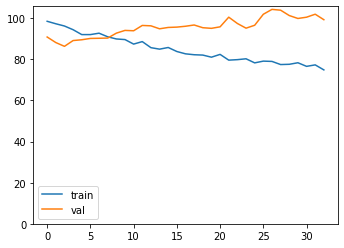

In [12]:
REQ_NAME = 'blurred'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    width_shift_range=0.3, 
    height_shift_range=0.3, 
    brightness_range=(0.7, 1.3),
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 15s 3ms/step - loss: 0.6997 - accuracy: 0.6019 - precision: 0.8725 - recall: 0.6189 - f1: 0.7212 - specificity: 0.5035 - negative_predictive_value: 0.1961 - matthews_correlation_coefficient: 0.0911 - equal_error_rate: 0.4336 - val_loss: 0.6327 - val_accuracy: 0.6356 - val_precision: 0.9097 - val_recall: 0.6250 - val_f1: 0.7405 - val_specificity: 0.6627 - val_negative_predictive_value: 0.2460 - val_matthews_correlation_coefficient: 0.2109 - val_equal_error_rate: 0.3407

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21087, saving model to ../../models/siamese_networks/blurred_2020_06_20-22_47_22.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6607 - accuracy: 0.5548 - precision: 0.9013 - recall: 0.5306 - f1: 0.6657 - specificity: 0.6901 - negative_predictive_value: 0.2164 - matthews_correlation_coefficient: 0.1606 - equal_

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6065 - accuracy: 0.6470 - precision: 0.9311 - recall: 0.6281 - f1: 0.7491 - specificity: 0.7560 - negative_predictive_value: 0.2743 - matthews_correlation_coefficient: 0.2801 - equal_error_rate: 0.3073 - val_loss: 0.5837 - val_accuracy: 0.6966 - val_precision: 0.9332 - val_recall: 0.6854 - val_f1: 0.7897 - val_specificity: 0.7308 - val_negative_predictive_value: 0.3002 - val_matthews_correlation_coefficient: 0.3108 - val_equal_error_rate: 0.2742

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.31172
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6003 - accuracy: 0.6394 - precision: 0.9255 - recall: 0.6226 - f1: 0.7436 - specificity: 0.7364 - negative_predictive_value: 0.2668 - matthews_correlation_coefficient: 0.2617 - equal_error_rate: 0.3037 - val_loss: 0.5821 - val_accuracy: 0.6957 - val_precision: 0.9370 - val_recall: 0.6815 - val_f1: 0.7883 - val_specifici


Epoch 00025: val_matthews_correlation_coefficient did not improve from 0.35562
Epoch 26/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5928 - accuracy: 0.6427 - precision: 0.9366 - recall: 0.6187 - f1: 0.7439 - specificity: 0.7756 - negative_predictive_value: 0.2756 - matthews_correlation_coefficient: 0.2879 - equal_error_rate: 0.3045 - val_loss: 0.5759 - val_accuracy: 0.6914 - val_precision: 0.9504 - val_recall: 0.6665 - val_f1: 0.7827 - val_specificity: 0.8103 - val_negative_predictive_value: 0.3093 - val_matthews_correlation_coefficient: 0.3508 - val_equal_error_rate: 0.2704

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.35562
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5818 - accuracy: 0.6560 - precision: 0.9297 - recall: 0.6419 - f1: 0.7583 - specificity: 0.7416 - negative_predictive_value: 0.2773 - matthews_correlation_coefficient: 0.2800 - equal_error_rate: 0.2985 - val_loss: 0.5783 - val_a

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5873 - accuracy: 0.6523 - precision: 0.9325 - recall: 0.6347 - f1: 0.7542 - specificity: 0.7465 - negative_predictive_value: 0.2775 - matthews_correlation_coefficient: 0.2816 - equal_error_rate: 0.3086 - val_loss: 0.5719 - val_accuracy: 0.6888 - val_precision: 0.9517 - val_recall: 0.6637 - val_f1: 0.7812 - val_specificity: 0.8128 - val_negative_predictive_value: 0.3084 - val_matthews_correlation_coefficient: 0.3510 - val_equal_error_rate: 0.2586

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.36042
Epoch 40/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5899 - accuracy: 0.6680 - precision: 0.9304 - recall: 0.6557 - f1: 0.7684 - specificity: 0.7365 - negative_predictive_value: 0.2859 - matthews_correlation_coefficient: 0.2901 - equal_error_rate: 0.2945 - val_loss: 0.5747 - val_accuracy: 0.6905 - val_precision: 0.9531 - val_recall: 0.6647 - val_f1: 0.7823 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5899 - accuracy: 0.6529 - precision: 0.9314 - recall: 0.6356 - f1: 0.7546 - specificity: 0.7521 - negative_predictive_value: 0.2767 - matthews_correlation_coefficient: 0.2822 - equal_error_rate: 0.3039 - val_loss: 0.5660 - val_accuracy: 0.6957 - val_precision: 0.9548 - val_recall: 0.6697 - val_f1: 0.7864 - val_specificity: 0.8223 - val_negative_predictive_value: 0.3150 - val_matthews_correlation_coefficient: 0.3633 - val_equal_error_rate: 0.2511

Epoch 00052: val_matthews_correlation_coefficient improved from 0.36248 to 0.36331, saving model to ../../models/siamese_networks/blurred_2020_06_20-22_47_22.h5
Epoch 53/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5865 - accuracy: 0.6612 - precision: 0.9289 - recall: 0.6481 - f1: 0.7626 - specificity: 0.7358 - negative_predictive_value: 0.2793 - matthews_correlation_coefficient: 0.2814 - equal_error_rate: 0.3013 - val_loss: 0.5653 - val_accuracy: 0.

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5828 - accuracy: 0.6612 - precision: 0.9326 - recall: 0.6458 - f1: 0.7620 - specificity: 0.7495 - negative_predictive_value: 0.2833 - matthews_correlation_coefficient: 0.2910 - equal_error_rate: 0.3035 - val_loss: 0.5547 - val_accuracy: 0.6957 - val_precision: 0.9511 - val_recall: 0.6728 - val_f1: 0.7871 - val_specificity: 0.8057 - val_negative_predictive_value: 0.3133 - val_matthews_correlation_coefficient: 0.3546 - val_equal_error_rate: 0.2481

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.36584
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5862 - accuracy: 0.6555 - precision: 0.9324 - recall: 0.6391 - f1: 0.7575 - specificity: 0.7510 - negative_predictive_value: 0.2800 - matthews_correlation_coefficient: 0.2869 - equal_error_rate: 0.3091 - val_loss: 0.5560 - val_accuracy: 0.6922 - val_precision: 0.9508 - val_recall: 0.6688 - val_f1: 0.7842 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5793 - accuracy: 0.6660 - precision: 0.9316 - recall: 0.6519 - f1: 0.7661 - specificity: 0.7459 - negative_predictive_value: 0.2872 - matthews_correlation_coefficient: 0.2942 - equal_error_rate: 0.2899 - val_loss: 0.5403 - val_accuracy: 0.7105 - val_precision: 0.9434 - val_recall: 0.6965 - val_f1: 0.8007 - val_specificity: 0.7683 - val_negative_predictive_value: 0.3193 - val_matthews_correlation_coefficient: 0.3485 - val_equal_error_rate: 0.2521

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.36584
Epoch 79/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5879 - accuracy: 0.6470 - precision: 0.9246 - recall: 0.6332 - f1: 0.7507 - specificity: 0.7276 - negative_predictive_value: 0.2687 - matthews_correlation_coefficient: 0.2627 - equal_error_rate: 0.3072 - val_loss: 0.5465 - val_accuracy: 0.7036 - val_precision: 0.9516 - val_recall: 0.6816 - val_f1: 0.7934 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5817 - accuracy: 0.6645 - precision: 0.9292 - recall: 0.6515 - f1: 0.7652 - specificity: 0.7342 - negative_predictive_value: 0.2821 - matthews_correlation_coefficient: 0.2842 - equal_error_rate: 0.3021 - val_loss: 0.5344 - val_accuracy: 0.7123 - val_precision: 0.9485 - val_recall: 0.6955 - val_f1: 0.8019 - val_specificity: 0.7902 - val_negative_predictive_value: 0.3239 - val_matthews_correlation_coefficient: 0.3626 - val_equal_error_rate: 0.2535

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.36584
Epoch 92/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5819 - accuracy: 0.6691 - precision: 0.9287 - recall: 0.6575 - f1: 0.7692 - specificity: 0.7310 - negative_predictive_value: 0.2846 - matthews_correlation_coefficient: 0.2863 - equal_error_rate: 0.2891 - val_loss: 0.5525 - val_accuracy: 0.7018 - val_precision: 0.9486 - val_recall: 0.6815 - val_f1: 0.7924 - val_specifici

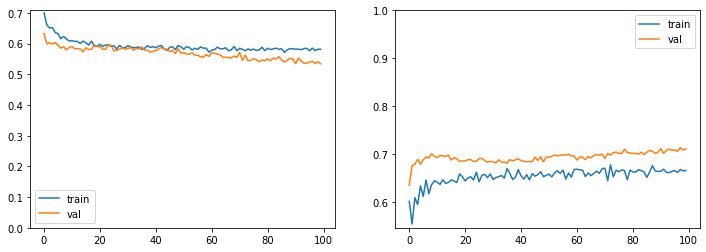

In [13]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks]).astype(np.int32)

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 3. Looking Away

146 of 146
159 of 159
(243, 160, 160, 3) float32
(243,) int32
(62, 160, 160, 3) float32
(62,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 56s 564ms/step - loss: 100.0179 - val_loss: 96.9040
Epoch 2/100
100/100 [==============================] - 55s 546ms/step - loss: 99.6870 - val_loss: 95.8013
Epoch 3/100
100/100 [==============================] - 55s 549ms/step - loss: 99.5036 - val_loss: 94.9888
Epoch 4/100
100/100 [==============================] - 54s 543ms/step - loss: 99.2867 - val_loss: 92.7826
Epoch 5/100
100/100 [==============================] - 55s 545ms/step - loss: 97.4903 - val_loss: 86.9230
Epoch 6/100
100/100 [==============================] - 56s 555ms/step - loss: 96.2568 - val_loss: 84.1960
Epoch 7/100
100/100 [==============================] - 54s 543ms/step - loss: 95.5606 - val_loss: 82.0933
Epoch 8/100
100/100 [==============================] - 54s 545ms/step - loss: 95.7441 - val_loss: 81.6716
Epoch 9/100
100/100 [==============================] - 55s 549ms/step - loss: 95.6027 - val_loss: 84.5718
Epoch 10/100
100/100 [=======================

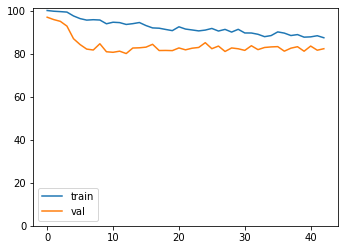

In [14]:
REQ_NAME = 'looking_away'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.7167 - accuracy: 0.5515 - precision: 0.7086 - recall: 0.5855 - f1: 0.6327 - specificity: 0.4590 - negative_predictive_value: 0.3328 - matthews_correlation_coefficient: 0.0428 - equal_error_rate: 0.4655 - val_loss: 0.6768 - val_accuracy: 0.5240 - val_precision: 0.7212 - val_recall: 0.5076 - val_f1: 0.5926 - val_specificity: 0.5767 - val_negative_predictive_value: 0.3529 - val_matthews_correlation_coefficient: 0.0789 - val_equal_error_rate: 0.4586

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.07894, saving model to ../../models/siamese_networks/looking_away_2020_06_20-23_47_30.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.7067 - accuracy: 0.5218 - precision: 0.7195 - recall: 0.4942 - f1: 0.5827 - specificity: 0.5839 - negative_predictive_value: 0.3463 - matthews_correlation_coefficient: 0.0716 - e


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.16388
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6723 - accuracy: 0.5709 - precision: 0.7615 - recall: 0.5470 - f1: 0.6343 - specificity: 0.6262 - negative_predictive_value: 0.3875 - matthews_correlation_coefficient: 0.1606 - equal_error_rate: 0.4053 - val_loss: 0.6665 - val_accuracy: 0.5798 - val_precision: 0.7593 - val_recall: 0.5748 - val_f1: 0.6510 - val_specificity: 0.6042 - val_negative_predictive_value: 0.3978 - val_matthews_correlation_coefficient: 0.1675 - val_equal_error_rate: 0.4000

Epoch 00014: val_matthews_correlation_coefficient improved from 0.16388 to 0.16754, saving model to ../../models/siamese_networks/looking_away_2020_06_20-23_47_30.h5
Epoch 15/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6761 - accuracy: 0.5718 - precision: 0.7492 - recall: 0.5640 - f1: 0.6415 - specificity: 0.5878 - negative_predictive_value: 0.3814 - matthew


Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.19039
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6691 - accuracy: 0.5840 - precision: 0.7645 - recall: 0.5715 - f1: 0.6517 - specificity: 0.6153 - negative_predictive_value: 0.3960 - matthews_correlation_coefficient: 0.1730 - equal_error_rate: 0.4024 - val_loss: 0.6696 - val_accuracy: 0.5798 - val_precision: 0.7638 - val_recall: 0.5650 - val_f1: 0.6463 - val_specificity: 0.6209 - val_negative_predictive_value: 0.3981 - val_matthews_correlation_coefficient: 0.1733 - val_equal_error_rate: 0.3986

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.19039
Epoch 28/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6662 - accuracy: 0.5964 - precision: 0.7696 - recall: 0.5908 - f1: 0.6661 - specificity: 0.6104 - negative_predictive_value: 0.4057 - matthews_correlation_coefficient: 0.1876 - equal_error_rate: 0.4014 - val_loss: 0.6759 - val_a

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6664 - accuracy: 0.5875 - precision: 0.7615 - recall: 0.5843 - f1: 0.6584 - specificity: 0.6015 - negative_predictive_value: 0.3971 - matthews_correlation_coefficient: 0.1715 - equal_error_rate: 0.4008 - val_loss: 0.6737 - val_accuracy: 0.5763 - val_precision: 0.7677 - val_recall: 0.5529 - val_f1: 0.6393 - val_specificity: 0.6363 - val_negative_predictive_value: 0.3973 - val_matthews_correlation_coefficient: 0.1766 - val_equal_error_rate: 0.3948

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.19039
Epoch 41/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6715 - accuracy: 0.5698 - precision: 0.7646 - recall: 0.5413 - f1: 0.6314 - specificity: 0.6340 - negative_predictive_value: 0.3878 - matthews_correlation_coefficient: 0.1633 - equal_error_rate: 0.4081 - val_loss: 0.6649 - val_accuracy: 0.5929 - val_precision: 0.7689 - val_recall: 0.5853 - val_f1: 0.6618 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6709 - accuracy: 0.5825 - precision: 0.7680 - recall: 0.5647 - f1: 0.6469 - specificity: 0.6239 - negative_predictive_value: 0.3972 - matthews_correlation_coefficient: 0.1763 - equal_error_rate: 0.3968 - val_loss: 0.6788 - val_accuracy: 0.5719 - val_precision: 0.7728 - val_recall: 0.5384 - val_f1: 0.6302 - val_specificity: 0.6551 - val_negative_predictive_value: 0.3967 - val_matthews_correlation_coefficient: 0.1810 - val_equal_error_rate: 0.3918

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.19039
Epoch 54/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6669 - accuracy: 0.5757 - precision: 0.7608 - recall: 0.5584 - f1: 0.6418 - specificity: 0.6165 - negative_predictive_value: 0.3907 - matthews_correlation_coefficient: 0.1627 - equal_error_rate: 0.4047 - val_loss: 0.6682 - val_accuracy: 0.5894 - val_precision: 0.7737 - val_recall: 0.5695 - val_f1: 0.6524 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6703 - accuracy: 0.5820 - precision: 0.7617 - recall: 0.5692 - f1: 0.6489 - specificity: 0.6177 - negative_predictive_value: 0.3959 - matthews_correlation_coefficient: 0.1714 - equal_error_rate: 0.4035 - val_loss: 0.6723 - val_accuracy: 0.5867 - val_precision: 0.7749 - val_recall: 0.5635 - val_f1: 0.6493 - val_specificity: 0.6441 - val_negative_predictive_value: 0.4059 - val_matthews_correlation_coefficient: 0.1937 - val_equal_error_rate: 0.3909

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.19739
Epoch 67/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6673 - accuracy: 0.5853 - precision: 0.7604 - recall: 0.5783 - f1: 0.6553 - specificity: 0.6006 - negative_predictive_value: 0.3957 - matthews_correlation_coefficient: 0.1670 - equal_error_rate: 0.4081 - val_loss: 0.6773 - val_accuracy: 0.5754 - val_precision: 0.7742 - val_recall: 0.5416 - val_f1: 0.6332 - val_specifici

4584/4584 [==============================] - 11s 3ms/step - loss: 0.6677 - accuracy: 0.5801 - precision: 0.7617 - recall: 0.5652 - f1: 0.6461 - specificity: 0.6166 - negative_predictive_value: 0.3945 - matthews_correlation_coefficient: 0.1684 - equal_error_rate: 0.4058 - val_loss: 0.6879 - val_accuracy: 0.5588 - val_precision: 0.7724 - val_recall: 0.5092 - val_f1: 0.6091 - val_specificity: 0.6726 - val_negative_predictive_value: 0.3886 - val_matthews_correlation_coefficient: 0.1709 - val_equal_error_rate: 0.3896

Epoch 00079: val_matthews_correlation_coefficient did not improve from 0.19840
Epoch 80/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6674 - accuracy: 0.5864 - precision: 0.7674 - recall: 0.5706 - f1: 0.6529 - specificity: 0.6233 - negative_predictive_value: 0.3984 - matthews_correlation_coefficient: 0.1792 - equal_error_rate: 0.3966 - val_loss: 0.6757 - val_accuracy: 0.5763 - val_precision: 0.7745 - val_recall: 0.5428 - val_f1: 0.6346 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6645 - accuracy: 0.6043 - precision: 0.7699 - recall: 0.6028 - f1: 0.6742 - specificity: 0.6021 - negative_predictive_value: 0.4093 - matthews_correlation_coefficient: 0.1915 - equal_error_rate: 0.3947 - val_loss: 0.6891 - val_accuracy: 0.5527 - val_precision: 0.7735 - val_recall: 0.4943 - val_f1: 0.5987 - val_specificity: 0.6836 - val_negative_predictive_value: 0.3844 - val_matthews_correlation_coefficient: 0.1675 - val_equal_error_rate: 0.3935

Epoch 00092: val_matthews_correlation_coefficient did not improve from 0.20339
Epoch 93/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6703 - accuracy: 0.5648 - precision: 0.7545 - recall: 0.5435 - f1: 0.6288 - specificity: 0.6148 - negative_predictive_value: 0.3820 - matthews_correlation_coefficient: 0.1469 - equal_error_rate: 0.4161 - val_loss: 0.6820 - val_accuracy: 0.5702 - val_precision: 0.7778 - val_recall: 0.5272 - val_f1: 0.6240 - val_specifici

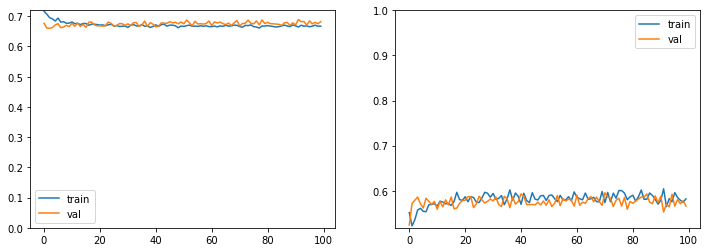

In [15]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### ~~4. Ink Marked/Creased~~

#### 5. Unnatural Skin Tone 

63 of 63
51 of 51
(90, 160, 160, 3) float32
(90,) int32
(24, 160, 160, 3) float32
(24,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 46s 462ms/step - loss: 90.2323 - val_loss: 93.9405
Epoch 2/100
100/100 [==============================] - 45s 448ms/step - loss: 72.9730 - val_loss: 111.9841
Epoch 3/100
100/100 [==============================] - 45s 449ms/step - loss: 66.4935 - val_loss: 108.7010
Epoch 4/100
100/100 [==============================] - 45s 449ms/step - loss: 57.7184 - val_loss: 108.9785
Epoch 5/100
100/100 [==============================] - 45s 449ms/step - loss: 49.8057 - val_loss: 107.0783
Epoch 6/100
100/100 [==============================] - 45s 449ms/step - loss: 44.9605 - val_loss: 107.1032
Epoch 7/100
100/100 [==============================] - 45s 449ms/step - loss: 39.8975 - val_loss: 105.9841
Epoch 8/100
100/100 [==============================] - 45s 449ms/step - loss: 36.9057 - val_loss: 106.0679
Epoch 9/100
100/100 [==============================] - 45s 449ms/step - loss: 35.5823 - val_loss: 106.4985
Epoch 10/100
100/100 [================

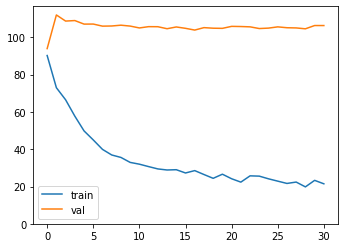

In [16]:
REQ_NAME = 'unnatural_skin_tone'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.7492 - accuracy: 0.5100 - precision: 0.4601 - recall: 0.5912 - f1: 0.5111 - specificity: 0.4445 - negative_predictive_value: 0.5772 - matthews_correlation_coefficient: 0.0364 - equal_error_rate: 0.4907 - val_loss: 0.6929 - val_accuracy: 0.5126 - val_precision: 0.4656 - val_recall: 0.8124 - val_f1: 0.5897 - val_specificity: 0.2706 - val_negative_predictive_value: 0.6482 - val_matthews_correlation_coefficient: 0.0970 - val_equal_error_rate: 0.4795

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.09701, saving model to ../../models/siamese_networks/unnatural_skin_tone_2020_06_21-00_30_34.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.7302 - accuracy: 0.5098 - precision: 0.4492 - recall: 0.4849 - f1: 0.4625 - specificity: 0.5310 - negative_predictive_value: 0.5658 - matthews_correlation_coefficient: 0.0


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.22572
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6943 - accuracy: 0.5286 - precision: 0.4742 - recall: 0.5706 - f1: 0.5143 - specificity: 0.4971 - negative_predictive_value: 0.5931 - matthews_correlation_coefficient: 0.0675 - equal_error_rate: 0.4628 - val_loss: 0.6786 - val_accuracy: 0.5397 - val_precision: 0.4823 - val_recall: 0.9373 - val_f1: 0.6353 - val_specificity: 0.2115 - val_negative_predictive_value: 0.8171 - val_matthews_correlation_coefficient: 0.2094 - val_equal_error_rate: 0.3640

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.22572
Epoch 15/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6897 - accuracy: 0.5388 - precision: 0.4830 - recall: 0.5596 - f1: 0.5141 - specificity: 0.5250 - negative_predictive_value: 0.6006 - matthews_correlation_coefficient: 0.0841 - equal_error_rate: 0.4568 - val_loss: 0.6777 - val_a

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6830 - accuracy: 0.5582 - precision: 0.5034 - recall: 0.5754 - f1: 0.5311 - specificity: 0.5498 - negative_predictive_value: 0.6209 - matthews_correlation_coefficient: 0.1248 - equal_error_rate: 0.4374 - val_loss: 0.6833 - val_accuracy: 0.5170 - val_precision: 0.4703 - val_recall: 0.9385 - val_f1: 0.6249 - val_specificity: 0.1723 - val_negative_predictive_value: 0.7977 - val_matthews_correlation_coefficient: 0.1712 - val_equal_error_rate: 0.3812

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.29367
Epoch 28/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6819 - accuracy: 0.5561 - precision: 0.5016 - recall: 0.5392 - f1: 0.5147 - specificity: 0.5706 - negative_predictive_value: 0.6088 - matthews_correlation_coefficient: 0.1100 - equal_error_rate: 0.4452 - val_loss: 0.6873 - val_accuracy: 0.5074 - val_precision: 0.4663 - val_recall: 0.9470 - val_f1: 0.6231 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6800 - accuracy: 0.5591 - precision: 0.5025 - recall: 0.5802 - f1: 0.5351 - specificity: 0.5452 - negative_predictive_value: 0.6212 - matthews_correlation_coefficient: 0.1245 - equal_error_rate: 0.4407 - val_loss: 0.6804 - val_accuracy: 0.5310 - val_precision: 0.4783 - val_recall: 0.9365 - val_f1: 0.6314 - val_specificity: 0.1996 - val_negative_predictive_value: 0.8059 - val_matthews_correlation_coefficient: 0.1948 - val_equal_error_rate: 0.3694

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.29367
Epoch 41/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6755 - accuracy: 0.5711 - precision: 0.5152 - recall: 0.5802 - f1: 0.5425 - specificity: 0.5656 - negative_predictive_value: 0.6293 - matthews_correlation_coefficient: 0.1451 - equal_error_rate: 0.4289 - val_loss: 0.6761 - val_accuracy: 0.5571 - val_precision: 0.4921 - val_recall: 0.9069 - val_f1: 0.6364 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6763 - accuracy: 0.5772 - precision: 0.5201 - recall: 0.5772 - f1: 0.5445 - specificity: 0.5780 - negative_predictive_value: 0.6340 - matthews_correlation_coefficient: 0.1546 - equal_error_rate: 0.4259 - val_loss: 0.6781 - val_accuracy: 0.5440 - val_precision: 0.4855 - val_recall: 0.9280 - val_f1: 0.6358 - val_specificity: 0.2279 - val_negative_predictive_value: 0.7983 - val_matthews_correlation_coefficient: 0.2081 - val_equal_error_rate: 0.3684

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.29367
Epoch 54/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6763 - accuracy: 0.5742 - precision: 0.5186 - recall: 0.5696 - f1: 0.5392 - specificity: 0.5790 - negative_predictive_value: 0.6287 - matthews_correlation_coefficient: 0.1479 - equal_error_rate: 0.4278 - val_loss: 0.6783 - val_accuracy: 0.5501 - val_precision: 0.4893 - val_recall: 0.9316 - val_f1: 0.6399 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6754 - accuracy: 0.5774 - precision: 0.5165 - recall: 0.6151 - f1: 0.5590 - specificity: 0.5454 - negative_predictive_value: 0.6426 - matthews_correlation_coefficient: 0.1598 - equal_error_rate: 0.4214 - val_loss: 0.6747 - val_accuracy: 0.5597 - val_precision: 0.4949 - val_recall: 0.9098 - val_f1: 0.6391 - val_specificity: 0.2713 - val_negative_predictive_value: 0.7961 - val_matthews_correlation_coefficient: 0.2275 - val_equal_error_rate: 0.3676

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.29367
Epoch 67/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6771 - accuracy: 0.5678 - precision: 0.5116 - recall: 0.5766 - f1: 0.5383 - specificity: 0.5620 - negative_predictive_value: 0.6271 - matthews_correlation_coefficient: 0.1386 - equal_error_rate: 0.4277 - val_loss: 0.6783 - val_accuracy: 0.5405 - val_precision: 0.4834 - val_recall: 0.9220 - val_f1: 0.6324 - val_specifici

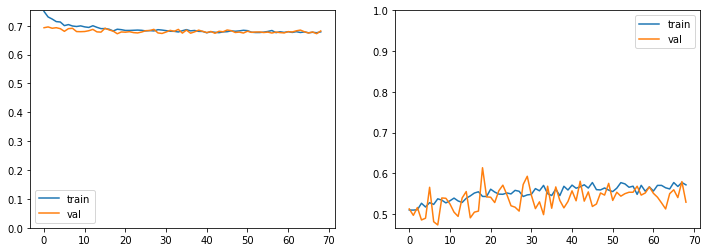

In [17]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 6. Too Dark/Light 

78 of 78
74 of 74
(121, 160, 160, 3) float32
(121,) int32
(31, 160, 160, 3) float32
(31,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 48s 475ms/step - loss: 92.2615 - val_loss: 99.4295
Epoch 2/100
100/100 [==============================] - 46s 462ms/step - loss: 79.8708 - val_loss: 109.9842
Epoch 3/100
100/100 [==============================] - 46s 463ms/step - loss: 73.3352 - val_loss: 116.4895
Epoch 4/100
100/100 [==============================] - 46s 463ms/step - loss: 66.3194 - val_loss: 118.3334
Epoch 5/100
100/100 [==============================] - 46s 463ms/step - loss: 59.7685 - val_loss: 128.3604
Epoch 6/100
100/100 [==============================] - 46s 462ms/step - loss: 58.0938 - val_loss: 125.8079
Epoch 7/100
100/100 [==============================] - 46s 463ms/step - loss: 52.2115 - val_loss: 119.4211
Epoch 8/100
100/100 [==============================] - 46s 463ms/step - loss: 49.8114 - val_loss: 122.5143
Epoch 9/100
100/100 [==============================] - 46s 463ms/step - loss: 46.6742 - val_loss: 123.9200
Epoch 10/100
100/100 [================

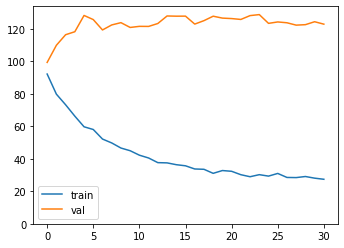

In [18]:
REQ_NAME = 'too_dark_light'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.7635 - accuracy: 0.5735 - precision: 0.9136 - recall: 0.5935 - f1: 0.7176 - specificity: 0.3465 - negative_predictive_value: 0.0665 - matthews_correlation_coefficient: -0.0340 - equal_error_rate: 0.4979 - val_loss: 0.5944 - val_accuracy: 0.6844 - val_precision: 0.9164 - val_recall: 0.7148 - val_f1: 0.8019 - val_specificity: 0.2462 - val_negative_predictive_value: 0.0686 - val_matthews_correlation_coefficient: -0.0238 - val_equal_error_rate: 0.4681

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.02376, saving model to ../../models/siamese_networks/too_dark_light_2020_06_21-01_08_51.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.7246 - accuracy: 0.5633 - precision: 0.9270 - recall: 0.5715 - f1: 0.7059 - specificity: 0.4753 - negative_predictive_value: 0.0847 - matthews_correlation_coefficient: 0.022

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6584 - accuracy: 0.6257 - precision: 0.9452 - recall: 0.6304 - f1: 0.7555 - specificity: 0.5869 - negative_predictive_value: 0.1154 - matthews_correlation_coefficient: 0.1118 - equal_error_rate: 0.3760 - val_loss: 0.5697 - val_accuracy: 0.7829 - val_precision: 0.9519 - val_recall: 0.7997 - val_f1: 0.8684 - val_specificity: 0.5118 - val_negative_predictive_value: 0.1849 - val_matthews_correlation_coefficient: 0.2047 - val_equal_error_rate: 0.2843

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.22226
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6507 - accuracy: 0.6154 - precision: 0.9473 - recall: 0.6179 - f1: 0.7466 - specificity: 0.6090 - negative_predictive_value: 0.1181 - matthews_correlation_coefficient: 0.1195 - equal_error_rate: 0.3757 - val_loss: 0.5672 - val_accuracy: 0.7873 - val_precision: 0.9532 - val_recall: 0.8043 - val_f1: 0.8718 - val_specifici


Epoch 00025: val_matthews_correlation_coefficient improved from 0.25278 to 0.25638, saving model to ../../models/siamese_networks/too_dark_light_2020_06_21-01_08_51.h5
Epoch 26/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6391 - accuracy: 0.6614 - precision: 0.9503 - recall: 0.6678 - f1: 0.7833 - specificity: 0.5921 - negative_predictive_value: 0.1329 - matthews_correlation_coefficient: 0.1448 - equal_error_rate: 0.3559 - val_loss: 0.5929 - val_accuracy: 0.7297 - val_precision: 0.9647 - val_recall: 0.7280 - val_f1: 0.8285 - val_specificity: 0.6802 - val_negative_predictive_value: 0.1784 - val_matthews_correlation_coefficient: 0.2392 - val_equal_error_rate: 0.2609

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.25638
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6287 - accuracy: 0.6411 - precision: 0.9524 - recall: 0.6427 - f1: 0.7662 - specificity: 0.6223 - negative_predictive_value: 0.1317 - matth

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6135 - accuracy: 0.6686 - precision: 0.9594 - recall: 0.6684 - f1: 0.7867 - specificity: 0.6814 - negative_predictive_value: 0.1458 - matthews_correlation_coefficient: 0.1887 - equal_error_rate: 0.3244 - val_loss: 0.5680 - val_accuracy: 0.7350 - val_precision: 0.9628 - val_recall: 0.7345 - val_f1: 0.8316 - val_specificity: 0.6628 - val_negative_predictive_value: 0.1799 - val_matthews_correlation_coefficient: 0.2355 - val_equal_error_rate: 0.2793

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.25659
Epoch 40/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6134 - accuracy: 0.7033 - precision: 0.9548 - recall: 0.7119 - f1: 0.8143 - specificity: 0.5855 - negative_predictive_value: 0.1546 - matthews_correlation_coefficient: 0.1783 - equal_error_rate: 0.3297 - val_loss: 0.5757 - val_accuracy: 0.7123 - val_precision: 0.9636 - val_recall: 0.7072 - val_f1: 0.8139 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6171 - accuracy: 0.6601 - precision: 0.9562 - recall: 0.6619 - f1: 0.7812 - specificity: 0.6323 - negative_predictive_value: 0.1415 - matthews_correlation_coefficient: 0.1681 - equal_error_rate: 0.3372 - val_loss: 0.5694 - val_accuracy: 0.6914 - val_precision: 0.9648 - val_recall: 0.6818 - val_f1: 0.7967 - val_specificity: 0.6941 - val_negative_predictive_value: 0.1628 - val_matthews_correlation_coefficient: 0.2166 - val_equal_error_rate: 0.2846

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.25659
Epoch 53/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6238 - accuracy: 0.6854 - precision: 0.9526 - recall: 0.6930 - f1: 0.8012 - specificity: 0.6044 - negative_predictive_value: 0.1451 - matthews_correlation_coefficient: 0.1673 - equal_error_rate: 0.3397 - val_loss: 0.5956 - val_accuracy: 0.6417 - val_precision: 0.9658 - val_recall: 0.6265 - val_f1: 0.7582 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6126 - accuracy: 0.6726 - precision: 0.9522 - recall: 0.6792 - f1: 0.7916 - specificity: 0.6180 - negative_predictive_value: 0.1383 - matthews_correlation_coefficient: 0.1619 - equal_error_rate: 0.3341 - val_loss: 0.5796 - val_accuracy: 0.6452 - val_precision: 0.9635 - val_recall: 0.6331 - val_f1: 0.7625 - val_specificity: 0.6993 - val_negative_predictive_value: 0.1450 - val_matthews_correlation_coefficient: 0.1877 - val_equal_error_rate: 0.2947

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.25659
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6163 - accuracy: 0.6660 - precision: 0.9589 - recall: 0.6660 - f1: 0.7845 - specificity: 0.6709 - negative_predictive_value: 0.1474 - matthews_correlation_coefficient: 0.1869 - equal_error_rate: 0.3125 - val_loss: 0.5717 - val_accuracy: 0.6670 - val_precision: 0.9635 - val_recall: 0.6575 - val_f1: 0.7801 - val_specifici

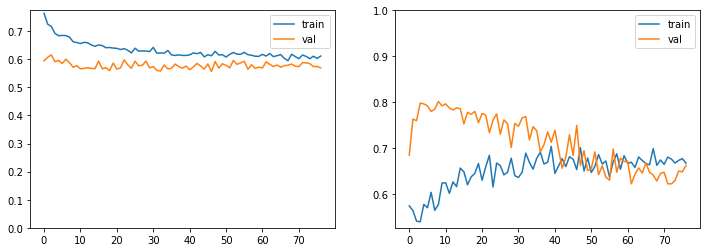

In [19]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 7. Washed Out

79 of 79
43 of 43
(97, 160, 160, 3) float32
(97,) int32
(25, 160, 160, 3) float32
(25,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 46s 456ms/step - loss: 100.5818 - val_loss: 94.6753
Epoch 2/100
100/100 [==============================] - 44s 442ms/step - loss: 99.1781 - val_loss: 90.4054
Epoch 3/100
100/100 [==============================] - 44s 442ms/step - loss: 96.9670 - val_loss: 76.3007
Epoch 4/100
100/100 [==============================] - 44s 442ms/step - loss: 94.9249 - val_loss: 65.6884
Epoch 5/100
100/100 [==============================] - 44s 443ms/step - loss: 92.3033 - val_loss: 71.2952
Epoch 6/100
100/100 [==============================] - 44s 442ms/step - loss: 90.9322 - val_loss: 61.0841
Epoch 7/100
100/100 [==============================] - 44s 442ms/step - loss: 89.7089 - val_loss: 50.3999
Epoch 8/100
100/100 [==============================] - 44s 442ms/step - loss: 87.7957 - val_loss: 52.7319
Epoch 9/100
100/100 [==============================] - 44s 442ms/step - loss: 85.6715 - val_loss: 49.2464
Epoch 10/100
100/100 [=======================

100/100 [==============================] - 44s 442ms/step - loss: 56.6047 - val_loss: 15.3426
Epoch 78/100
100/100 [==============================] - 44s 442ms/step - loss: 57.5472 - val_loss: 14.4836
Epoch 79/100
100/100 [==============================] - 44s 442ms/step - loss: 57.5564 - val_loss: 15.6767
Epoch 80/100
100/100 [==============================] - 44s 443ms/step - loss: 57.3212 - val_loss: 12.0713
Epoch 81/100
100/100 [==============================] - 44s 442ms/step - loss: 57.8076 - val_loss: 15.4931
Epoch 82/100
100/100 [==============================] - 44s 442ms/step - loss: 58.1136 - val_loss: 13.3249
Epoch 83/100
100/100 [==============================] - 44s 442ms/step - loss: 55.2814 - val_loss: 11.5604
Epoch 84/100
100/100 [==============================] - 44s 443ms/step - loss: 56.3898 - val_loss: 11.4388
Epoch 85/100
100/100 [==============================] - 44s 442ms/step - loss: 58.2361 - val_loss: 13.8138
Epoch 86/100
100/100 [============================

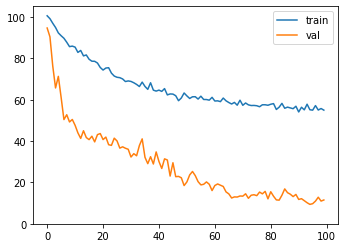

In [20]:
REQ_NAME = 'washed_out'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6797 - accuracy: 0.7315 - precision: 0.9913 - recall: 0.7346 - f1: 0.8426 - specificity: 0.3152 - negative_predictive_value: 0.0213 - matthews_correlation_coefficient: 0.0378 - equal_error_rate: 0.1732 - val_loss: 0.4523 - val_accuracy: 0.7881 - val_precision: 0.9899 - val_recall: 0.7945 - val_f1: 0.8813 - val_specificity: 0.3500 - val_negative_predictive_value: 0.0227 - val_matthews_correlation_coefficient: 0.0491 - val_equal_error_rate: 0.1906

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.04911, saving model to ../../models/siamese_networks/washed_out_2020_06_21-02_38_26.h5
Epoch 2/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.6811 - accuracy: 0.6534 - precision: 0.9925 - recall: 0.6542 - f1: 0.7876 - specificity: 0.4565 - negative_predictive_value: 0.0214 - matthews_correlation_coefficient: 0.0513 - equ

4584/4584 [==============================] - 10s 2ms/step - loss: 0.5616 - accuracy: 0.6702 - precision: 0.9942 - recall: 0.6699 - f1: 0.7998 - specificity: 0.4710 - negative_predictive_value: 0.0258 - matthews_correlation_coefficient: 0.0669 - equal_error_rate: 0.1258 - val_loss: 0.5576 - val_accuracy: 0.7044 - val_precision: 0.9939 - val_recall: 0.7082 - val_f1: 0.8261 - val_specificity: 0.4417 - val_negative_predictive_value: 0.0244 - val_matthews_correlation_coefficient: 0.0601 - val_equal_error_rate: 0.1259

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.06345
Epoch 14/100
4584/4584 [==============================] - 10s 2ms/step - loss: 0.5960 - accuracy: 0.6619 - precision: 0.9942 - recall: 0.6616 - f1: 0.7937 - specificity: 0.5112 - negative_predictive_value: 0.0258 - matthews_correlation_coefficient: 0.0718 - equal_error_rate: 0.1271 - val_loss: 0.5819 - val_accuracy: 0.6870 - val_precision: 0.9938 - val_recall: 0.6912 - val_f1: 0.8141 - val_specifici

4584/4584 [==============================] - 10s 2ms/step - loss: 0.5556 - accuracy: 0.6398 - precision: 0.9973 - recall: 0.6369 - f1: 0.7766 - specificity: 0.5688 - negative_predictive_value: 0.0289 - matthews_correlation_coefficient: 0.0885 - equal_error_rate: 0.1073 - val_loss: 0.5951 - val_accuracy: 0.6408 - val_precision: 0.9958 - val_recall: 0.6410 - val_f1: 0.7788 - val_specificity: 0.5667 - val_negative_predictive_value: 0.0245 - val_matthews_correlation_coefficient: 0.0738 - val_equal_error_rate: 0.1203

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.07829
Epoch 27/100
4584/4584 [==============================] - 10s 2ms/step - loss: 0.5728 - accuracy: 0.6575 - precision: 0.9949 - recall: 0.6567 - f1: 0.7903 - specificity: 0.5580 - negative_predictive_value: 0.0272 - matthews_correlation_coefficient: 0.0790 - equal_error_rate: 0.1290 - val_loss: 0.6098 - val_accuracy: 0.6269 - val_precision: 0.9958 - val_recall: 0.6256 - val_f1: 0.7673 - val_specifici

4584/4584 [==============================] - 10s 2ms/step - loss: 0.5538 - accuracy: 0.6924 - precision: 0.9949 - recall: 0.6918 - f1: 0.8156 - specificity: 0.5199 - negative_predictive_value: 0.0292 - matthews_correlation_coefficient: 0.0829 - equal_error_rate: 0.1119 - val_loss: 0.5607 - val_accuracy: 0.6765 - val_precision: 0.9948 - val_recall: 0.6792 - val_f1: 0.8061 - val_specificity: 0.4833 - val_negative_predictive_value: 0.0242 - val_matthews_correlation_coefficient: 0.0639 - val_equal_error_rate: 0.1182

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.07829
Epoch 40/100
4584/4584 [==============================] - 10s 2ms/step - loss: 0.5478 - accuracy: 0.6640 - precision: 0.9957 - recall: 0.6628 - f1: 0.7951 - specificity: 0.5308 - negative_predictive_value: 0.0294 - matthews_correlation_coefficient: 0.0857 - equal_error_rate: 0.1107 - val_loss: 0.5716 - val_accuracy: 0.6548 - val_precision: 0.9959 - val_recall: 0.6545 - val_f1: 0.7888 - val_specifici

4584/4584 [==============================] - 10s 2ms/step - loss: 0.5893 - accuracy: 0.6649 - precision: 0.9949 - recall: 0.6641 - f1: 0.7949 - specificity: 0.4475 - negative_predictive_value: 0.0282 - matthews_correlation_coefficient: 0.0730 - equal_error_rate: 0.1071 - val_loss: 0.6789 - val_accuracy: 0.5772 - val_precision: 0.9967 - val_recall: 0.5766 - val_f1: 0.7291 - val_specificity: 0.6500 - val_negative_predictive_value: 0.0233 - val_matthews_correlation_coefficient: 0.0776 - val_equal_error_rate: 0.1233

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.07829
Epoch 53/100
4584/4584 [==============================] - 10s 2ms/step - loss: 0.5324 - accuracy: 0.6318 - precision: 0.9969 - recall: 0.6292 - f1: 0.7708 - specificity: 0.6196 - negative_predictive_value: 0.0283 - matthews_correlation_coefficient: 0.0912 - equal_error_rate: 0.1068 - val_loss: 0.6026 - val_accuracy: 0.6129 - val_precision: 0.9956 - val_recall: 0.6121 - val_f1: 0.7568 - val_specifici

4584/4584 [==============================] - 10s 2ms/step - loss: 0.5559 - accuracy: 0.6590 - precision: 0.9964 - recall: 0.6569 - f1: 0.7911 - specificity: 0.6254 - negative_predictive_value: 0.0289 - matthews_correlation_coefficient: 0.0931 - equal_error_rate: 0.1172 - val_loss: 0.6005 - val_accuracy: 0.6303 - val_precision: 0.9957 - val_recall: 0.6318 - val_f1: 0.7714 - val_specificity: 0.5667 - val_negative_predictive_value: 0.0238 - val_matthews_correlation_coefficient: 0.0717 - val_equal_error_rate: 0.1208

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.08086
Epoch 66/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.5939 - accuracy: 0.6726 - precision: 0.9959 - recall: 0.6711 - f1: 0.8009 - specificity: 0.5761 - negative_predictive_value: 0.0301 - matthews_correlation_coefficient: 0.0917 - equal_error_rate: 0.1247 - val_loss: 0.6213 - val_accuracy: 0.6112 - val_precision: 0.9957 - val_recall: 0.6104 - val_f1: 0.7557 - val_specifici

4584/4584 [==============================] - 10s 2ms/step - loss: 0.5554 - accuracy: 0.6540 - precision: 0.9967 - recall: 0.6519 - f1: 0.7876 - specificity: 0.5797 - negative_predictive_value: 0.0295 - matthews_correlation_coefficient: 0.0925 - equal_error_rate: 0.1108 - val_loss: 0.6005 - val_accuracy: 0.6207 - val_precision: 0.9957 - val_recall: 0.6215 - val_f1: 0.7638 - val_specificity: 0.5667 - val_negative_predictive_value: 0.0233 - val_matthews_correlation_coefficient: 0.0696 - val_equal_error_rate: 0.1168

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.08581
Epoch 79/100
4584/4584 [==============================] - 10s 2ms/step - loss: 0.5341 - accuracy: 0.6660 - precision: 0.9947 - recall: 0.6656 - f1: 0.7965 - specificity: 0.5761 - negative_predictive_value: 0.0274 - matthews_correlation_coefficient: 0.0810 - equal_error_rate: 0.1219 - val_loss: 0.5444 - val_accuracy: 0.6565 - val_precision: 0.9959 - val_recall: 0.6572 - val_f1: 0.7908 - val_specifici

4584/4584 [==============================] - 10s 2ms/step - loss: 0.5491 - accuracy: 0.6708 - precision: 0.9965 - recall: 0.6691 - f1: 0.7999 - specificity: 0.5978 - negative_predictive_value: 0.0306 - matthews_correlation_coefficient: 0.0944 - equal_error_rate: 0.1042 - val_loss: 0.6294 - val_accuracy: 0.5998 - val_precision: 0.9968 - val_recall: 0.5976 - val_f1: 0.7460 - val_specificity: 0.6500 - val_negative_predictive_value: 0.0245 - val_matthews_correlation_coefficient: 0.0824 - val_equal_error_rate: 0.1185

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.08692
Epoch 92/100
4584/4584 [==============================] - 10s 2ms/step - loss: 0.5253 - accuracy: 0.6739 - precision: 0.9967 - recall: 0.6722 - f1: 0.8023 - specificity: 0.5819 - negative_predictive_value: 0.0316 - matthews_correlation_coefficient: 0.0960 - equal_error_rate: 0.1006 - val_loss: 0.5946 - val_accuracy: 0.6155 - val_precision: 0.9969 - val_recall: 0.6147 - val_f1: 0.7592 - val_specifici

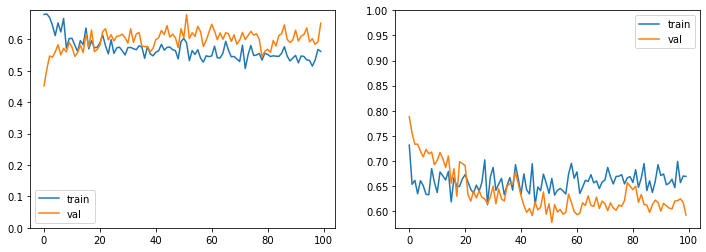

In [21]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 8. Pixelation

79 of 79
105 of 105
(147, 160, 160, 3) float32
(147,) int32
(37, 160, 160, 3) float32
(37,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 58s 581ms/step - loss: 98.5230 - val_loss: 105.5156
Epoch 2/100
100/100 [==============================] - 57s 566ms/step - loss: 97.3331 - val_loss: 111.9036
Epoch 3/100
100/100 [==============================] - 57s 567ms/step - loss: 95.7370 - val_loss: 115.0851
Epoch 4/100
100/100 [==============================] - 57s 567ms/step - loss: 96.0540 - val_loss: 118.6650
Epoch 5/100
100/100 [==============================] - 57s 567ms/step - loss: 94.8321 - val_loss: 126.4676
Epoch 6/100
100/100 [==============================] - 57s 567ms/step - loss: 93.4936 - val_loss: 125.5359
Epoch 7/100
100/100 [==============================] - 57s 567ms/step - loss: 93.5124 - val_loss: 130.0612
Epoch 8/100
100/100 [==============================] - 57s 567ms/step - loss: 92.0237 - val_loss: 135.7236
Epoch 9/100
100/100 [==============================] - 57s 567ms/step - loss: 93.4959 - val_loss: 129.5660
Epoch 10/100
100/100 [===============

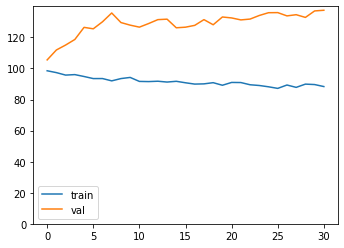

In [22]:
REQ_NAME = 'pixelation'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.7744 - accuracy: 0.5940 - precision: 0.9242 - recall: 0.6153 - f1: 0.7363 - specificity: 0.2701 - negative_predictive_value: 0.0466 - matthews_correlation_coefficient: -0.0559 - equal_error_rate: 0.5541 - val_loss: 0.6614 - val_accuracy: 0.6617 - val_precision: 0.9285 - val_recall: 0.7000 - val_f1: 0.7967 - val_specificity: 0.2379 - val_negative_predictive_value: 0.0487 - val_matthews_correlation_coefficient: -0.0379 - val_equal_error_rate: 0.4956

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.03787, saving model to ../../models/siamese_networks/pixelation_2020_06_21-03_25_55.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.7286 - accuracy: 0.4435 - precision: 0.9303 - recall: 0.4382 - f1: 0.5938 - specificity: 0.5226 - negative_predictive_value: 0.0606 - matthews_correlation_coefficient: -0.0190 -


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.13252
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6733 - accuracy: 0.5982 - precision: 0.9545 - recall: 0.5988 - f1: 0.7351 - specificity: 0.6027 - negative_predictive_value: 0.0930 - matthews_correlation_coefficient: 0.0963 - equal_error_rate: 0.3691 - val_loss: 0.6766 - val_accuracy: 0.5754 - val_precision: 0.9637 - val_recall: 0.5649 - val_f1: 0.7099 - val_specificity: 0.6861 - val_negative_predictive_value: 0.0973 - val_matthews_correlation_coefficient: 0.1211 - val_equal_error_rate: 0.3377

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.13252
Epoch 15/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6657 - accuracy: 0.5672 - precision: 0.9591 - recall: 0.5612 - f1: 0.7073 - specificity: 0.6474 - negative_predictive_value: 0.0945 - matthews_correlation_coefficient: 0.1050 - equal_error_rate: 0.3697 - val_loss: 0.6808 - val_a

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6567 - accuracy: 0.6119 - precision: 0.9600 - recall: 0.6103 - f1: 0.7454 - specificity: 0.6378 - negative_predictive_value: 0.1022 - matthews_correlation_coefficient: 0.1225 - equal_error_rate: 0.3536 - val_loss: 0.6671 - val_accuracy: 0.5580 - val_precision: 0.9682 - val_recall: 0.5443 - val_f1: 0.6947 - val_specificity: 0.7166 - val_negative_predictive_value: 0.0960 - val_matthews_correlation_coefficient: 0.1269 - val_equal_error_rate: 0.3314

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.13252
Epoch 28/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6604 - accuracy: 0.6132 - precision: 0.9589 - recall: 0.6126 - f1: 0.7464 - specificity: 0.6336 - negative_predictive_value: 0.1003 - matthews_correlation_coefficient: 0.1174 - equal_error_rate: 0.3426 - val_loss: 0.6805 - val_accuracy: 0.5501 - val_precision: 0.9678 - val_recall: 0.5364 - val_f1: 0.6884 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6640 - accuracy: 0.5696 - precision: 0.9641 - recall: 0.5612 - f1: 0.7082 - specificity: 0.6931 - negative_predictive_value: 0.0981 - matthews_correlation_coefficient: 0.1239 - equal_error_rate: 0.3608 - val_loss: 0.6754 - val_accuracy: 0.5414 - val_precision: 0.9686 - val_recall: 0.5267 - val_f1: 0.6807 - val_specificity: 0.7332 - val_negative_predictive_value: 0.0951 - val_matthews_correlation_coefficient: 0.1262 - val_equal_error_rate: 0.3359

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.13589
Epoch 41/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6561 - accuracy: 0.5997 - precision: 0.9635 - recall: 0.5949 - f1: 0.7344 - specificity: 0.6763 - negative_predictive_value: 0.1032 - matthews_correlation_coefficient: 0.1321 - equal_error_rate: 0.3354 - val_loss: 0.6555 - val_accuracy: 0.5676 - val_precision: 0.9639 - val_recall: 0.5579 - val_f1: 0.7049 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6542 - accuracy: 0.5958 - precision: 0.9629 - recall: 0.5907 - f1: 0.7311 - specificity: 0.6769 - negative_predictive_value: 0.1030 - matthews_correlation_coefficient: 0.1321 - equal_error_rate: 0.3438 - val_loss: 0.6710 - val_accuracy: 0.5545 - val_precision: 0.9626 - val_recall: 0.5444 - val_f1: 0.6935 - val_specificity: 0.6850 - val_negative_predictive_value: 0.0922 - val_matthews_correlation_coefficient: 0.1097 - val_equal_error_rate: 0.3293

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.13589
Epoch 54/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6497 - accuracy: 0.6156 - precision: 0.9642 - recall: 0.6124 - f1: 0.7474 - specificity: 0.6684 - negative_predictive_value: 0.1066 - matthews_correlation_coefficient: 0.1401 - equal_error_rate: 0.3442 - val_loss: 0.6678 - val_accuracy: 0.5562 - val_precision: 0.9628 - val_recall: 0.5462 - val_f1: 0.6950 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6614 - accuracy: 0.5969 - precision: 0.9645 - recall: 0.5916 - f1: 0.7313 - specificity: 0.6643 - negative_predictive_value: 0.1050 - matthews_correlation_coefficient: 0.1317 - equal_error_rate: 0.3378 - val_loss: 0.6816 - val_accuracy: 0.5554 - val_precision: 0.9642 - val_recall: 0.5444 - val_f1: 0.6942 - val_specificity: 0.6954 - val_negative_predictive_value: 0.0933 - val_matthews_correlation_coefficient: 0.1150 - val_equal_error_rate: 0.3380

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.13589
Epoch 67/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6539 - accuracy: 0.5973 - precision: 0.9637 - recall: 0.5916 - f1: 0.7324 - specificity: 0.6962 - negative_predictive_value: 0.1037 - matthews_correlation_coefficient: 0.1371 - equal_error_rate: 0.3470 - val_loss: 0.6654 - val_accuracy: 0.5623 - val_precision: 0.9616 - val_recall: 0.5534 - val_f1: 0.7006 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6503 - accuracy: 0.6344 - precision: 0.9610 - recall: 0.6349 - f1: 0.7641 - specificity: 0.6493 - negative_predictive_value: 0.1049 - matthews_correlation_coefficient: 0.1331 - equal_error_rate: 0.3402 - val_loss: 0.6761 - val_accuracy: 0.5719 - val_precision: 0.9666 - val_recall: 0.5604 - val_f1: 0.7075 - val_specificity: 0.7121 - val_negative_predictive_value: 0.0984 - val_matthews_correlation_coefficient: 0.1305 - val_equal_error_rate: 0.3462

Epoch 00079: val_matthews_correlation_coefficient did not improve from 0.13589
Epoch 80/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6541 - accuracy: 0.6134 - precision: 0.9601 - recall: 0.6127 - f1: 0.7469 - specificity: 0.6239 - negative_predictive_value: 0.1017 - matthews_correlation_coefficient: 0.1190 - equal_error_rate: 0.3511 - val_loss: 0.6627 - val_accuracy: 0.5772 - val_precision: 0.9653 - val_recall: 0.5668 - val_f1: 0.7123 - val_specifici

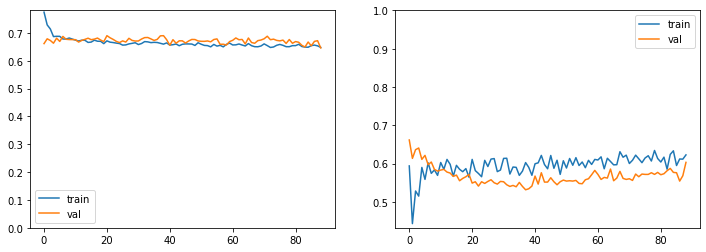

In [23]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 9. Hair Across Eyes 

181 of 181
179 of 179
(287, 160, 160, 3) float32
(287,) int32
(73, 160, 160, 3) float32
(73,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 58s 584ms/step - loss: 96.1662 - val_loss: 98.2405
Epoch 2/100
100/100 [==============================] - 56s 563ms/step - loss: 93.4786 - val_loss: 98.9616
Epoch 3/100
100/100 [==============================] - 56s 563ms/step - loss: 92.7524 - val_loss: 99.0759
Epoch 4/100
100/100 [==============================] - 56s 565ms/step - loss: 91.7989 - val_loss: 102.0620
Epoch 5/100
100/100 [==============================] - 56s 565ms/step - loss: 87.7436 - val_loss: 105.0642
Epoch 6/100
100/100 [==============================] - 56s 563ms/step - loss: 88.1575 - val_loss: 102.1966
Epoch 7/100
100/100 [==============================] - 56s 563ms/step - loss: 87.6855 - val_loss: 103.3939
Epoch 8/100
100/100 [==============================] - 56s 563ms/step - loss: 86.6381 - val_loss: 107.9038
Epoch 9/100
100/100 [==============================] - 56s 563ms/step - loss: 84.2749 - val_loss: 105.1806
Epoch 10/100
100/100 [==================

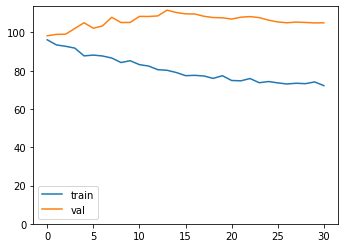

In [24]:
REQ_NAME = 'hair_across_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6773 - accuracy: 0.5947 - precision: 0.7760 - recall: 0.6365 - f1: 0.6955 - specificity: 0.4761 - negative_predictive_value: 0.3208 - matthews_correlation_coefficient: 0.1042 - equal_error_rate: 0.4249 - val_loss: 0.6139 - val_accuracy: 0.5719 - val_precision: 0.7876 - val_recall: 0.5824 - val_f1: 0.6675 - val_specificity: 0.5560 - val_negative_predictive_value: 0.3171 - val_matthews_correlation_coefficient: 0.1202 - val_equal_error_rate: 0.4152

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.12021, saving model to ../../models/siamese_networks/hair_across_eyes_2020_06_21-04_13_33.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6591 - accuracy: 0.5768 - precision: 0.8077 - recall: 0.5624 - f1: 0.6614 - specificity: 0.6198 - negative_predictive_value: 0.3345 - matthews_correlation_coefficient: 0.1607


Epoch 00012: val_matthews_correlation_coefficient improved from 0.37298 to 0.37866, saving model to ../../models/siamese_networks/hair_across_eyes_2020_06_21-04_13_33.h5
Epoch 13/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6064 - accuracy: 0.6529 - precision: 0.8629 - recall: 0.6308 - f1: 0.7275 - specificity: 0.7205 - negative_predictive_value: 0.4089 - matthews_correlation_coefficient: 0.3085 - equal_error_rate: 0.3211 - val_loss: 0.5580 - val_accuracy: 0.6931 - val_precision: 0.8859 - val_recall: 0.6695 - val_f1: 0.7603 - val_specificity: 0.7657 - val_negative_predictive_value: 0.4518 - val_matthews_correlation_coefficient: 0.3828 - val_equal_error_rate: 0.2902

Epoch 00013: val_matthews_correlation_coefficient improved from 0.37866 to 0.38285, saving model to ../../models/siamese_networks/hair_across_eyes_2020_06_21-04_13_33.h5
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6037 - accuracy: 0.6457 - precision: 0.8696 - 

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5956 - accuracy: 0.6691 - precision: 0.8697 - recall: 0.6502 - f1: 0.7424 - specificity: 0.7255 - negative_predictive_value: 0.4236 - matthews_correlation_coefficient: 0.3314 - equal_error_rate: 0.3095 - val_loss: 0.5515 - val_accuracy: 0.7018 - val_precision: 0.8997 - val_recall: 0.6676 - val_f1: 0.7646 - val_specificity: 0.7972 - val_negative_predictive_value: 0.4604 - val_matthews_correlation_coefficient: 0.4085 - val_equal_error_rate: 0.2686

Epoch 00025: val_matthews_correlation_coefficient did not improve from 0.41479
Epoch 26/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.5980 - accuracy: 0.6649 - precision: 0.8779 - recall: 0.6345 - f1: 0.7358 - specificity: 0.7505 - negative_predictive_value: 0.4211 - matthews_correlation_coefficient: 0.3389 - equal_error_rate: 0.3043 - val_loss: 0.5467 - val_accuracy: 0.7071 - val_precision: 0.9006 - val_recall: 0.6742 - val_f1: 0.7693 - val_specifici


Epoch 00037: val_matthews_correlation_coefficient did not improve from 0.43072
Epoch 38/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.5992 - accuracy: 0.6647 - precision: 0.8766 - recall: 0.6359 - f1: 0.7360 - specificity: 0.7496 - negative_predictive_value: 0.4208 - matthews_correlation_coefficient: 0.3380 - equal_error_rate: 0.2997 - val_loss: 0.5446 - val_accuracy: 0.7079 - val_precision: 0.9052 - val_recall: 0.6730 - val_f1: 0.7702 - val_specificity: 0.8075 - val_negative_predictive_value: 0.4672 - val_matthews_correlation_coefficient: 0.4225 - val_equal_error_rate: 0.2652

Epoch 00038: val_matthews_correlation_coefficient did not improve from 0.43072
Epoch 39/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.5922 - accuracy: 0.6756 - precision: 0.8848 - recall: 0.6457 - f1: 0.7453 - specificity: 0.7612 - negative_predictive_value: 0.4327 - matthews_correlation_coefficient: 0.3589 - equal_error_rate: 0.3011 - val_loss: 0.5492 - val_a


Epoch 00050: val_matthews_correlation_coefficient improved from 0.43244 to 0.43982, saving model to ../../models/siamese_networks/hair_across_eyes_2020_06_21-04_13_33.h5
Epoch 51/100
4584/4584 [==============================] - 11s 3ms/step - loss: 0.5931 - accuracy: 0.6806 - precision: 0.8817 - recall: 0.6562 - f1: 0.7512 - specificity: 0.7566 - negative_predictive_value: 0.4381 - matthews_correlation_coefficient: 0.3628 - equal_error_rate: 0.2958 - val_loss: 0.5461 - val_accuracy: 0.7105 - val_precision: 0.9131 - val_recall: 0.6695 - val_f1: 0.7705 - val_specificity: 0.8253 - val_negative_predictive_value: 0.4707 - val_matthews_correlation_coefficient: 0.4353 - val_equal_error_rate: 0.2560

Epoch 00051: val_matthews_correlation_coefficient did not improve from 0.43982
Epoch 52/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.5912 - accuracy: 0.6708 - precision: 0.8777 - recall: 0.6449 - f1: 0.7422 - specificity: 0.7470 - negative_predictive_value: 0.4277 - mat

4584/4584 [==============================] - 11s 2ms/step - loss: 0.5931 - accuracy: 0.6800 - precision: 0.8817 - recall: 0.6561 - f1: 0.7507 - specificity: 0.7516 - negative_predictive_value: 0.4361 - matthews_correlation_coefficient: 0.3594 - equal_error_rate: 0.2943 - val_loss: 0.5446 - val_accuracy: 0.7097 - val_precision: 0.9104 - val_recall: 0.6707 - val_f1: 0.7704 - val_specificity: 0.8200 - val_negative_predictive_value: 0.4699 - val_matthews_correlation_coefficient: 0.4315 - val_equal_error_rate: 0.2582

Epoch 00064: val_matthews_correlation_coefficient did not improve from 0.43982
Epoch 65/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.5868 - accuracy: 0.6776 - precision: 0.8845 - recall: 0.6482 - f1: 0.7470 - specificity: 0.7634 - negative_predictive_value: 0.4344 - matthews_correlation_coefficient: 0.3618 - equal_error_rate: 0.2870 - val_loss: 0.5395 - val_accuracy: 0.7123 - val_precision: 0.9110 - val_recall: 0.6742 - val_f1: 0.7729 - val_specifici

4584/4584 [==============================] - 11s 2ms/step - loss: 0.5867 - accuracy: 0.6767 - precision: 0.8869 - recall: 0.6450 - f1: 0.7459 - specificity: 0.7711 - negative_predictive_value: 0.4339 - matthews_correlation_coefficient: 0.3648 - equal_error_rate: 0.2993 - val_loss: 0.5465 - val_accuracy: 0.7079 - val_precision: 0.9113 - val_recall: 0.6673 - val_f1: 0.7686 - val_specificity: 0.8225 - val_negative_predictive_value: 0.4677 - val_matthews_correlation_coefficient: 0.4303 - val_equal_error_rate: 0.2547

Epoch 00077: val_matthews_correlation_coefficient did not improve from 0.43982
Epoch 78/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.5941 - accuracy: 0.6769 - precision: 0.8830 - recall: 0.6487 - f1: 0.7469 - specificity: 0.7545 - negative_predictive_value: 0.4316 - matthews_correlation_coefficient: 0.3557 - equal_error_rate: 0.2963 - val_loss: 0.5440 - val_accuracy: 0.7097 - val_precision: 0.9115 - val_recall: 0.6695 - val_f1: 0.7700 - val_specifici

4584/4584 [==============================] - 11s 2ms/step - loss: 0.5977 - accuracy: 0.6767 - precision: 0.8759 - recall: 0.6565 - f1: 0.7491 - specificity: 0.7401 - negative_predictive_value: 0.4310 - matthews_correlation_coefficient: 0.3482 - equal_error_rate: 0.2986 - val_loss: 0.5478 - val_accuracy: 0.7088 - val_precision: 0.9129 - val_recall: 0.6677 - val_f1: 0.7694 - val_specificity: 0.8259 - val_negative_predictive_value: 0.4688 - val_matthews_correlation_coefficient: 0.4335 - val_equal_error_rate: 0.2531

Epoch 00090: val_matthews_correlation_coefficient did not improve from 0.43982
Epoch 91/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.5946 - accuracy: 0.6754 - precision: 0.8804 - recall: 0.6484 - f1: 0.7458 - specificity: 0.7559 - negative_predictive_value: 0.4317 - matthews_correlation_coefficient: 0.3549 - equal_error_rate: 0.2976 - val_loss: 0.5475 - val_accuracy: 0.7088 - val_precision: 0.9126 - val_recall: 0.6674 - val_f1: 0.7693 - val_specifici

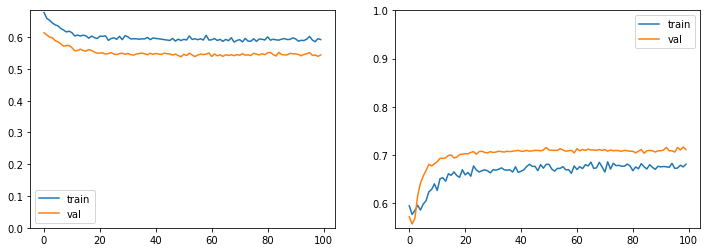

In [25]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 10. Eyes Closed  

123 of 123
77 of 77
(159, 160, 160, 3) float32
(159,) int32
(41, 160, 160, 3) float32
(41,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 58s 583ms/step - loss: 94.0066 - val_loss: 89.7562
Epoch 2/100
100/100 [==============================] - 57s 567ms/step - loss: 87.3633 - val_loss: 85.1717
Epoch 3/100
100/100 [==============================] - 57s 567ms/step - loss: 83.5801 - val_loss: 80.1543
Epoch 4/100
100/100 [==============================] - 57s 567ms/step - loss: 82.2986 - val_loss: 80.0489
Epoch 5/100
100/100 [==============================] - 57s 567ms/step - loss: 77.7684 - val_loss: 81.6759
Epoch 6/100
100/100 [==============================] - 57s 570ms/step - loss: 75.1332 - val_loss: 83.3298
Epoch 7/100
100/100 [==============================] - 57s 567ms/step - loss: 72.8754 - val_loss: 79.9629
Epoch 8/100
100/100 [==============================] - 57s 568ms/step - loss: 70.0759 - val_loss: 82.2302
Epoch 9/100
100/100 [==============================] - 57s 567ms/step - loss: 68.4831 - val_loss: 81.7645
Epoch 10/100
100/100 [========================

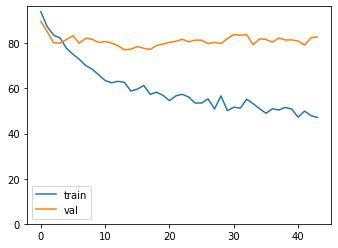

In [26]:
REQ_NAME = 'eyes_closed'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 14s 3ms/step - loss: 0.8426 - accuracy: 0.6246 - precision: 0.7734 - recall: 0.7271 - f1: 0.7406 - specificity: 0.2806 - negative_predictive_value: 0.2278 - matthews_correlation_coefficient: 0.0058 - equal_error_rate: 0.4889 - val_loss: 0.6027 - val_accuracy: 0.7193 - val_precision: 0.7865 - val_recall: 0.8797 - val_f1: 0.8298 - val_specificity: 0.1922 - val_negative_predictive_value: 0.3132 - val_matthews_correlation_coefficient: 0.0844 - val_equal_error_rate: 0.4839

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.08437, saving model to ../../models/siamese_networks/eyes_closed_2020_06_21-05_15_30.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.7646 - accuracy: 0.5164 - precision: 0.7784 - recall: 0.5216 - f1: 0.6234 - specificity: 0.4992 - negative_predictive_value: 0.2369 - matthews_correlation_coefficient: 0.0179 - eq


Epoch 00013: val_matthews_correlation_coefficient improved from 0.14228 to 0.14723, saving model to ../../models/siamese_networks/eyes_closed_2020_06_21-05_15_30.h5
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6960 - accuracy: 0.5467 - precision: 0.7977 - recall: 0.5533 - f1: 0.6514 - specificity: 0.5250 - negative_predictive_value: 0.2569 - matthews_correlation_coefficient: 0.0652 - equal_error_rate: 0.4518 - val_loss: 0.6536 - val_accuracy: 0.5911 - val_precision: 0.8279 - val_recall: 0.6020 - val_f1: 0.6945 - val_specificity: 0.5679 - val_negative_predictive_value: 0.2960 - val_matthews_correlation_coefficient: 0.1450 - val_equal_error_rate: 0.4009

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.14723
Epoch 15/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6858 - accuracy: 0.5545 - precision: 0.8189 - recall: 0.5453 - f1: 0.6519 - specificity: 0.5906 - negative_predictive_value: 0.2769 - matthews


Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.15578
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6775 - accuracy: 0.5484 - precision: 0.8189 - recall: 0.5323 - f1: 0.6410 - specificity: 0.6035 - negative_predictive_value: 0.2784 - matthews_correlation_coefficient: 0.1146 - equal_error_rate: 0.4245 - val_loss: 0.6707 - val_accuracy: 0.5737 - val_precision: 0.8267 - val_recall: 0.5762 - val_f1: 0.6767 - val_specificity: 0.5826 - val_negative_predictive_value: 0.2881 - val_matthews_correlation_coefficient: 0.1350 - val_equal_error_rate: 0.4060

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.15578
Epoch 28/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6817 - accuracy: 0.5449 - precision: 0.8189 - recall: 0.5298 - f1: 0.6400 - specificity: 0.5936 - negative_predictive_value: 0.2725 - matthews_correlation_coefficient: 0.1060 - equal_error_rate: 0.4374 - val_loss: 0.6791 - val_a

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6733 - accuracy: 0.5458 - precision: 0.8383 - recall: 0.5128 - f1: 0.6344 - specificity: 0.6642 - negative_predictive_value: 0.2861 - matthews_correlation_coefficient: 0.1480 - equal_error_rate: 0.4181 - val_loss: 0.6716 - val_accuracy: 0.5728 - val_precision: 0.8287 - val_recall: 0.5719 - val_f1: 0.6742 - val_specificity: 0.5883 - val_negative_predictive_value: 0.2877 - val_matthews_correlation_coefficient: 0.1365 - val_equal_error_rate: 0.4027

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.15578
Epoch 41/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6749 - accuracy: 0.5441 - precision: 0.8282 - recall: 0.5178 - f1: 0.6349 - specificity: 0.6348 - negative_predictive_value: 0.2789 - matthews_correlation_coefficient: 0.1275 - equal_error_rate: 0.4243 - val_loss: 0.6787 - val_accuracy: 0.5606 - val_precision: 0.8332 - val_recall: 0.5490 - val_f1: 0.6599 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6761 - accuracy: 0.5388 - precision: 0.8373 - recall: 0.5045 - f1: 0.6261 - specificity: 0.6672 - negative_predictive_value: 0.2819 - matthews_correlation_coefficient: 0.1426 - equal_error_rate: 0.4171 - val_loss: 0.6769 - val_accuracy: 0.5597 - val_precision: 0.8307 - val_recall: 0.5494 - val_f1: 0.6588 - val_specificity: 0.6117 - val_negative_predictive_value: 0.2858 - val_matthews_correlation_coefficient: 0.1370 - val_equal_error_rate: 0.4079

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.15578
Epoch 54/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6769 - accuracy: 0.5462 - precision: 0.8199 - recall: 0.5303 - f1: 0.6415 - specificity: 0.6072 - negative_predictive_value: 0.2758 - matthews_correlation_coefficient: 0.1146 - equal_error_rate: 0.4265 - val_loss: 0.6795 - val_accuracy: 0.5562 - val_precision: 0.8305 - val_recall: 0.5429 - val_f1: 0.6542 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6780 - accuracy: 0.5268 - precision: 0.8329 - recall: 0.4850 - f1: 0.6102 - specificity: 0.6730 - negative_predictive_value: 0.2796 - matthews_correlation_coefficient: 0.1331 - equal_error_rate: 0.4105 - val_loss: 0.6855 - val_accuracy: 0.5527 - val_precision: 0.8277 - val_recall: 0.5396 - val_f1: 0.6512 - val_specificity: 0.6109 - val_negative_predictive_value: 0.2810 - val_matthews_correlation_coefficient: 0.1278 - val_equal_error_rate: 0.4052

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.15578
Epoch 67/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6743 - accuracy: 0.5414 - precision: 0.8312 - recall: 0.5106 - f1: 0.6301 - specificity: 0.6449 - negative_predictive_value: 0.2833 - matthews_correlation_coefficient: 0.1333 - equal_error_rate: 0.4213 - val_loss: 0.6788 - val_accuracy: 0.5545 - val_precision: 0.8325 - val_recall: 0.5397 - val_f1: 0.6524 - val_specifici

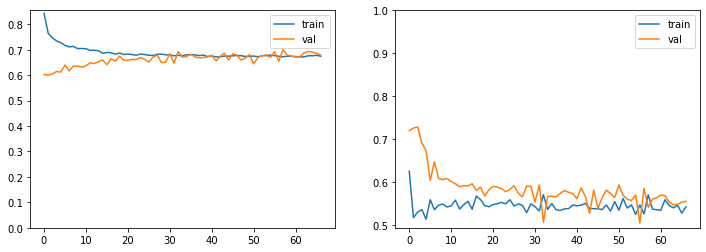

In [27]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 11. Varied Background

130 of 130
150 of 150
(224, 160, 160, 3) float32
(224,) int32
(56, 160, 160, 3) float32
(56,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 64s 637ms/step - loss: 90.6353 - val_loss: 74.2225
Epoch 2/100
100/100 [==============================] - 63s 632ms/step - loss: 76.7901 - val_loss: 62.1260
Epoch 3/100
100/100 [==============================] - 64s 637ms/step - loss: 70.7814 - val_loss: 55.0705
Epoch 4/100
100/100 [==============================] - 64s 637ms/step - loss: 66.4199 - val_loss: 57.1447
Epoch 5/100
100/100 [==============================] - 63s 634ms/step - loss: 58.1317 - val_loss: 58.9692
Epoch 6/100
100/100 [==============================] - 64s 639ms/step - loss: 54.7905 - val_loss: 56.7701
Epoch 7/100
100/100 [==============================] - 63s 629ms/step - loss: 51.4472 - val_loss: 55.9161
Epoch 8/100
100/100 [==============================] - 63s 632ms/step - loss: 48.2599 - val_loss: 52.3706
Epoch 9/100
100/100 [==============================] - 64s 636ms/step - loss: 47.1770 - val_loss: 53.3938
Epoch 10/100
100/100 [========================

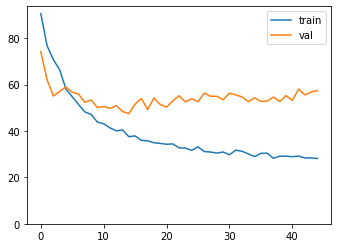

In [28]:
REQ_NAME = 'varied_background'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6815 - accuracy: 0.6012 - precision: 0.6567 - recall: 0.6150 - f1: 0.6323 - specificity: 0.5849 - negative_predictive_value: 0.5398 - matthews_correlation_coefficient: 0.1981 - equal_error_rate: 0.3940 - val_loss: 0.6110 - val_accuracy: 0.6085 - val_precision: 0.7804 - val_recall: 0.4067 - val_f1: 0.5335 - val_specificity: 0.8585 - val_negative_predictive_value: 0.5321 - val_matthews_correlation_coefficient: 0.2875 - val_equal_error_rate: 0.3605

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28747, saving model to ../../models/siamese_networks/varied_background_2020_06_21-06_17_28.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6473 - accuracy: 0.6204 - precision: 0.6858 - recall: 0.6026 - f1: 0.6393 - specificity: 0.6424 - negative_predictive_value: 0.5559 - matthews_correlation_coefficient: 0.243

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5762 - accuracy: 0.6579 - precision: 0.7257 - recall: 0.6367 - f1: 0.6753 - specificity: 0.6881 - negative_predictive_value: 0.5948 - matthews_correlation_coefficient: 0.3226 - equal_error_rate: 0.3320 - val_loss: 0.5600 - val_accuracy: 0.6582 - val_precision: 0.7745 - val_recall: 0.5471 - val_f1: 0.6384 - val_specificity: 0.8006 - val_negative_predictive_value: 0.5840 - val_matthews_correlation_coefficient: 0.3526 - val_equal_error_rate: 0.3224

Epoch 00013: val_matthews_correlation_coefficient improved from 0.34849 to 0.35259, saving model to ../../models/siamese_networks/varied_background_2020_06_21-06_17_28.h5
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5735 - accuracy: 0.6717 - precision: 0.7360 - recall: 0.6559 - f1: 0.6911 - specificity: 0.6933 - negative_predictive_value: 0.6088 - matthews_correlation_coefficient: 0.3469 - equal_error_rate: 0.3238 - val_loss: 0.5613 - val_ac


Epoch 00025: val_matthews_correlation_coefficient did not improve from 0.36966
Epoch 26/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5536 - accuracy: 0.6769 - precision: 0.7363 - recall: 0.6692 - f1: 0.6980 - specificity: 0.6891 - negative_predictive_value: 0.6171 - matthews_correlation_coefficient: 0.3558 - equal_error_rate: 0.3140 - val_loss: 0.5555 - val_accuracy: 0.6574 - val_precision: 0.7796 - val_recall: 0.5403 - val_f1: 0.6354 - val_specificity: 0.8084 - val_negative_predictive_value: 0.5818 - val_matthews_correlation_coefficient: 0.3545 - val_equal_error_rate: 0.3274

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.36966
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5581 - accuracy: 0.6671 - precision: 0.7305 - recall: 0.6457 - f1: 0.6830 - specificity: 0.6934 - negative_predictive_value: 0.6037 - matthews_correlation_coefficient: 0.3366 - equal_error_rate: 0.3281 - val_loss: 0.5491 - val_a

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5604 - accuracy: 0.6712 - precision: 0.7405 - recall: 0.6475 - f1: 0.6879 - specificity: 0.7037 - negative_predictive_value: 0.6056 - matthews_correlation_coefficient: 0.3486 - equal_error_rate: 0.3219 - val_loss: 0.5442 - val_accuracy: 0.6731 - val_precision: 0.7630 - val_recall: 0.6002 - val_f1: 0.6693 - val_specificity: 0.7671 - val_negative_predictive_value: 0.6034 - val_matthews_correlation_coefficient: 0.3666 - val_equal_error_rate: 0.3186

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.37383
Epoch 40/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5553 - accuracy: 0.6739 - precision: 0.7321 - recall: 0.6652 - f1: 0.6952 - specificity: 0.6848 - negative_predictive_value: 0.6122 - matthews_correlation_coefficient: 0.3471 - equal_error_rate: 0.3213 - val_loss: 0.5520 - val_accuracy: 0.6678 - val_precision: 0.7828 - val_recall: 0.5628 - val_f1: 0.6518 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5472 - accuracy: 0.6839 - precision: 0.7493 - recall: 0.6618 - f1: 0.7008 - specificity: 0.7144 - negative_predictive_value: 0.6185 - matthews_correlation_coefficient: 0.3719 - equal_error_rate: 0.3120 - val_loss: 0.5414 - val_accuracy: 0.6731 - val_precision: 0.7597 - val_recall: 0.6060 - val_f1: 0.6721 - val_specificity: 0.7596 - val_negative_predictive_value: 0.6039 - val_matthews_correlation_coefficient: 0.3644 - val_equal_error_rate: 0.3136

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.37383
Epoch 53/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5565 - accuracy: 0.6800 - precision: 0.7412 - recall: 0.6657 - f1: 0.6991 - specificity: 0.7000 - negative_predictive_value: 0.6186 - matthews_correlation_coefficient: 0.3627 - equal_error_rate: 0.3208 - val_loss: 0.5430 - val_accuracy: 0.6722 - val_precision: 0.7630 - val_recall: 0.5949 - val_f1: 0.6658 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5533 - accuracy: 0.6739 - precision: 0.7345 - recall: 0.6609 - f1: 0.6928 - specificity: 0.6913 - negative_predictive_value: 0.6120 - matthews_correlation_coefficient: 0.3493 - equal_error_rate: 0.3230 - val_loss: 0.5426 - val_accuracy: 0.6731 - val_precision: 0.7646 - val_recall: 0.5947 - val_f1: 0.6664 - val_specificity: 0.7704 - val_negative_predictive_value: 0.6012 - val_matthews_correlation_coefficient: 0.3652 - val_equal_error_rate: 0.3151

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.38530
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5563 - accuracy: 0.6671 - precision: 0.7299 - recall: 0.6530 - f1: 0.6874 - specificity: 0.6875 - negative_predictive_value: 0.6034 - matthews_correlation_coefficient: 0.3368 - equal_error_rate: 0.3293 - val_loss: 0.5450 - val_accuracy: 0.6783 - val_precision: 0.7751 - val_recall: 0.5915 - val_f1: 0.6685 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5515 - accuracy: 0.6832 - precision: 0.7373 - recall: 0.6811 - f1: 0.7051 - specificity: 0.6854 - negative_predictive_value: 0.6268 - matthews_correlation_coefficient: 0.3653 - equal_error_rate: 0.3130 - val_loss: 0.5436 - val_accuracy: 0.6792 - val_precision: 0.7759 - val_recall: 0.5928 - val_f1: 0.6695 - val_specificity: 0.7855 - val_negative_predictive_value: 0.6050 - val_matthews_correlation_coefficient: 0.3793 - val_equal_error_rate: 0.3176

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.38530
Epoch 79/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5546 - accuracy: 0.6743 - precision: 0.7385 - recall: 0.6539 - f1: 0.6914 - specificity: 0.7004 - negative_predictive_value: 0.6108 - matthews_correlation_coefficient: 0.3517 - equal_error_rate: 0.3214 - val_loss: 0.5379 - val_accuracy: 0.6792 - val_precision: 0.7512 - val_recall: 0.6351 - val_f1: 0.6863 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5553 - accuracy: 0.6826 - precision: 0.7340 - recall: 0.6879 - f1: 0.7074 - specificity: 0.6793 - negative_predictive_value: 0.6263 - matthews_correlation_coefficient: 0.3637 - equal_error_rate: 0.3169 - val_loss: 0.5407 - val_accuracy: 0.6818 - val_precision: 0.7657 - val_recall: 0.6237 - val_f1: 0.6848 - val_specificity: 0.7587 - val_negative_predictive_value: 0.6146 - val_matthews_correlation_coefficient: 0.3812 - val_equal_error_rate: 0.3172

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.38530
Epoch 92/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5542 - accuracy: 0.6889 - precision: 0.7494 - recall: 0.6710 - f1: 0.7061 - specificity: 0.7110 - negative_predictive_value: 0.6264 - matthews_correlation_coefficient: 0.3788 - equal_error_rate: 0.3053 - val_loss: 0.5415 - val_accuracy: 0.6818 - val_precision: 0.7633 - val_recall: 0.6238 - val_f1: 0.6840 - val_specifici

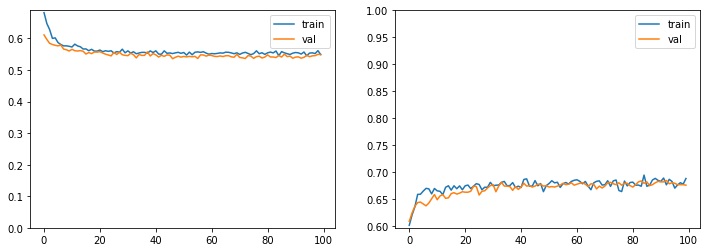

In [29]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 12. Roll/pitch/yaw

150 of 150
141 of 141
(232, 160, 160, 3) float32
(232,) int32
(59, 160, 160, 3) float32
(59,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 74s 739ms/step - loss: 99.2302 - val_loss: 92.7645
Epoch 2/100
100/100 [==============================] - 71s 712ms/step - loss: 98.5701 - val_loss: 93.0957
Epoch 3/100
100/100 [==============================] - 72s 715ms/step - loss: 97.5795 - val_loss: 91.2147
Epoch 4/100
100/100 [==============================] - 71s 706ms/step - loss: 97.1106 - val_loss: 91.0902
Epoch 5/100
100/100 [==============================] - 71s 712ms/step - loss: 96.6156 - val_loss: 89.8568
Epoch 6/100
100/100 [==============================] - 71s 715ms/step - loss: 95.9324 - val_loss: 90.9094
Epoch 7/100
100/100 [==============================] - 71s 707ms/step - loss: 96.1702 - val_loss: 89.7114
Epoch 8/100
100/100 [==============================] - 71s 714ms/step - loss: 95.6617 - val_loss: 87.8854
Epoch 9/100
100/100 [==============================] - 73s 735ms/step - loss: 95.1133 - val_loss: 86.6424
Epoch 10/100
100/100 [========================

100/100 [==============================] - 71s 711ms/step - loss: 83.0347 - val_loss: 81.6745
Epoch 78/100
100/100 [==============================] - 71s 715ms/step - loss: 82.1660 - val_loss: 80.5651
Epoch 79/100
100/100 [==============================] - 71s 707ms/step - loss: 81.9147 - val_loss: 80.4054
Epoch 80/100
100/100 [==============================] - 71s 712ms/step - loss: 80.4480 - val_loss: 79.8969
Epoch 81/100
100/100 [==============================] - 72s 716ms/step - loss: 83.0706 - val_loss: 82.2428
Epoch 82/100
100/100 [==============================] - 71s 707ms/step - loss: 82.3515 - val_loss: 80.7112
Epoch 83/100
100/100 [==============================] - 71s 713ms/step - loss: 81.3745 - val_loss: 79.0767
Epoch 84/100
100/100 [==============================] - 72s 719ms/step - loss: 80.3711 - val_loss: 80.5134
Epoch 85/100
100/100 [==============================] - 71s 706ms/step - loss: 82.4933 - val_loss: 79.1305
Epoch 86/100
100/100 [============================

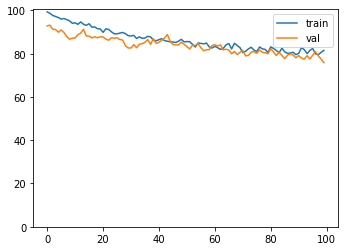

In [30]:
REQ_NAME = 'roll_pitch_yaw'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 15s 3ms/step - loss: 0.7856 - accuracy: 0.5979 - precision: 0.7725 - recall: 0.6610 - f1: 0.7019 - specificity: 0.4030 - negative_predictive_value: 0.2886 - matthews_correlation_coefficient: 0.0612 - equal_error_rate: 0.4556 - val_loss: 0.6478 - val_accuracy: 0.6539 - val_precision: 0.7670 - val_recall: 0.7892 - val_f1: 0.7772 - val_specificity: 0.2618 - val_negative_predictive_value: 0.2774 - val_matthews_correlation_coefficient: 0.0475 - val_equal_error_rate: 0.4553

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.04750, saving model to ../../models/siamese_networks/roll_pitch_yaw_2020_06_21-08_37_17.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.7359 - accuracy: 0.5467 - precision: 0.7876 - recall: 0.5425 - f1: 0.6404 - specificity: 0.5578 - negative_predictive_value: 0.2865 - matthews_correlation_coefficient: 0.0860 -

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6645 - accuracy: 0.5879 - precision: 0.8305 - recall: 0.5725 - f1: 0.6743 - specificity: 0.6482 - negative_predictive_value: 0.3318 - matthews_correlation_coefficient: 0.1888 - equal_error_rate: 0.3934 - val_loss: 0.6303 - val_accuracy: 0.6321 - val_precision: 0.9090 - val_recall: 0.5747 - val_f1: 0.7028 - val_specificity: 0.8280 - val_negative_predictive_value: 0.3878 - val_matthews_correlation_coefficient: 0.3455 - val_equal_error_rate: 0.3326

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.34699
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6676 - accuracy: 0.5733 - precision: 0.8229 - recall: 0.5549 - f1: 0.6597 - specificity: 0.6394 - negative_predictive_value: 0.3204 - matthews_correlation_coefficient: 0.1664 - equal_error_rate: 0.3933 - val_loss: 0.6213 - val_accuracy: 0.6504 - val_precision: 0.8843 - val_recall: 0.6236 - val_f1: 0.7293 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6492 - accuracy: 0.5921 - precision: 0.8395 - recall: 0.5686 - f1: 0.6765 - specificity: 0.6658 - negative_predictive_value: 0.3377 - matthews_correlation_coefficient: 0.2034 - equal_error_rate: 0.3796 - val_loss: 0.6268 - val_accuracy: 0.6347 - val_precision: 0.9248 - val_recall: 0.5663 - val_f1: 0.7006 - val_specificity: 0.8583 - val_negative_predictive_value: 0.3923 - val_matthews_correlation_coefficient: 0.3666 - val_equal_error_rate: 0.3145

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.37425
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6492 - accuracy: 0.6034 - precision: 0.8404 - recall: 0.5877 - f1: 0.6889 - specificity: 0.6567 - negative_predictive_value: 0.3435 - matthews_correlation_coefficient: 0.2117 - equal_error_rate: 0.3728 - val_loss: 0.6339 - val_accuracy: 0.6225 - val_precision: 0.9348 - val_recall: 0.5443 - val_f1: 0.6858 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6501 - accuracy: 0.6021 - precision: 0.8468 - recall: 0.5762 - f1: 0.6837 - specificity: 0.6837 - negative_predictive_value: 0.3475 - matthews_correlation_coefficient: 0.2243 - equal_error_rate: 0.3730 - val_loss: 0.6117 - val_accuracy: 0.6530 - val_precision: 0.8931 - val_recall: 0.6193 - val_f1: 0.7299 - val_specificity: 0.7785 - val_negative_predictive_value: 0.4003 - val_matthews_correlation_coefficient: 0.3414 - val_equal_error_rate: 0.3137

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.38230
Epoch 40/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6479 - accuracy: 0.6156 - precision: 0.8332 - recall: 0.6128 - f1: 0.7039 - specificity: 0.6246 - negative_predictive_value: 0.3487 - matthews_correlation_coefficient: 0.2074 - equal_error_rate: 0.3756 - val_loss: 0.6257 - val_accuracy: 0.6373 - val_precision: 0.9274 - val_recall: 0.5699 - val_f1: 0.7038 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6478 - accuracy: 0.5979 - precision: 0.8415 - recall: 0.5762 - f1: 0.6821 - specificity: 0.6679 - negative_predictive_value: 0.3409 - matthews_correlation_coefficient: 0.2104 - equal_error_rate: 0.3746 - val_loss: 0.6227 - val_accuracy: 0.6399 - val_precision: 0.9223 - val_recall: 0.5764 - val_f1: 0.7079 - val_specificity: 0.8533 - val_negative_predictive_value: 0.3964 - val_matthews_correlation_coefficient: 0.3698 - val_equal_error_rate: 0.3111

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.38230
Epoch 53/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6472 - accuracy: 0.6069 - precision: 0.8429 - recall: 0.5893 - f1: 0.6903 - specificity: 0.6721 - negative_predictive_value: 0.3488 - matthews_correlation_coefficient: 0.2232 - equal_error_rate: 0.3690 - val_loss: 0.6382 - val_accuracy: 0.6164 - val_precision: 0.9343 - val_recall: 0.5355 - val_f1: 0.6782 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6436 - accuracy: 0.6195 - precision: 0.8456 - recall: 0.6067 - f1: 0.7035 - specificity: 0.6625 - negative_predictive_value: 0.3558 - matthews_correlation_coefficient: 0.2323 - equal_error_rate: 0.3618 - val_loss: 0.6510 - val_accuracy: 0.5998 - val_precision: 0.9373 - val_recall: 0.5108 - val_f1: 0.6585 - val_specificity: 0.8952 - val_negative_predictive_value: 0.3733 - val_matthews_correlation_coefficient: 0.3548 - val_equal_error_rate: 0.3180

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.38230
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6511 - accuracy: 0.5903 - precision: 0.8375 - recall: 0.5676 - f1: 0.6730 - specificity: 0.6632 - negative_predictive_value: 0.3377 - matthews_correlation_coefficient: 0.2008 - equal_error_rate: 0.3790 - val_loss: 0.6523 - val_accuracy: 0.5911 - val_precision: 0.9367 - val_recall: 0.4985 - val_f1: 0.6484 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6450 - accuracy: 0.6058 - precision: 0.8498 - recall: 0.5821 - f1: 0.6890 - specificity: 0.6850 - negative_predictive_value: 0.3501 - matthews_correlation_coefficient: 0.2307 - equal_error_rate: 0.3624 - val_loss: 0.6196 - val_accuracy: 0.6486 - val_precision: 0.9257 - val_recall: 0.5872 - val_f1: 0.7167 - val_specificity: 0.8567 - val_negative_predictive_value: 0.4041 - val_matthews_correlation_coefficient: 0.3824 - val_equal_error_rate: 0.3150

Epoch 00078: val_matthews_correlation_coefficient improved from 0.38230 to 0.38235, saving model to ../../models/siamese_networks/roll_pitch_yaw_2020_06_21-08_37_17.h5
Epoch 79/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6461 - accuracy: 0.6056 - precision: 0.8449 - recall: 0.5844 - f1: 0.6888 - specificity: 0.6727 - negative_predictive_value: 0.3476 - matthews_correlation_coefficient: 0.2221 - equal_error_rate: 0.3736 - val_loss: 0.6037 - val_accur

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6453 - accuracy: 0.5971 - precision: 0.8412 - recall: 0.5753 - f1: 0.6814 - specificity: 0.6678 - negative_predictive_value: 0.3404 - matthews_correlation_coefficient: 0.2097 - equal_error_rate: 0.3673 - val_loss: 0.6162 - val_accuracy: 0.6460 - val_precision: 0.9230 - val_recall: 0.5839 - val_f1: 0.7132 - val_specificity: 0.8480 - val_negative_predictive_value: 0.3992 - val_matthews_correlation_coefficient: 0.3728 - val_equal_error_rate: 0.3139

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.38235
Epoch 92/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6495 - accuracy: 0.6043 - precision: 0.8426 - recall: 0.5860 - f1: 0.6893 - specificity: 0.6628 - negative_predictive_value: 0.3448 - matthews_correlation_coefficient: 0.2155 - equal_error_rate: 0.3703 - val_loss: 0.6133 - val_accuracy: 0.6495 - val_precision: 0.9183 - val_recall: 0.5916 - val_f1: 0.7179 - val_specifici

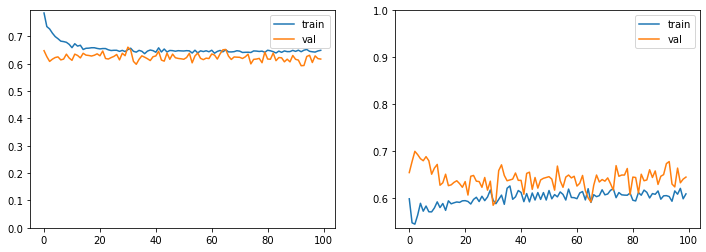

In [31]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 13. Flash Reflection on Skin

84 of 84
70 of 70
(123, 160, 160, 3) float32
(123,) int32
(31, 160, 160, 3) float32
(31,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 58s 582ms/step - loss: 92.1512 - val_loss: 80.4776
Epoch 2/100
100/100 [==============================] - 56s 562ms/step - loss: 80.3403 - val_loss: 87.5598
Epoch 3/100
100/100 [==============================] - 56s 562ms/step - loss: 75.3634 - val_loss: 94.5613
Epoch 4/100
100/100 [==============================] - 56s 562ms/step - loss: 69.7203 - val_loss: 91.7558
Epoch 5/100
100/100 [==============================] - 56s 561ms/step - loss: 65.8088 - val_loss: 93.1464
Epoch 6/100
100/100 [==============================] - 56s 561ms/step - loss: 59.2081 - val_loss: 92.9231
Epoch 7/100
100/100 [==============================] - 56s 561ms/step - loss: 57.4684 - val_loss: 93.5380
Epoch 8/100
100/100 [==============================] - 57s 570ms/step - loss: 56.3819 - val_loss: 89.6115
Epoch 9/100
100/100 [==============================] - 56s 561ms/step - loss: 53.1824 - val_loss: 84.7877
Epoch 10/100
100/100 [========================

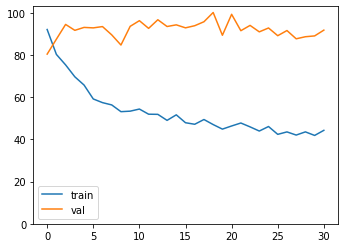

In [32]:
REQ_NAME = 'flash_reflection_on_skin'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 15s 3ms/step - loss: 0.6966 - accuracy: 0.5596 - precision: 0.5862 - recall: 0.6827 - f1: 0.6263 - specificity: 0.4066 - negative_predictive_value: 0.5073 - matthews_correlation_coefficient: 0.0914 - equal_error_rate: 0.4470 - val_loss: 0.6364 - val_accuracy: 0.6303 - val_precision: 0.6666 - val_recall: 0.6339 - val_f1: 0.6476 - val_specificity: 0.6177 - val_negative_predictive_value: 0.5837 - val_matthews_correlation_coefficient: 0.2509 - val_equal_error_rate: 0.3801

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25095, saving model to ../../models/siamese_networks/flash_reflection_on_skin_2020_06_21-09_28_01.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6784 - accuracy: 0.5676 - precision: 0.6139 - recall: 0.5769 - f1: 0.5922 - specificity: 0.5600 - negative_predictive_value: 0.5213 - matthews_correlation_coefficient

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6493 - accuracy: 0.5969 - precision: 0.6608 - recall: 0.5489 - f1: 0.5959 - specificity: 0.6571 - negative_predictive_value: 0.5463 - matthews_correlation_coefficient: 0.2065 - equal_error_rate: 0.3963 - val_loss: 0.6154 - val_accuracy: 0.6234 - val_precision: 0.7118 - val_recall: 0.5307 - val_f1: 0.6046 - val_specificity: 0.7385 - val_negative_predictive_value: 0.5676 - val_matthews_correlation_coefficient: 0.2742 - val_equal_error_rate: 0.3523

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.29921
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6493 - accuracy: 0.5925 - precision: 0.6580 - recall: 0.5439 - f1: 0.5913 - specificity: 0.6560 - negative_predictive_value: 0.5433 - matthews_correlation_coefficient: 0.2005 - equal_error_rate: 0.4013 - val_loss: 0.6138 - val_accuracy: 0.6338 - val_precision: 0.7137 - val_recall: 0.5599 - val_f1: 0.6250 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6384 - accuracy: 0.6143 - precision: 0.7027 - recall: 0.5108 - f1: 0.5893 - specificity: 0.7384 - negative_predictive_value: 0.5547 - matthews_correlation_coefficient: 0.2532 - equal_error_rate: 0.3895 - val_loss: 0.6081 - val_accuracy: 0.6382 - val_precision: 0.7207 - val_recall: 0.5616 - val_f1: 0.6288 - val_specificity: 0.7377 - val_negative_predictive_value: 0.5841 - val_matthews_correlation_coefficient: 0.3020 - val_equal_error_rate: 0.3348

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.30576
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6401 - accuracy: 0.6012 - precision: 0.6762 - recall: 0.5197 - f1: 0.5845 - specificity: 0.7026 - negative_predictive_value: 0.5477 - matthews_correlation_coefficient: 0.2231 - equal_error_rate: 0.3939 - val_loss: 0.6074 - val_accuracy: 0.6408 - val_precision: 0.7240 - val_recall: 0.5633 - val_f1: 0.6308 - val_specifici


Epoch 00038: val_matthews_correlation_coefficient did not improve from 0.31787
Epoch 39/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6376 - accuracy: 0.6095 - precision: 0.6859 - recall: 0.5270 - f1: 0.5927 - specificity: 0.7104 - negative_predictive_value: 0.5549 - matthews_correlation_coefficient: 0.2390 - equal_error_rate: 0.3816 - val_loss: 0.6048 - val_accuracy: 0.6443 - val_precision: 0.7259 - val_recall: 0.5715 - val_f1: 0.6365 - val_specificity: 0.7398 - val_negative_predictive_value: 0.5902 - val_matthews_correlation_coefficient: 0.3136 - val_equal_error_rate: 0.3367

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.31787
Epoch 40/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6399 - accuracy: 0.6054 - precision: 0.6827 - recall: 0.5284 - f1: 0.5919 - specificity: 0.7033 - negative_predictive_value: 0.5526 - matthews_correlation_coefficient: 0.2334 - equal_error_rate: 0.3906 - val_loss: 0.6053 - val_a

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6378 - accuracy: 0.6069 - precision: 0.6836 - recall: 0.5213 - f1: 0.5893 - specificity: 0.7093 - negative_predictive_value: 0.5517 - matthews_correlation_coefficient: 0.2329 - equal_error_rate: 0.3821 - val_loss: 0.6052 - val_accuracy: 0.6373 - val_precision: 0.7412 - val_recall: 0.5235 - val_f1: 0.6105 - val_specificity: 0.7789 - val_negative_predictive_value: 0.5765 - val_matthews_correlation_coefficient: 0.3098 - val_equal_error_rate: 0.3360

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.31787
Epoch 53/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6357 - accuracy: 0.5999 - precision: 0.6889 - recall: 0.4908 - f1: 0.5702 - specificity: 0.7299 - negative_predictive_value: 0.5426 - matthews_correlation_coefficient: 0.2259 - equal_error_rate: 0.3818 - val_loss: 0.6039 - val_accuracy: 0.6391 - val_precision: 0.7269 - val_recall: 0.5544 - val_f1: 0.6259 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6283 - accuracy: 0.6320 - precision: 0.7092 - recall: 0.5536 - f1: 0.6189 - specificity: 0.7290 - negative_predictive_value: 0.5762 - matthews_correlation_coefficient: 0.2839 - equal_error_rate: 0.3612 - val_loss: 0.6028 - val_accuracy: 0.6399 - val_precision: 0.7482 - val_recall: 0.5216 - val_f1: 0.6120 - val_specificity: 0.7880 - val_negative_predictive_value: 0.5782 - val_matthews_correlation_coefficient: 0.3178 - val_equal_error_rate: 0.3286

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.31985
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6322 - accuracy: 0.6204 - precision: 0.7006 - recall: 0.5432 - f1: 0.6086 - specificity: 0.7158 - negative_predictive_value: 0.5631 - matthews_correlation_coefficient: 0.2612 - equal_error_rate: 0.3736 - val_loss: 0.6019 - val_accuracy: 0.6452 - val_precision: 0.7408 - val_recall: 0.5528 - val_f1: 0.6301 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6366 - accuracy: 0.6206 - precision: 0.7039 - recall: 0.5366 - f1: 0.6061 - specificity: 0.7228 - negative_predictive_value: 0.5620 - matthews_correlation_coefficient: 0.2625 - equal_error_rate: 0.3783 - val_loss: 0.6027 - val_accuracy: 0.6356 - val_precision: 0.7488 - val_recall: 0.5058 - val_f1: 0.6015 - val_specificity: 0.7956 - val_negative_predictive_value: 0.5725 - val_matthews_correlation_coefficient: 0.3111 - val_equal_error_rate: 0.3226

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.33139
Epoch 79/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6391 - accuracy: 0.6084 - precision: 0.6871 - recall: 0.5258 - f1: 0.5914 - specificity: 0.7086 - negative_predictive_value: 0.5532 - matthews_correlation_coefficient: 0.2372 - equal_error_rate: 0.3812 - val_loss: 0.6038 - val_accuracy: 0.6303 - val_precision: 0.7524 - val_recall: 0.4858 - val_f1: 0.5881 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6328 - accuracy: 0.6176 - precision: 0.6917 - recall: 0.5491 - f1: 0.6089 - specificity: 0.7021 - negative_predictive_value: 0.5632 - matthews_correlation_coefficient: 0.2530 - equal_error_rate: 0.3761 - val_loss: 0.6017 - val_accuracy: 0.6312 - val_precision: 0.7463 - val_recall: 0.5002 - val_f1: 0.5961 - val_specificity: 0.7939 - val_negative_predictive_value: 0.5691 - val_matthews_correlation_coefficient: 0.3044 - val_equal_error_rate: 0.3227

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.33139
Epoch 92/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6365 - accuracy: 0.6126 - precision: 0.6976 - recall: 0.5198 - f1: 0.5929 - specificity: 0.7258 - negative_predictive_value: 0.5552 - matthews_correlation_coefficient: 0.2491 - equal_error_rate: 0.3823 - val_loss: 0.6029 - val_accuracy: 0.6269 - val_precision: 0.7558 - val_recall: 0.4754 - val_f1: 0.5810 - val_specifici

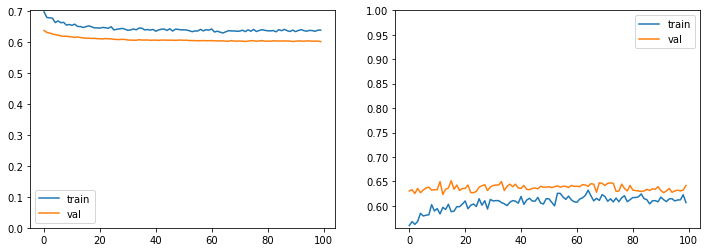

In [33]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 14. Red Eyes 

78 of 78
39 of 39
(93, 160, 160, 3) float32
(93,) int32
(24, 160, 160, 3) float32
(24,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 57s 567ms/step - loss: 94.8962 - val_loss: 91.3492
Epoch 2/100
100/100 [==============================] - 54s 540ms/step - loss: 87.4533 - val_loss: 76.9129
Epoch 3/100
100/100 [==============================] - 54s 540ms/step - loss: 79.7742 - val_loss: 72.0041
Epoch 4/100
100/100 [==============================] - 54s 541ms/step - loss: 75.6871 - val_loss: 77.8731
Epoch 5/100
100/100 [==============================] - 54s 541ms/step - loss: 72.9427 - val_loss: 74.8630
Epoch 6/100
100/100 [==============================] - 54s 540ms/step - loss: 70.0236 - val_loss: 77.6099
Epoch 7/100
100/100 [==============================] - 54s 541ms/step - loss: 66.6956 - val_loss: 77.9707
Epoch 8/100
100/100 [==============================] - 54s 539ms/step - loss: 62.2214 - val_loss: 76.1639
Epoch 9/100
100/100 [==============================] - 54s 540ms/step - loss: 60.3909 - val_loss: 76.6621
Epoch 10/100
100/100 [========================

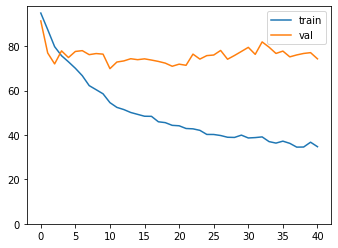

In [34]:
REQ_NAME = 'red_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 14s 3ms/step - loss: 0.7597 - accuracy: 0.5473 - precision: 0.8129 - recall: 0.5557 - f1: 0.6576 - specificity: 0.5192 - negative_predictive_value: 0.2371 - matthews_correlation_coefficient: 0.0611 - equal_error_rate: 0.4582 - val_loss: 0.7376 - val_accuracy: 0.5623 - val_precision: 0.8612 - val_recall: 0.5337 - val_f1: 0.6576 - val_specificity: 0.6694 - val_negative_predictive_value: 0.2774 - val_matthews_correlation_coefficient: 0.1676 - val_equal_error_rate: 0.4148

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.16763, saving model to ../../models/siamese_networks/red_eyes_2020_06_21-10_26_45.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.7269 - accuracy: 0.5558 - precision: 0.8174 - recall: 0.5608 - f1: 0.6631 - specificity: 0.5320 - negative_predictive_value: 0.2453 - matthews_correlation_coefficient: 0.0760 - equal

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6692 - accuracy: 0.5593 - precision: 0.8449 - recall: 0.5403 - f1: 0.6564 - specificity: 0.6324 - negative_predictive_value: 0.2711 - matthews_correlation_coefficient: 0.1411 - equal_error_rate: 0.4146 - val_loss: 0.6926 - val_accuracy: 0.4830 - val_precision: 0.9347 - val_recall: 0.3673 - val_f1: 0.5263 - val_specificity: 0.9036 - val_negative_predictive_value: 0.2767 - val_matthews_correlation_coefficient: 0.2390 - val_equal_error_rate: 0.3872

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.24708
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6663 - accuracy: 0.5515 - precision: 0.8590 - recall: 0.5179 - f1: 0.6432 - specificity: 0.6797 - negative_predictive_value: 0.2768 - matthews_correlation_coefficient: 0.1634 - equal_error_rate: 0.4046 - val_loss: 0.6860 - val_accuracy: 0.4847 - val_precision: 0.9329 - val_recall: 0.3705 - val_f1: 0.5290 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6574 - accuracy: 0.5336 - precision: 0.8645 - recall: 0.4860 - f1: 0.6198 - specificity: 0.7130 - negative_predictive_value: 0.2713 - matthews_correlation_coefficient: 0.1640 - equal_error_rate: 0.3977 - val_loss: 0.6674 - val_accuracy: 0.4786 - val_precision: 0.9380 - val_recall: 0.3586 - val_f1: 0.5174 - val_specificity: 0.9089 - val_negative_predictive_value: 0.2756 - val_matthews_correlation_coefficient: 0.2387 - val_equal_error_rate: 0.3867

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.24751
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6595 - accuracy: 0.5393 - precision: 0.8584 - recall: 0.4984 - f1: 0.6270 - specificity: 0.6933 - negative_predictive_value: 0.2716 - matthews_correlation_coefficient: 0.1574 - equal_error_rate: 0.4187 - val_loss: 0.6933 - val_accuracy: 0.4664 - val_precision: 0.9403 - val_recall: 0.3418 - val_f1: 0.5000 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6583 - accuracy: 0.5312 - precision: 0.8698 - recall: 0.4762 - f1: 0.6135 - specificity: 0.7340 - negative_predictive_value: 0.2742 - matthews_correlation_coefficient: 0.1736 - equal_error_rate: 0.4110 - val_loss: 0.6840 - val_accuracy: 0.4708 - val_precision: 0.9367 - val_recall: 0.3503 - val_f1: 0.5089 - val_specificity: 0.9087 - val_negative_predictive_value: 0.2729 - val_matthews_correlation_coefficient: 0.2327 - val_equal_error_rate: 0.3716

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.24751
Epoch 40/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6582 - accuracy: 0.5308 - precision: 0.8716 - recall: 0.4775 - f1: 0.6149 - specificity: 0.7345 - negative_predictive_value: 0.2741 - matthews_correlation_coefficient: 0.1754 - equal_error_rate: 0.4109 - val_loss: 0.6850 - val_accuracy: 0.4647 - val_precision: 0.9373 - val_recall: 0.3407 - val_f1: 0.4984 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6560 - accuracy: 0.5382 - precision: 0.8680 - recall: 0.4896 - f1: 0.6243 - specificity: 0.7188 - negative_predictive_value: 0.2745 - matthews_correlation_coefficient: 0.1719 - equal_error_rate: 0.3953 - val_loss: 0.6700 - val_accuracy: 0.4778 - val_precision: 0.9357 - val_recall: 0.3598 - val_f1: 0.5187 - val_specificity: 0.9051 - val_negative_predictive_value: 0.2750 - val_matthews_correlation_coefficient: 0.2359 - val_equal_error_rate: 0.3880

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.24751
Epoch 53/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6555 - accuracy: 0.5340 - precision: 0.8575 - recall: 0.4918 - f1: 0.6209 - specificity: 0.6967 - negative_predictive_value: 0.2709 - matthews_correlation_coefficient: 0.1551 - equal_error_rate: 0.4047 - val_loss: 0.6887 - val_accuracy: 0.4699 - val_precision: 0.9362 - val_recall: 0.3480 - val_f1: 0.5061 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6538 - accuracy: 0.5482 - precision: 0.8724 - recall: 0.5001 - f1: 0.6331 - specificity: 0.7242 - negative_predictive_value: 0.2811 - matthews_correlation_coefficient: 0.1850 - equal_error_rate: 0.3941 - val_loss: 0.6891 - val_accuracy: 0.4629 - val_precision: 0.9369 - val_recall: 0.3386 - val_f1: 0.4962 - val_specificity: 0.9123 - val_negative_predictive_value: 0.2703 - val_matthews_correlation_coefficient: 0.2277 - val_equal_error_rate: 0.3924

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.24751
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6535 - accuracy: 0.5380 - precision: 0.8693 - recall: 0.4882 - f1: 0.6227 - specificity: 0.7284 - negative_predictive_value: 0.2766 - matthews_correlation_coefficient: 0.1772 - equal_error_rate: 0.3990 - val_loss: 0.6797 - val_accuracy: 0.4647 - val_precision: 0.9372 - val_recall: 0.3407 - val_f1: 0.4985 - val_specifici

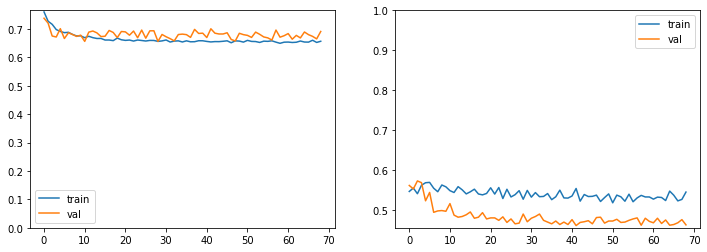

In [35]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 15. Shadows Behind Head 

99 of 99
94 of 94
(154, 160, 160, 3) float32
(154,) int32
(39, 160, 160, 3) float32
(39,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 60s 596ms/step - loss: 85.9271 - val_loss: 94.4051
Epoch 2/100
100/100 [==============================] - 58s 577ms/step - loss: 76.5209 - val_loss: 83.4762
Epoch 3/100
100/100 [==============================] - 58s 577ms/step - loss: 72.0672 - val_loss: 77.7184
Epoch 4/100
100/100 [==============================] - 58s 577ms/step - loss: 68.6848 - val_loss: 77.8706
Epoch 5/100
100/100 [==============================] - 58s 577ms/step - loss: 63.0510 - val_loss: 75.3927
Epoch 6/100
100/100 [==============================] - 58s 578ms/step - loss: 60.7622 - val_loss: 73.1543
Epoch 7/100
100/100 [==============================] - 58s 577ms/step - loss: 56.7354 - val_loss: 71.0632
Epoch 8/100
100/100 [==============================] - 58s 577ms/step - loss: 53.3041 - val_loss: 68.1026
Epoch 9/100
100/100 [==============================] - 58s 577ms/step - loss: 52.6536 - val_loss: 64.4157
Epoch 10/100
100/100 [========================

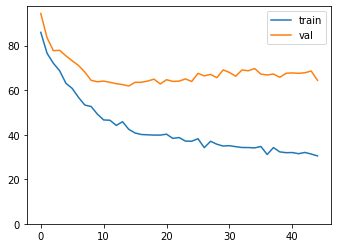

In [36]:
REQ_NAME = 'shadows_behind_head'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 14s 3ms/step - loss: 0.7741 - accuracy: 0.5020 - precision: 0.6784 - recall: 0.4833 - f1: 0.5601 - specificity: 0.5393 - negative_predictive_value: 0.3417 - matthews_correlation_coefficient: 0.0213 - equal_error_rate: 0.4922 - val_loss: 0.7125 - val_accuracy: 0.4821 - val_precision: 0.8047 - val_recall: 0.2909 - val_f1: 0.4259 - val_specificity: 0.8603 - val_negative_predictive_value: 0.3750 - val_matthews_correlation_coefficient: 0.1644 - val_equal_error_rate: 0.4365

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.16439, saving model to ../../models/siamese_networks/shadows_behind_head_2020_06_21-11_25_52.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.7394 - accuracy: 0.5262 - precision: 0.6971 - recall: 0.5164 - f1: 0.5914 - specificity: 0.5458 - negative_predictive_value: 0.3586 - matthews_correlation_coefficient: 0.0

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6327 - accuracy: 0.6215 - precision: 0.7905 - recall: 0.5948 - f1: 0.6762 - specificity: 0.6787 - negative_predictive_value: 0.4519 - matthews_correlation_coefficient: 0.2574 - equal_error_rate: 0.3551 - val_loss: 0.5911 - val_accuracy: 0.7123 - val_precision: 0.8228 - val_recall: 0.7195 - val_f1: 0.7668 - val_specificity: 0.6895 - val_negative_predictive_value: 0.5504 - val_matthews_correlation_coefficient: 0.3906 - val_equal_error_rate: 0.2991

Epoch 00013: val_matthews_correlation_coefficient improved from 0.37088 to 0.39059, saving model to ../../models/siamese_networks/shadows_behind_head_2020_06_21-11_25_52.h5
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6231 - accuracy: 0.6444 - precision: 0.7905 - recall: 0.6406 - f1: 0.7060 - specificity: 0.6521 - negative_predictive_value: 0.4710 - matthews_correlation_coefficient: 0.2765 - equal_error_rate: 0.3482 - val_loss: 0.5826 - val_


Epoch 00025: val_matthews_correlation_coefficient did not improve from 0.42366
Epoch 26/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6145 - accuracy: 0.6667 - precision: 0.8095 - recall: 0.6581 - f1: 0.7245 - specificity: 0.6861 - negative_predictive_value: 0.4971 - matthews_correlation_coefficient: 0.3246 - equal_error_rate: 0.3332 - val_loss: 0.5725 - val_accuracy: 0.7341 - val_precision: 0.8292 - val_recall: 0.7491 - val_f1: 0.7863 - val_specificity: 0.6921 - val_negative_predictive_value: 0.5801 - val_matthews_correlation_coefficient: 0.4249 - val_equal_error_rate: 0.2849

Epoch 00026: val_matthews_correlation_coefficient improved from 0.42366 to 0.42486, saving model to ../../models/siamese_networks/shadows_behind_head_2020_06_21-11_25_52.h5
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6071 - accuracy: 0.6662 - precision: 0.8138 - recall: 0.6527 - f1: 0.7218 - specificity: 0.6983 - negative_predictive_value: 0.4988 - 


Epoch 00038: val_matthews_correlation_coefficient did not improve from 0.43652
Epoch 39/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6134 - accuracy: 0.6638 - precision: 0.8047 - recall: 0.6581 - f1: 0.7226 - specificity: 0.6763 - negative_predictive_value: 0.4937 - matthews_correlation_coefficient: 0.3157 - equal_error_rate: 0.3301 - val_loss: 0.5576 - val_accuracy: 0.7428 - val_precision: 0.8221 - val_recall: 0.7753 - val_f1: 0.7969 - val_specificity: 0.6660 - val_negative_predictive_value: 0.5995 - val_matthews_correlation_coefficient: 0.4311 - val_equal_error_rate: 0.2848

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.43652
Epoch 40/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6048 - accuracy: 0.6754 - precision: 0.8146 - recall: 0.6693 - f1: 0.7333 - specificity: 0.6907 - negative_predictive_value: 0.5075 - matthews_correlation_coefficient: 0.3404 - equal_error_rate: 0.3203 - val_loss: 0.5553 - val_a

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6190 - accuracy: 0.6579 - precision: 0.7954 - recall: 0.6615 - f1: 0.7202 - specificity: 0.6560 - negative_predictive_value: 0.4883 - matthews_correlation_coefficient: 0.2999 - equal_error_rate: 0.3353 - val_loss: 0.5615 - val_accuracy: 0.7350 - val_precision: 0.8405 - val_recall: 0.7370 - val_f1: 0.7846 - val_specificity: 0.7193 - val_negative_predictive_value: 0.5758 - val_matthews_correlation_coefficient: 0.4357 - val_equal_error_rate: 0.2811

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.45046
Epoch 53/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6011 - accuracy: 0.6732 - precision: 0.8178 - recall: 0.6615 - f1: 0.7298 - specificity: 0.6984 - negative_predictive_value: 0.5037 - matthews_correlation_coefficient: 0.3400 - equal_error_rate: 0.3148 - val_loss: 0.5539 - val_accuracy: 0.7480 - val_precision: 0.8288 - val_recall: 0.7767 - val_f1: 0.8010 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6039 - accuracy: 0.6741 - precision: 0.8144 - recall: 0.6683 - f1: 0.7316 - specificity: 0.6902 - negative_predictive_value: 0.5071 - matthews_correlation_coefficient: 0.3392 - equal_error_rate: 0.3218 - val_loss: 0.5537 - val_accuracy: 0.7437 - val_precision: 0.8308 - val_recall: 0.7642 - val_f1: 0.7951 - val_specificity: 0.6913 - val_negative_predictive_value: 0.5961 - val_matthews_correlation_coefficient: 0.4408 - val_equal_error_rate: 0.2809

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.45046
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6121 - accuracy: 0.6575 - precision: 0.8086 - recall: 0.6478 - f1: 0.7156 - specificity: 0.6829 - negative_predictive_value: 0.4877 - matthews_correlation_coefficient: 0.3128 - equal_error_rate: 0.3322 - val_loss: 0.5582 - val_accuracy: 0.7376 - val_precision: 0.8346 - val_recall: 0.7465 - val_f1: 0.7872 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6027 - accuracy: 0.6645 - precision: 0.8082 - recall: 0.6583 - f1: 0.7225 - specificity: 0.6847 - negative_predictive_value: 0.4988 - matthews_correlation_coefficient: 0.3242 - equal_error_rate: 0.3202 - val_loss: 0.5522 - val_accuracy: 0.7454 - val_precision: 0.8331 - val_recall: 0.7641 - val_f1: 0.7961 - val_specificity: 0.6962 - val_negative_predictive_value: 0.5976 - val_matthews_correlation_coefficient: 0.4451 - val_equal_error_rate: 0.2753

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.46081
Epoch 79/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6085 - accuracy: 0.6647 - precision: 0.8021 - recall: 0.6637 - f1: 0.7250 - specificity: 0.6672 - negative_predictive_value: 0.4950 - matthews_correlation_coefficient: 0.3133 - equal_error_rate: 0.3277 - val_loss: 0.5568 - val_accuracy: 0.7393 - val_precision: 0.8398 - val_recall: 0.7429 - val_f1: 0.7876 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5949 - accuracy: 0.6787 - precision: 0.8209 - recall: 0.6667 - f1: 0.7333 - specificity: 0.7039 - negative_predictive_value: 0.5127 - matthews_correlation_coefficient: 0.3513 - equal_error_rate: 0.3133 - val_loss: 0.5368 - val_accuracy: 0.7585 - val_precision: 0.8125 - val_recall: 0.8222 - val_f1: 0.8163 - val_specificity: 0.6194 - val_negative_predictive_value: 0.6368 - val_matthews_correlation_coefficient: 0.4452 - val_equal_error_rate: 0.2791

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.46081
Epoch 92/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6011 - accuracy: 0.6717 - precision: 0.8084 - recall: 0.6698 - f1: 0.7302 - specificity: 0.6810 - negative_predictive_value: 0.5050 - matthews_correlation_coefficient: 0.3313 - equal_error_rate: 0.3224 - val_loss: 0.5422 - val_accuracy: 0.7576 - val_precision: 0.8273 - val_recall: 0.7969 - val_f1: 0.8106 - val_specifici

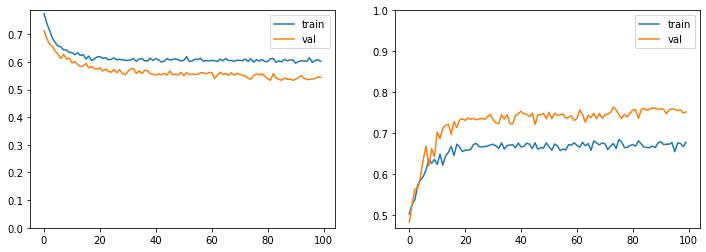

In [37]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 16. Shadows Across Face

158 of 158
141 of 141
(238, 160, 160, 3) float32
(238,) int32
(61, 160, 160, 3) float32
(61,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 67s 666ms/step - loss: 91.7108 - val_loss: 54.2677
Epoch 2/100
100/100 [==============================] - 67s 670ms/step - loss: 78.0293 - val_loss: 46.5537
Epoch 3/100
100/100 [==============================] - 67s 673ms/step - loss: 71.1629 - val_loss: 46.6206
Epoch 4/100
100/100 [==============================] - 67s 668ms/step - loss: 67.6652 - val_loss: 46.3831
Epoch 5/100
100/100 [==============================] - 67s 672ms/step - loss: 62.9002 - val_loss: 46.4964
Epoch 6/100
100/100 [==============================] - 68s 678ms/step - loss: 59.5638 - val_loss: 46.6579
Epoch 7/100
100/100 [==============================] - 67s 669ms/step - loss: 55.9335 - val_loss: 45.2612
Epoch 8/100
100/100 [==============================] - 67s 672ms/step - loss: 53.6617 - val_loss: 45.7472
Epoch 9/100
100/100 [==============================] - 68s 678ms/step - loss: 49.5973 - val_loss: 45.2864
Epoch 10/100
100/100 [========================

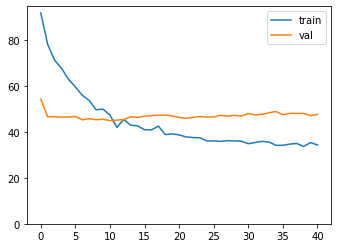

In [38]:
REQ_NAME = 'shadows_across_face'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 15s 3ms/step - loss: 0.8598 - accuracy: 0.5255 - precision: 0.7802 - recall: 0.5671 - f1: 0.6550 - specificity: 0.3550 - negative_predictive_value: 0.1677 - matthews_correlation_coefficient: -0.0634 - equal_error_rate: 0.5443 - val_loss: 0.6962 - val_accuracy: 0.5475 - val_precision: 0.8223 - val_recall: 0.5638 - val_f1: 0.6673 - val_specificity: 0.5061 - val_negative_predictive_value: 0.2220 - val_matthews_correlation_coefficient: 0.0556 - val_equal_error_rate: 0.4641

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.05563, saving model to ../../models/siamese_networks/shadows_across_face_2020_06_21-12_34_35.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.7299 - accuracy: 0.5672 - precision: 0.8366 - recall: 0.5731 - f1: 0.6779 - specificity: 0.5494 - negative_predictive_value: 0.2415 - matthews_correlation_coefficient: 0.

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6415 - accuracy: 0.5999 - precision: 0.8843 - recall: 0.5773 - f1: 0.6967 - specificity: 0.6962 - negative_predictive_value: 0.2893 - matthews_correlation_coefficient: 0.2170 - equal_error_rate: 0.3552 - val_loss: 0.6606 - val_accuracy: 0.5310 - val_precision: 0.9140 - val_recall: 0.4605 - val_f1: 0.6114 - val_specificity: 0.8340 - val_negative_predictive_value: 0.2776 - val_matthews_correlation_coefficient: 0.2373 - val_equal_error_rate: 0.3495

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.24660
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6390 - accuracy: 0.6003 - precision: 0.8820 - recall: 0.5787 - f1: 0.6978 - specificity: 0.6845 - negative_predictive_value: 0.2872 - matthews_correlation_coefficient: 0.2105 - equal_error_rate: 0.3637 - val_loss: 0.6581 - val_accuracy: 0.5310 - val_precision: 0.9122 - val_recall: 0.4616 - val_f1: 0.6119 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6323 - accuracy: 0.5979 - precision: 0.8906 - recall: 0.5675 - f1: 0.6916 - specificity: 0.7191 - negative_predictive_value: 0.2903 - matthews_correlation_coefficient: 0.2270 - equal_error_rate: 0.3607 - val_loss: 0.6613 - val_accuracy: 0.5301 - val_precision: 0.9286 - val_recall: 0.4522 - val_f1: 0.6069 - val_specificity: 0.8691 - val_negative_predictive_value: 0.2828 - val_matthews_correlation_coefficient: 0.2603 - val_equal_error_rate: 0.3504

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.26153
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6268 - accuracy: 0.5923 - precision: 0.8985 - recall: 0.5537 - f1: 0.6838 - specificity: 0.7497 - negative_predictive_value: 0.2938 - matthews_correlation_coefficient: 0.2408 - equal_error_rate: 0.3567 - val_loss: 0.6556 - val_accuracy: 0.5310 - val_precision: 0.9268 - val_recall: 0.4543 - val_f1: 0.6082 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6220 - accuracy: 0.6051 - precision: 0.9100 - recall: 0.5639 - f1: 0.6950 - specificity: 0.7702 - negative_predictive_value: 0.3050 - matthews_correlation_coefficient: 0.2675 - equal_error_rate: 0.3380 - val_loss: 0.6743 - val_accuracy: 0.5135 - val_precision: 0.9296 - val_recall: 0.4306 - val_f1: 0.5872 - val_specificity: 0.8786 - val_negative_predictive_value: 0.2769 - val_matthews_correlation_coefficient: 0.2524 - val_equal_error_rate: 0.3445

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.26575
Epoch 40/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6255 - accuracy: 0.5916 - precision: 0.8974 - recall: 0.5541 - f1: 0.6837 - specificity: 0.7427 - negative_predictive_value: 0.2918 - matthews_correlation_coefficient: 0.2363 - equal_error_rate: 0.3493 - val_loss: 0.6808 - val_accuracy: 0.5144 - val_precision: 0.9317 - val_recall: 0.4306 - val_f1: 0.5876 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6222 - accuracy: 0.6051 - precision: 0.9019 - recall: 0.5701 - f1: 0.6974 - specificity: 0.7535 - negative_predictive_value: 0.3021 - matthews_correlation_coefficient: 0.2562 - equal_error_rate: 0.3413 - val_loss: 0.6646 - val_accuracy: 0.5161 - val_precision: 0.9301 - val_recall: 0.4337 - val_f1: 0.5902 - val_specificity: 0.8786 - val_negative_predictive_value: 0.2781 - val_matthews_correlation_coefficient: 0.2547 - val_equal_error_rate: 0.3384

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.26575
Epoch 53/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6236 - accuracy: 0.6091 - precision: 0.8930 - recall: 0.5828 - f1: 0.7033 - specificity: 0.7191 - negative_predictive_value: 0.2994 - matthews_correlation_coefficient: 0.2404 - equal_error_rate: 0.3413 - val_loss: 0.6785 - val_accuracy: 0.5100 - val_precision: 0.9309 - val_recall: 0.4253 - val_f1: 0.5824 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6193 - accuracy: 0.5984 - precision: 0.8971 - recall: 0.5645 - f1: 0.6917 - specificity: 0.7358 - negative_predictive_value: 0.2958 - matthews_correlation_coefficient: 0.2401 - equal_error_rate: 0.3443 - val_loss: 0.6713 - val_accuracy: 0.5126 - val_precision: 0.9294 - val_recall: 0.4295 - val_f1: 0.5861 - val_specificity: 0.8786 - val_negative_predictive_value: 0.2766 - val_matthews_correlation_coefficient: 0.2516 - val_equal_error_rate: 0.3425

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.26575
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6227 - accuracy: 0.5853 - precision: 0.8988 - recall: 0.5440 - f1: 0.6760 - specificity: 0.7501 - negative_predictive_value: 0.2903 - matthews_correlation_coefficient: 0.2353 - equal_error_rate: 0.3465 - val_loss: 0.6550 - val_accuracy: 0.5283 - val_precision: 0.9298 - val_recall: 0.4492 - val_f1: 0.6043 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6197 - accuracy: 0.6047 - precision: 0.8958 - recall: 0.5738 - f1: 0.6977 - specificity: 0.7342 - negative_predictive_value: 0.2989 - matthews_correlation_coefficient: 0.2440 - equal_error_rate: 0.3433 - val_loss: 0.6950 - val_accuracy: 0.5013 - val_precision: 0.9339 - val_recall: 0.4117 - val_f1: 0.5696 - val_specificity: 0.8899 - val_negative_predictive_value: 0.2729 - val_matthews_correlation_coefficient: 0.2493 - val_equal_error_rate: 0.3367

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.26575
Epoch 79/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6252 - accuracy: 0.5953 - precision: 0.9012 - recall: 0.5564 - f1: 0.6863 - specificity: 0.7544 - negative_predictive_value: 0.2969 - matthews_correlation_coefficient: 0.2473 - equal_error_rate: 0.3494 - val_loss: 0.6914 - val_accuracy: 0.5048 - val_precision: 0.9343 - val_recall: 0.4158 - val_f1: 0.5738 - val_specifici

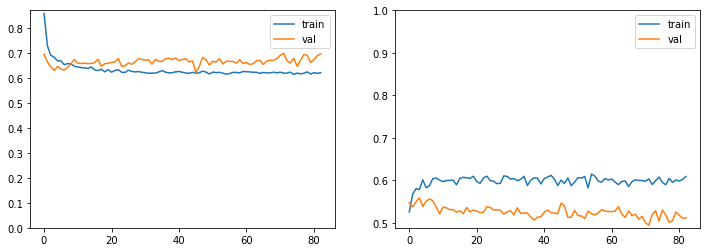

In [39]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 17. Dark Tinted Lenses

315 of 315
136 of 136
(360, 160, 160, 3) float32
(360,) int32
(91, 160, 160, 3) float32
(91,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 109s 1s/step - loss: 96.1548 - val_loss: 95.6076
Epoch 2/100
100/100 [==============================] - 104s 1s/step - loss: 89.9757 - val_loss: 99.4914
Epoch 3/100
100/100 [==============================] - 106s 1s/step - loss: 87.8983 - val_loss: 104.6205
Epoch 4/100
100/100 [==============================] - 104s 1s/step - loss: 85.2207 - val_loss: 106.2791
Epoch 5/100
100/100 [==============================] - 105s 1s/step - loss: 83.7613 - val_loss: 107.8778
Epoch 6/100
100/100 [==============================] - 105s 1s/step - loss: 81.2046 - val_loss: 112.0631
Epoch 7/100
100/100 [==============================] - 104s 1s/step - loss: 79.8037 - val_loss: 112.4295
Epoch 8/100
100/100 [==============================] - 105s 1s/step - loss: 80.1638 - val_loss: 112.0704
Epoch 9/100
100/100 [==============================] - 106s 1s/step - loss: 77.6588 - val_loss: 112.0090
Epoch 10/100
100/100 [==============================] - 1

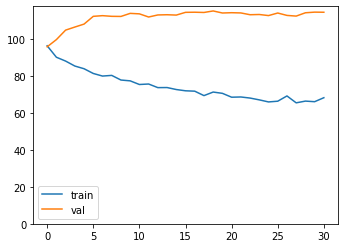

In [40]:
REQ_NAME = 'dark_tinted_lenses'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.9, 1.1),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 15s 3ms/step - loss: 0.6457 - accuracy: 0.6900 - precision: 0.9189 - recall: 0.7145 - f1: 0.8016 - specificity: 0.4823 - negative_predictive_value: 0.1771 - matthews_correlation_coefficient: 0.1359 - equal_error_rate: 0.3659 - val_loss: 0.5563 - val_accuracy: 0.6722 - val_precision: 0.9201 - val_recall: 0.6964 - val_f1: 0.7917 - val_specificity: 0.5356 - val_negative_predictive_value: 0.1731 - val_matthews_correlation_coefficient: 0.1452 - val_equal_error_rate: 0.3135

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.14518, saving model to ../../models/siamese_networks/dark_tinted_lenses_2020_06_21-13_47_45.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6297 - accuracy: 0.5984 - precision: 0.9268 - recall: 0.5967 - f1: 0.7245 - specificity: 0.6308 - negative_predictive_value: 0.1607 - matthews_correlation_coefficient: 0.13

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5751 - accuracy: 0.5953 - precision: 0.9440 - recall: 0.5803 - f1: 0.7177 - specificity: 0.7243 - negative_predictive_value: 0.1781 - matthews_correlation_coefficient: 0.1907 - equal_error_rate: 0.3340 - val_loss: 0.5633 - val_accuracy: 0.5292 - val_precision: 0.9668 - val_recall: 0.4848 - val_f1: 0.6438 - val_specificity: 0.8675 - val_negative_predictive_value: 0.1701 - val_matthews_correlation_coefficient: 0.2175 - val_equal_error_rate: 0.3155

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.21945
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5854 - accuracy: 0.5729 - precision: 0.9479 - recall: 0.5508 - f1: 0.6956 - specificity: 0.7574 - negative_predictive_value: 0.1744 - matthews_correlation_coefficient: 0.1921 - equal_error_rate: 0.3354 - val_loss: 0.5654 - val_accuracy: 0.5187 - val_precision: 0.9661 - val_recall: 0.4737 - val_f1: 0.6338 - val_specifici


Epoch 00025: val_matthews_correlation_coefficient improved from 0.23944 to 0.24287, saving model to ../../models/siamese_networks/dark_tinted_lenses_2020_06_21-13_47_45.h5
Epoch 26/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5713 - accuracy: 0.5908 - precision: 0.9540 - recall: 0.5674 - f1: 0.7106 - specificity: 0.7859 - negative_predictive_value: 0.1839 - matthews_correlation_coefficient: 0.2194 - equal_error_rate: 0.3269 - val_loss: 0.5751 - val_accuracy: 0.5179 - val_precision: 0.9792 - val_recall: 0.4652 - val_f1: 0.6291 - val_specificity: 0.9140 - val_negative_predictive_value: 0.1728 - val_matthews_correlation_coefficient: 0.2379 - val_equal_error_rate: 0.3021

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.24287
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5809 - accuracy: 0.5709 - precision: 0.9502 - recall: 0.5462 - f1: 0.6927 - specificity: 0.7670 - negative_predictive_value: 0.1745 - m

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5746 - accuracy: 0.5591 - precision: 0.9562 - recall: 0.5281 - f1: 0.6792 - specificity: 0.8100 - negative_predictive_value: 0.1766 - matthews_correlation_coefficient: 0.2104 - equal_error_rate: 0.3427 - val_loss: 0.5811 - val_accuracy: 0.5318 - val_precision: 0.9733 - val_recall: 0.4824 - val_f1: 0.6436 - val_specificity: 0.8713 - val_negative_predictive_value: 0.1740 - val_matthews_correlation_coefficient: 0.2267 - val_equal_error_rate: 0.3163

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.24312
Epoch 40/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5643 - accuracy: 0.5870 - precision: 0.9562 - recall: 0.5619 - f1: 0.7067 - specificity: 0.7950 - negative_predictive_value: 0.1846 - matthews_correlation_coefficient: 0.2226 - equal_error_rate: 0.3166 - val_loss: 0.5899 - val_accuracy: 0.5083 - val_precision: 0.9784 - val_recall: 0.4551 - val_f1: 0.6200 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5676 - accuracy: 0.5748 - precision: 0.9550 - recall: 0.5472 - f1: 0.6945 - specificity: 0.7934 - negative_predictive_value: 0.1805 - matthews_correlation_coefficient: 0.2130 - equal_error_rate: 0.3319 - val_loss: 0.5922 - val_accuracy: 0.5144 - val_precision: 0.9707 - val_recall: 0.4644 - val_f1: 0.6270 - val_specificity: 0.8654 - val_negative_predictive_value: 0.1676 - val_matthews_correlation_coefficient: 0.2121 - val_equal_error_rate: 0.3041

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.24312
Epoch 53/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5633 - accuracy: 0.5844 - precision: 0.9581 - recall: 0.5573 - f1: 0.7036 - specificity: 0.8087 - negative_predictive_value: 0.1847 - matthews_correlation_coefficient: 0.2272 - equal_error_rate: 0.3147 - val_loss: 0.6026 - val_accuracy: 0.5022 - val_precision: 0.9736 - val_recall: 0.4483 - val_f1: 0.6126 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5561 - accuracy: 0.5979 - precision: 0.9585 - recall: 0.5724 - f1: 0.7160 - specificity: 0.8100 - negative_predictive_value: 0.1904 - matthews_correlation_coefficient: 0.2368 - equal_error_rate: 0.3146 - val_loss: 0.6067 - val_accuracy: 0.5057 - val_precision: 0.9739 - val_recall: 0.4531 - val_f1: 0.6173 - val_specificity: 0.8783 - val_negative_predictive_value: 0.1667 - val_matthews_correlation_coefficient: 0.2143 - val_equal_error_rate: 0.3048

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.24312
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5599 - accuracy: 0.5979 - precision: 0.9563 - recall: 0.5749 - f1: 0.7169 - specificity: 0.7961 - negative_predictive_value: 0.1894 - matthews_correlation_coefficient: 0.2310 - equal_error_rate: 0.3161 - val_loss: 0.6084 - val_accuracy: 0.5109 - val_precision: 0.9741 - val_recall: 0.4588 - val_f1: 0.6225 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5549 - accuracy: 0.6025 - precision: 0.9560 - recall: 0.5800 - f1: 0.7209 - specificity: 0.7939 - negative_predictive_value: 0.1902 - matthews_correlation_coefficient: 0.2317 - equal_error_rate: 0.3085 - val_loss: 0.6101 - val_accuracy: 0.5187 - val_precision: 0.9729 - val_recall: 0.4681 - val_f1: 0.6304 - val_specificity: 0.8723 - val_negative_predictive_value: 0.1697 - val_matthews_correlation_coefficient: 0.2188 - val_equal_error_rate: 0.3005

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.24312
Epoch 79/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5548 - accuracy: 0.5914 - precision: 0.9595 - recall: 0.5650 - f1: 0.7100 - specificity: 0.8063 - negative_predictive_value: 0.1889 - matthews_correlation_coefficient: 0.2332 - equal_error_rate: 0.3106 - val_loss: 0.6252 - val_accuracy: 0.4996 - val_precision: 0.9735 - val_recall: 0.4456 - val_f1: 0.6100 - val_specifici

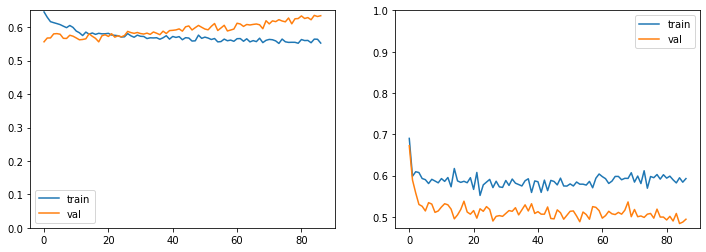

In [41]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 18. Flash Reflection on Lenses

437 of 437
363 of 363
(639, 160, 160, 3) float32
(639,) int32
(161, 160, 160, 3) float32
(161,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 71s 707ms/step - loss: 88.0850 - val_loss: 108.3271
Epoch 2/100
100/100 [==============================] - 68s 678ms/step - loss: 75.3407 - val_loss: 112.7721
Epoch 3/100
100/100 [==============================] - 68s 680ms/step - loss: 72.4888 - val_loss: 113.3947
Epoch 4/100
100/100 [==============================] - 69s 689ms/step - loss: 66.6829 - val_loss: 112.2649
Epoch 5/100
100/100 [==============================] - 69s 688ms/step - loss: 65.4185 - val_loss: 111.8187
Epoch 6/100
100/100 [==============================] - 70s 697ms/step - loss: 62.4438 - val_loss: 111.3271
Epoch 7/100
100/100 [==============================] - 70s 697ms/step - loss: 62.7843 - val_loss: 109.0385
Epoch 8/100
100/100 [==============================] - 71s 707ms/step - loss: 59.6991 - val_loss: 107.2743
Epoch 9/100
100/100 [==============================] - 71s 712ms/step - loss: 59.6987 - val_loss: 106.7372
Epoch 10/100
100/100 [===============

100/100 [==============================] - 69s 691ms/step - loss: 37.3045 - val_loss: 89.7394
Epoch 78/100
100/100 [==============================] - 70s 696ms/step - loss: 40.0981 - val_loss: 88.1100
Epoch 79/100
100/100 [==============================] - 71s 713ms/step - loss: 37.8134 - val_loss: 88.3263
Epoch 80/100
100/100 [==============================] - 70s 704ms/step - loss: 41.6280 - val_loss: 90.3083
Epoch 81/100
100/100 [==============================] - 71s 708ms/step - loss: 41.7909 - val_loss: 89.5867
Epoch 82/100
100/100 [==============================] - 67s 670ms/step - loss: 38.5743 - val_loss: 90.0430
Epoch 83/100
100/100 [==============================] - 68s 677ms/step - loss: 39.7049 - val_loss: 90.3105
Epoch 84/100
100/100 [==============================] - 69s 685ms/step - loss: 42.6900 - val_loss: 89.5569
Epoch 85/100
100/100 [==============================] - 69s 685ms/step - loss: 40.7763 - val_loss: 90.6507
Epoch 86/100
100/100 [============================

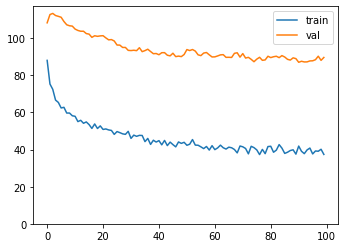

In [42]:
REQ_NAME = 'flash_reflection_on_lenses'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 15s 3ms/step - loss: 0.6739 - accuracy: 0.6217 - precision: 0.8643 - recall: 0.6258 - f1: 0.7232 - specificity: 0.6100 - negative_predictive_value: 0.2896 - matthews_correlation_coefficient: 0.1899 - equal_error_rate: 0.3668 - val_loss: 0.6414 - val_accuracy: 0.5545 - val_precision: 0.9040 - val_recall: 0.4892 - val_f1: 0.6325 - val_specificity: 0.8021 - val_negative_predictive_value: 0.2866 - val_matthews_correlation_coefficient: 0.2354 - val_equal_error_rate: 0.3587

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.23542, saving model to ../../models/siamese_networks/flash_reflection_on_lenses_2020_06_21-16_03_19.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6594 - accuracy: 0.6215 - precision: 0.8762 - recall: 0.6110 - f1: 0.7190 - specificity: 0.6633 - negative_predictive_value: 0.3013 - matthews_correlation_coefficie

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6064 - accuracy: 0.6126 - precision: 0.9009 - recall: 0.5783 - f1: 0.7026 - specificity: 0.7549 - negative_predictive_value: 0.3137 - matthews_correlation_coefficient: 0.2664 - equal_error_rate: 0.3305 - val_loss: 0.6524 - val_accuracy: 0.5798 - val_precision: 0.9291 - val_recall: 0.5083 - val_f1: 0.6552 - val_specificity: 0.8550 - val_negative_predictive_value: 0.3082 - val_matthews_correlation_coefficient: 0.2934 - val_equal_error_rate: 0.3315

Epoch 00013: val_matthews_correlation_coefficient improved from 0.29257 to 0.29338, saving model to ../../models/siamese_networks/flash_reflection_on_lenses_2020_06_21-16_03_19.h5
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6047 - accuracy: 0.6099 - precision: 0.8955 - recall: 0.5774 - f1: 0.7009 - specificity: 0.7357 - negative_predictive_value: 0.3080 - matthews_correlation_coefficient: 0.2516 - equal_error_rate: 0.3436 - val_loss: 0.6434

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6004 - accuracy: 0.6023 - precision: 0.9091 - recall: 0.5585 - f1: 0.6899 - specificity: 0.7798 - negative_predictive_value: 0.3108 - matthews_correlation_coefficient: 0.2723 - equal_error_rate: 0.3345 - val_loss: 0.6570 - val_accuracy: 0.5745 - val_precision: 0.9309 - val_recall: 0.4986 - val_f1: 0.6475 - val_specificity: 0.8627 - val_negative_predictive_value: 0.3063 - val_matthews_correlation_coefficient: 0.2925 - val_equal_error_rate: 0.3169

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.29672
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5920 - accuracy: 0.6198 - precision: 0.9064 - recall: 0.5827 - f1: 0.7076 - specificity: 0.7685 - negative_predictive_value: 0.3179 - matthews_correlation_coefficient: 0.2799 - equal_error_rate: 0.3218 - val_loss: 0.6584 - val_accuracy: 0.5772 - val_precision: 0.9319 - val_recall: 0.5030 - val_f1: 0.6516 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5934 - accuracy: 0.6080 - precision: 0.9162 - recall: 0.5600 - f1: 0.6939 - specificity: 0.8006 - negative_predictive_value: 0.3154 - matthews_correlation_coefficient: 0.2884 - equal_error_rate: 0.3232 - val_loss: 0.6426 - val_accuracy: 0.5763 - val_precision: 0.9314 - val_recall: 0.5008 - val_f1: 0.6495 - val_specificity: 0.8627 - val_negative_predictive_value: 0.3071 - val_matthews_correlation_coefficient: 0.2942 - val_equal_error_rate: 0.3133

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.29987
Epoch 40/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5870 - accuracy: 0.6333 - precision: 0.9142 - recall: 0.5960 - f1: 0.7200 - specificity: 0.7807 - negative_predictive_value: 0.3293 - matthews_correlation_coefficient: 0.3021 - equal_error_rate: 0.3196 - val_loss: 0.6615 - val_accuracy: 0.5728 - val_precision: 0.9308 - val_recall: 0.4966 - val_f1: 0.6458 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5925 - accuracy: 0.6263 - precision: 0.9166 - recall: 0.5841 - f1: 0.7123 - specificity: 0.7923 - negative_predictive_value: 0.3245 - matthews_correlation_coefficient: 0.3000 - equal_error_rate: 0.3263 - val_loss: 0.6752 - val_accuracy: 0.5745 - val_precision: 0.9335 - val_recall: 0.4977 - val_f1: 0.6473 - val_specificity: 0.8671 - val_negative_predictive_value: 0.3065 - val_matthews_correlation_coefficient: 0.2957 - val_equal_error_rate: 0.3042

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.30126
Epoch 53/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5854 - accuracy: 0.6250 - precision: 0.9223 - recall: 0.5797 - f1: 0.7101 - specificity: 0.8106 - negative_predictive_value: 0.3296 - matthews_correlation_coefficient: 0.3127 - equal_error_rate: 0.3111 - val_loss: 0.6787 - val_accuracy: 0.5763 - val_precision: 0.9340 - val_recall: 0.5009 - val_f1: 0.6502 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5881 - accuracy: 0.6252 - precision: 0.9113 - recall: 0.5878 - f1: 0.7131 - specificity: 0.7709 - negative_predictive_value: 0.3226 - matthews_correlation_coefficient: 0.2889 - equal_error_rate: 0.3183 - val_loss: 0.6796 - val_accuracy: 0.5719 - val_precision: 0.9330 - val_recall: 0.4946 - val_f1: 0.6443 - val_specificity: 0.8671 - val_negative_predictive_value: 0.3054 - val_matthews_correlation_coefficient: 0.2934 - val_equal_error_rate: 0.2996

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.30531
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5913 - accuracy: 0.6141 - precision: 0.9123 - recall: 0.5708 - f1: 0.7006 - specificity: 0.7815 - negative_predictive_value: 0.3185 - matthews_correlation_coefficient: 0.2846 - equal_error_rate: 0.3224 - val_loss: 0.6789 - val_accuracy: 0.5719 - val_precision: 0.9329 - val_recall: 0.4945 - val_f1: 0.6445 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5811 - accuracy: 0.6324 - precision: 0.9243 - recall: 0.5876 - f1: 0.7171 - specificity: 0.8117 - negative_predictive_value: 0.3332 - matthews_correlation_coefficient: 0.3200 - equal_error_rate: 0.3064 - val_loss: 0.6509 - val_accuracy: 0.5789 - val_precision: 0.9322 - val_recall: 0.5038 - val_f1: 0.6521 - val_specificity: 0.8633 - val_negative_predictive_value: 0.3082 - val_matthews_correlation_coefficient: 0.2968 - val_equal_error_rate: 0.3082

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.30531
Epoch 79/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5890 - accuracy: 0.6237 - precision: 0.9150 - recall: 0.5826 - f1: 0.7108 - specificity: 0.7904 - negative_predictive_value: 0.3242 - matthews_correlation_coefficient: 0.2980 - equal_error_rate: 0.3117 - val_loss: 0.6471 - val_accuracy: 0.5789 - val_precision: 0.9322 - val_recall: 0.5038 - val_f1: 0.6521 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.5886 - accuracy: 0.6235 - precision: 0.9117 - recall: 0.5854 - f1: 0.7118 - specificity: 0.7799 - negative_predictive_value: 0.3227 - matthews_correlation_coefficient: 0.2917 - equal_error_rate: 0.3095 - val_loss: 0.6665 - val_accuracy: 0.5763 - val_precision: 0.9320 - val_recall: 0.5007 - val_f1: 0.6494 - val_specificity: 0.8633 - val_negative_predictive_value: 0.3068 - val_matthews_correlation_coefficient: 0.2946 - val_equal_error_rate: 0.3096

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.30531
Epoch 92/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.5897 - accuracy: 0.6161 - precision: 0.9172 - recall: 0.5697 - f1: 0.7013 - specificity: 0.8007 - negative_predictive_value: 0.3209 - matthews_correlation_coefficient: 0.2963 - equal_error_rate: 0.3238 - val_loss: 0.6566 - val_accuracy: 0.5798 - val_precision: 0.9326 - val_recall: 0.5049 - val_f1: 0.6531 - val_specifici

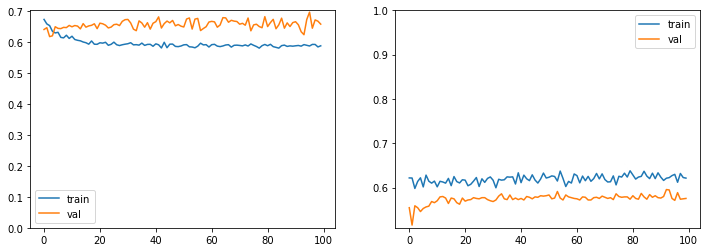

In [43]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### ~~19. Frames Too Heavy~~

#### 20. Frame Covering Eyes  

334 of 334
211 of 211
(435, 160, 160, 3) float32
(435,) int32
(110, 160, 160, 3) float32
(110,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 125s 1s/step - loss: 101.1173 - val_loss: 96.4831
Epoch 2/100
100/100 [==============================] - 118s 1s/step - loss: 100.2287 - val_loss: 97.6530
Epoch 3/100
100/100 [==============================] - 119s 1s/step - loss: 99.3667 - val_loss: 96.0942
Epoch 4/100
100/100 [==============================] - 118s 1s/step - loss: 98.6581 - val_loss: 96.3261
Epoch 5/100
100/100 [==============================] - 118s 1s/step - loss: 97.5042 - val_loss: 95.9334
Epoch 6/100
100/100 [==============================] - 119s 1s/step - loss: 96.7206 - val_loss: 95.0962
Epoch 7/100
100/100 [==============================] - 118s 1s/step - loss: 93.9982 - val_loss: 90.0934
Epoch 8/100
100/100 [==============================] - 118s 1s/step - loss: 95.8025 - val_loss: 91.1360
Epoch 9/100
100/100 [==============================] - 117s 1s/step - loss: 94.6236 - val_loss: 91.6643
Epoch 10/100
100/100 [==============================] - 118s 1

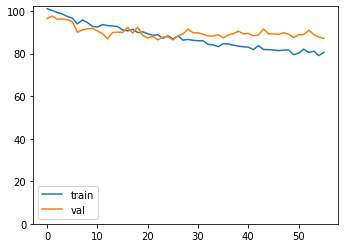

In [44]:
REQ_NAME = 'frame_covering_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 16s 3ms/step - loss: 0.7301 - accuracy: 0.5478 - precision: 0.7402 - recall: 0.5568 - f1: 0.6319 - specificity: 0.5214 - negative_predictive_value: 0.3252 - matthews_correlation_coefficient: 0.0714 - equal_error_rate: 0.4521 - val_loss: 0.7009 - val_accuracy: 0.4804 - val_precision: 0.8745 - val_recall: 0.3107 - val_f1: 0.4576 - val_specificity: 0.8937 - val_negative_predictive_value: 0.3500 - val_matthews_correlation_coefficient: 0.2139 - val_equal_error_rate: 0.3619

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21388, saving model to ../../models/siamese_networks/frame_covering_eyes_2020_06_21-18_15_59.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6996 - accuracy: 0.5502 - precision: 0.7634 - recall: 0.5319 - f1: 0.6245 - specificity: 0.5988 - negative_predictive_value: 0.3444 - matthews_correlation_coefficient: 0.1

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6498 - accuracy: 0.5777 - precision: 0.7966 - recall: 0.5446 - f1: 0.6445 - specificity: 0.6558 - negative_predictive_value: 0.3733 - matthews_correlation_coefficient: 0.1844 - equal_error_rate: 0.3979 - val_loss: 0.6806 - val_accuracy: 0.5074 - val_precision: 0.8377 - val_recall: 0.3759 - val_f1: 0.5171 - val_specificity: 0.8251 - val_negative_predictive_value: 0.3544 - val_matthews_correlation_coefficient: 0.1960 - val_equal_error_rate: 0.3701

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.23401
Epoch 15/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6496 - accuracy: 0.5777 - precision: 0.8067 - recall: 0.5322 - f1: 0.6389 - specificity: 0.6911 - negative_predictive_value: 0.3778 - matthews_correlation_coefficient: 0.2028 - equal_error_rate: 0.3935 - val_loss: 0.6763 - val_accuracy: 0.5118 - val_precision: 0.8395 - val_recall: 0.3815 - val_f1: 0.5229 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6403 - accuracy: 0.5905 - precision: 0.8193 - recall: 0.5443 - f1: 0.6522 - specificity: 0.7064 - negative_predictive_value: 0.3889 - matthews_correlation_coefficient: 0.2283 - equal_error_rate: 0.3786 - val_loss: 0.6568 - val_accuracy: 0.5301 - val_precision: 0.8413 - val_recall: 0.4106 - val_f1: 0.5499 - val_specificity: 0.8115 - val_negative_predictive_value: 0.3637 - val_matthews_correlation_coefficient: 0.2127 - val_equal_error_rate: 0.3686

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.23401
Epoch 28/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6422 - accuracy: 0.5875 - precision: 0.8178 - recall: 0.5409 - f1: 0.6487 - specificity: 0.7055 - negative_predictive_value: 0.3866 - matthews_correlation_coefficient: 0.2243 - equal_error_rate: 0.3777 - val_loss: 0.6657 - val_accuracy: 0.5257 - val_precision: 0.8452 - val_recall: 0.3997 - val_f1: 0.5409 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6411 - accuracy: 0.5772 - precision: 0.8093 - recall: 0.5306 - f1: 0.6381 - specificity: 0.6985 - negative_predictive_value: 0.3790 - matthews_correlation_coefficient: 0.2075 - equal_error_rate: 0.3896 - val_loss: 0.6760 - val_accuracy: 0.5196 - val_precision: 0.8604 - val_recall: 0.3789 - val_f1: 0.5246 - val_specificity: 0.8530 - val_negative_predictive_value: 0.3630 - val_matthews_correlation_coefficient: 0.2271 - val_equal_error_rate: 0.3661

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.23401
Epoch 41/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6339 - accuracy: 0.5884 - precision: 0.8185 - recall: 0.5381 - f1: 0.6459 - specificity: 0.7136 - negative_predictive_value: 0.3901 - matthews_correlation_coefficient: 0.2289 - equal_error_rate: 0.3700 - val_loss: 0.6549 - val_accuracy: 0.5344 - val_precision: 0.8432 - val_recall: 0.4181 - val_f1: 0.5574 - val_specifici

4584/4584 [==============================] - 13s 3ms/step - loss: 0.6380 - accuracy: 0.5846 - precision: 0.8099 - recall: 0.5418 - f1: 0.6466 - specificity: 0.6911 - negative_predictive_value: 0.3836 - matthews_correlation_coefficient: 0.2120 - equal_error_rate: 0.3762 - val_loss: 0.6538 - val_accuracy: 0.5353 - val_precision: 0.8428 - val_recall: 0.4220 - val_f1: 0.5609 - val_specificity: 0.8092 - val_negative_predictive_value: 0.3672 - val_matthews_correlation_coefficient: 0.2198 - val_equal_error_rate: 0.3652

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.25211
Epoch 54/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6365 - accuracy: 0.5875 - precision: 0.8077 - recall: 0.5505 - f1: 0.6528 - specificity: 0.6824 - negative_predictive_value: 0.3844 - matthews_correlation_coefficient: 0.2113 - equal_error_rate: 0.3830 - val_loss: 0.6525 - val_accuracy: 0.5397 - val_precision: 0.8417 - val_recall: 0.4275 - val_f1: 0.5657 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6410 - accuracy: 0.5740 - precision: 0.8143 - recall: 0.5200 - f1: 0.6319 - specificity: 0.7109 - negative_predictive_value: 0.3798 - matthews_correlation_coefficient: 0.2116 - equal_error_rate: 0.3836 - val_loss: 0.6780 - val_accuracy: 0.5153 - val_precision: 0.8500 - val_recall: 0.3795 - val_f1: 0.5231 - val_specificity: 0.8382 - val_negative_predictive_value: 0.3593 - val_matthews_correlation_coefficient: 0.2131 - val_equal_error_rate: 0.3651

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.25211
Epoch 67/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6406 - accuracy: 0.5803 - precision: 0.8150 - recall: 0.5291 - f1: 0.6395 - specificity: 0.7057 - negative_predictive_value: 0.3809 - matthews_correlation_coefficient: 0.2142 - equal_error_rate: 0.3819 - val_loss: 0.6726 - val_accuracy: 0.5231 - val_precision: 0.8510 - val_recall: 0.3905 - val_f1: 0.5338 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6350 - accuracy: 0.5812 - precision: 0.8236 - recall: 0.5206 - f1: 0.6363 - specificity: 0.7305 - negative_predictive_value: 0.3848 - matthews_correlation_coefficient: 0.2285 - equal_error_rate: 0.3796 - val_loss: 0.6598 - val_accuracy: 0.5379 - val_precision: 0.8442 - val_recall: 0.4268 - val_f1: 0.5652 - val_specificity: 0.8089 - val_negative_predictive_value: 0.3693 - val_matthews_correlation_coefficient: 0.2238 - val_equal_error_rate: 0.3585

Epoch 00079: val_matthews_correlation_coefficient did not improve from 0.25211
Epoch 80/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6399 - accuracy: 0.5918 - precision: 0.8209 - recall: 0.5428 - f1: 0.6514 - specificity: 0.7126 - negative_predictive_value: 0.3911 - matthews_correlation_coefficient: 0.2325 - equal_error_rate: 0.3765 - val_loss: 0.6731 - val_accuracy: 0.5179 - val_precision: 0.8544 - val_recall: 0.3847 - val_f1: 0.5287 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6351 - accuracy: 0.5720 - precision: 0.8269 - recall: 0.5013 - f1: 0.6228 - specificity: 0.7449 - negative_predictive_value: 0.3798 - matthews_correlation_coefficient: 0.2254 - equal_error_rate: 0.3698 - val_loss: 0.6529 - val_accuracy: 0.5458 - val_precision: 0.8466 - val_recall: 0.4389 - val_f1: 0.5766 - val_specificity: 0.8066 - val_negative_predictive_value: 0.3733 - val_matthews_correlation_coefficient: 0.2319 - val_equal_error_rate: 0.3621

Epoch 00092: val_matthews_correlation_coefficient did not improve from 0.25211
Epoch 93/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6411 - accuracy: 0.5801 - precision: 0.8095 - recall: 0.5353 - f1: 0.6414 - specificity: 0.6939 - negative_predictive_value: 0.3811 - matthews_correlation_coefficient: 0.2088 - equal_error_rate: 0.3824 - val_loss: 0.6651 - val_accuracy: 0.5318 - val_precision: 0.8581 - val_recall: 0.4041 - val_f1: 0.5480 - val_specifici

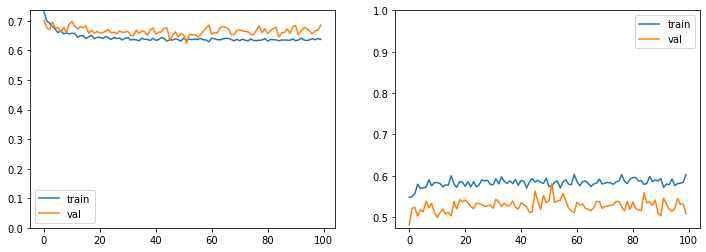

In [45]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 21. Hat/cap 

900 of 900
846 of 846
(1396, 160, 160, 3) float32
(1396,) int32
(350, 160, 160, 3) float32
(350,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 131s 1s/step - loss: 100.5860 - val_loss: 95.4087
Epoch 2/100
100/100 [==============================] - 119s 1s/step - loss: 97.6159 - val_loss: 88.4313
Epoch 3/100
100/100 [==============================] - 114s 1s/step - loss: 98.0335 - val_loss: 87.3239
Epoch 4/100
100/100 [==============================] - 112s 1s/step - loss: 96.2814 - val_loss: 88.6270
Epoch 5/100
100/100 [==============================] - 112s 1s/step - loss: 94.9578 - val_loss: 86.6838
Epoch 6/100
100/100 [==============================] - 120s 1s/step - loss: 96.2076 - val_loss: 86.4521
Epoch 7/100
100/100 [==============================] - 115s 1s/step - loss: 94.6394 - val_loss: 82.4494
Epoch 8/100
100/100 [==============================] - 112s 1s/step - loss: 93.4375 - val_loss: 80.2758
Epoch 9/100
100/100 [==============================] - 112s 1s/step - loss: 93.1072 - val_loss: 80.0712
Epoch 10/100
100/100 [==============================] - 121s 1s

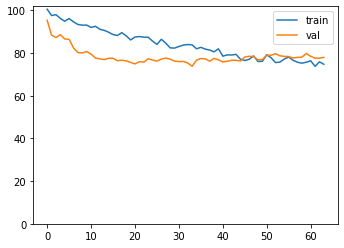

In [46]:
REQ_NAME = 'hat_cap'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 16s 3ms/step - loss: 0.8118 - accuracy: 0.4734 - precision: 0.8329 - recall: 0.4773 - f1: 0.6052 - specificity: 0.4448 - negative_predictive_value: 0.1297 - matthews_correlation_coefficient: -0.0535 - equal_error_rate: 0.5284 - val_loss: 0.8684 - val_accuracy: 0.2371 - val_precision: 0.9253 - val_recall: 0.1166 - val_f1: 0.2049 - val_specificity: 0.9433 - val_negative_predictive_value: 0.1549 - val_matthews_correlation_coefficient: 0.0677 - val_equal_error_rate: 0.4862

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06774, saving model to ../../models/siamese_networks/hat_cap_2020_06_21-20_43_05.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.7374 - accuracy: 0.5031 - precision: 0.8620 - recall: 0.4960 - f1: 0.6273 - specificity: 0.5348 - negative_predictive_value: 0.1573 - matthews_correlation_coefficient: 0.0245 - equal

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6293 - accuracy: 0.5785 - precision: 0.9145 - recall: 0.5579 - f1: 0.6919 - specificity: 0.6996 - negative_predictive_value: 0.2147 - matthews_correlation_coefficient: 0.1819 - equal_error_rate: 0.3689 - val_loss: 0.8443 - val_accuracy: 0.4037 - val_precision: 0.9741 - val_recall: 0.3074 - val_f1: 0.4644 - val_specificity: 0.9477 - val_negative_predictive_value: 0.1906 - val_matthews_correlation_coefficient: 0.2040 - val_equal_error_rate: 0.3233

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.20535
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6441 - accuracy: 0.5812 - precision: 0.9050 - recall: 0.5679 - f1: 0.6959 - specificity: 0.6515 - negative_predictive_value: 0.2074 - matthews_correlation_coefficient: 0.1560 - equal_error_rate: 0.3861 - val_loss: 0.8716 - val_accuracy: 0.3941 - val_precision: 0.9735 - val_recall: 0.2966 - val_f1: 0.4520 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6237 - accuracy: 0.5908 - precision: 0.9128 - recall: 0.5762 - f1: 0.7034 - specificity: 0.6758 - negative_predictive_value: 0.2165 - matthews_correlation_coefficient: 0.1796 - equal_error_rate: 0.3630 - val_loss: 0.8945 - val_accuracy: 0.3941 - val_precision: 0.9835 - val_recall: 0.2956 - val_f1: 0.4517 - val_specificity: 0.9735 - val_negative_predictive_value: 0.1907 - val_matthews_correlation_coefficient: 0.2148 - val_equal_error_rate: 0.3073

Epoch 00026: val_matthews_correlation_coefficient improved from 0.21197 to 0.21481, saving model to ../../models/siamese_networks/hat_cap_2020_06_21-20_43_05.h5
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6278 - accuracy: 0.5731 - precision: 0.9102 - recall: 0.5552 - f1: 0.6876 - specificity: 0.6742 - negative_predictive_value: 0.2100 - matthews_correlation_coefficient: 0.1649 - equal_error_rate: 0.3774 - val_loss: 0.8248 - val_accuracy: 0.

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6190 - accuracy: 0.5757 - precision: 0.9223 - recall: 0.5481 - f1: 0.6864 - specificity: 0.7384 - negative_predictive_value: 0.2198 - matthews_correlation_coefficient: 0.2008 - equal_error_rate: 0.3530 - val_loss: 0.7912 - val_accuracy: 0.4194 - val_precision: 0.9766 - val_recall: 0.3260 - val_f1: 0.4854 - val_specificity: 0.9471 - val_negative_predictive_value: 0.1949 - val_matthews_correlation_coefficient: 0.2152 - val_equal_error_rate: 0.3133

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.22455
Epoch 40/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6057 - accuracy: 0.6154 - precision: 0.9306 - recall: 0.5928 - f1: 0.7227 - specificity: 0.7535 - negative_predictive_value: 0.2411 - matthews_correlation_coefficient: 0.2427 - equal_error_rate: 0.3334 - val_loss: 0.8151 - val_accuracy: 0.4133 - val_precision: 0.9793 - val_recall: 0.3181 - val_f1: 0.4773 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6133 - accuracy: 0.6023 - precision: 0.9242 - recall: 0.5814 - f1: 0.7117 - specificity: 0.7220 - negative_predictive_value: 0.2310 - matthews_correlation_coefficient: 0.2158 - equal_error_rate: 0.3420 - val_loss: 0.8283 - val_accuracy: 0.4176 - val_precision: 0.9796 - val_recall: 0.3240 - val_f1: 0.4842 - val_specificity: 0.9526 - val_negative_predictive_value: 0.1948 - val_matthews_correlation_coefficient: 0.2184 - val_equal_error_rate: 0.3097

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.22623
Epoch 53/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6221 - accuracy: 0.5908 - precision: 0.9189 - recall: 0.5705 - f1: 0.7029 - specificity: 0.7122 - negative_predictive_value: 0.2242 - matthews_correlation_coefficient: 0.2004 - equal_error_rate: 0.3518 - val_loss: 0.8462 - val_accuracy: 0.4106 - val_precision: 0.9816 - val_recall: 0.3153 - val_f1: 0.4744 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6185 - accuracy: 0.5873 - precision: 0.9228 - recall: 0.5628 - f1: 0.6973 - specificity: 0.7361 - negative_predictive_value: 0.2248 - matthews_correlation_coefficient: 0.2086 - equal_error_rate: 0.3406 - val_loss: 0.8196 - val_accuracy: 0.4176 - val_precision: 0.9796 - val_recall: 0.3242 - val_f1: 0.4842 - val_specificity: 0.9526 - val_negative_predictive_value: 0.1951 - val_matthews_correlation_coefficient: 0.2187 - val_equal_error_rate: 0.3025

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.22623
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6179 - accuracy: 0.5979 - precision: 0.9234 - recall: 0.5758 - f1: 0.7075 - specificity: 0.7316 - negative_predictive_value: 0.2298 - matthews_correlation_coefficient: 0.2158 - equal_error_rate: 0.3504 - val_loss: 0.8576 - val_accuracy: 0.4037 - val_precision: 0.9792 - val_recall: 0.3085 - val_f1: 0.4661 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6077 - accuracy: 0.5829 - precision: 0.9352 - recall: 0.5501 - f1: 0.6906 - specificity: 0.7807 - negative_predictive_value: 0.2314 - matthews_correlation_coefficient: 0.2332 - equal_error_rate: 0.3328 - val_loss: 0.7658 - val_accuracy: 0.4438 - val_precision: 0.9712 - val_recall: 0.3565 - val_f1: 0.5183 - val_specificity: 0.9358 - val_negative_predictive_value: 0.2008 - val_matthews_correlation_coefficient: 0.2231 - val_equal_error_rate: 0.3111

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.22623
Epoch 79/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6144 - accuracy: 0.6108 - precision: 0.9193 - recall: 0.5963 - f1: 0.7221 - specificity: 0.6979 - negative_predictive_value: 0.2309 - matthews_correlation_coefficient: 0.2091 - equal_error_rate: 0.3484 - val_loss: 0.8304 - val_accuracy: 0.4133 - val_precision: 0.9796 - val_recall: 0.3190 - val_f1: 0.4787 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6152 - accuracy: 0.5916 - precision: 0.9217 - recall: 0.5691 - f1: 0.7026 - specificity: 0.7172 - negative_predictive_value: 0.2245 - matthews_correlation_coefficient: 0.2035 - equal_error_rate: 0.3551 - val_loss: 0.8241 - val_accuracy: 0.4185 - val_precision: 0.9796 - val_recall: 0.3250 - val_f1: 0.4852 - val_specificity: 0.9526 - val_negative_predictive_value: 0.1951 - val_matthews_correlation_coefficient: 0.2190 - val_equal_error_rate: 0.3072

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.23088
Epoch 92/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6125 - accuracy: 0.5979 - precision: 0.9240 - recall: 0.5758 - f1: 0.7083 - specificity: 0.7282 - negative_predictive_value: 0.2307 - matthews_correlation_coefficient: 0.2154 - equal_error_rate: 0.3402 - val_loss: 0.8040 - val_accuracy: 0.4237 - val_precision: 0.9801 - val_recall: 0.3310 - val_f1: 0.4921 - val_specifici

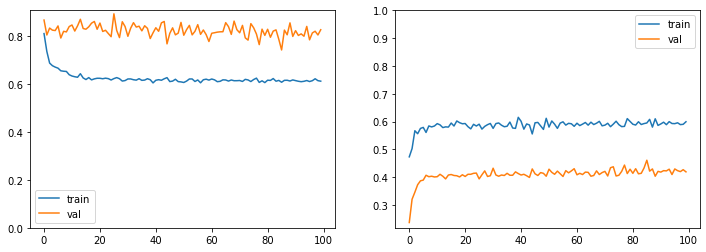

In [47]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### *22. Veil Over Face*

354 of 354
354 of 354
(566, 160, 160, 3) float32
(566,) int32
(142, 160, 160, 3) float32
(142,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 132s 1s/step - loss: 90.2103 - val_loss: 89.4020
Epoch 2/100
100/100 [==============================] - 126s 1s/step - loss: 81.5383 - val_loss: 91.3919
Epoch 3/100
100/100 [==============================] - 121s 1s/step - loss: 74.7521 - val_loss: 94.8859
Epoch 4/100
100/100 [==============================] - 125s 1s/step - loss: 70.8904 - val_loss: 96.7535
Epoch 5/100
100/100 [==============================] - 122s 1s/step - loss: 68.7448 - val_loss: 97.3736
Epoch 6/100
100/100 [==============================] - 126s 1s/step - loss: 66.9207 - val_loss: 96.1764
Epoch 7/100
100/100 [==============================] - 122s 1s/step - loss: 63.5328 - val_loss: 96.2864
Epoch 8/100
100/100 [==============================] - 125s 1s/step - loss: 62.8996 - val_loss: 97.7585
Epoch 9/100
100/100 [==============================] - 121s 1s/step - loss: 60.2920 - val_loss: 98.4415
Epoch 10/100
100/100 [==============================] - 126s 1s/

100/100 [==============================] - 121s 1s/step - loss: 39.0579 - val_loss: 74.0836
Epoch 80/100
100/100 [==============================] - 125s 1s/step - loss: 36.8612 - val_loss: 71.2889
Epoch 81/100
100/100 [==============================] - 121s 1s/step - loss: 36.7468 - val_loss: 72.0218
Epoch 82/100
100/100 [==============================] - 125s 1s/step - loss: 36.9450 - val_loss: 72.7844
Epoch 83/100
100/100 [==============================] - 121s 1s/step - loss: 36.5248 - val_loss: 72.5107
Epoch 84/100
100/100 [==============================] - 125s 1s/step - loss: 37.6124 - val_loss: 73.2695
Epoch 85/100
100/100 [==============================] - 120s 1s/step - loss: 38.3384 - val_loss: 73.2625
Epoch 86/100
100/100 [==============================] - 125s 1s/step - loss: 36.6331 - val_loss: 72.8229
Epoch 87/100
100/100 [==============================] - 121s 1s/step - loss: 35.6897 - val_loss: 73.0777
Epoch 88/100
100/100 [==============================] - 126s 1s/step

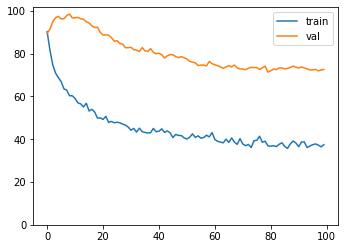

In [48]:
REQ_NAME = 'veil_over_face'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 16s 4ms/step - loss: 0.6015 - accuracy: 0.7341 - precision: 0.9680 - recall: 0.7419 - f1: 0.8387 - specificity: 0.6059 - negative_predictive_value: 0.1354 - matthews_correlation_coefficient: 0.1869 - equal_error_rate: 0.2800 - val_loss: 0.5782 - val_accuracy: 0.7358 - val_precision: 0.9915 - val_recall: 0.7249 - val_f1: 0.8363 - val_specificity: 0.8742 - val_negative_predictive_value: 0.1759 - val_matthews_correlation_coefficient: 0.3140 - val_equal_error_rate: 0.1769

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.31398, saving model to ../../models/siamese_networks/veil_over_face_2020_06_22-00_31_42.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.4894 - accuracy: 0.7594 - precision: 0.9850 - recall: 0.7551 - f1: 0.8544 - specificity: 0.8327 - negative_predictive_value: 0.1806 - matthews_correlation_coefficient: 0.3040 -

4584/4584 [==============================] - 12s 3ms/step - loss: 0.3612 - accuracy: 0.8560 - precision: 0.9909 - recall: 0.8546 - f1: 0.9174 - specificity: 0.8714 - negative_predictive_value: 0.2852 - matthews_correlation_coefficient: 0.4402 - equal_error_rate: 0.1081 - val_loss: 0.4961 - val_accuracy: 0.7977 - val_precision: 0.9901 - val_recall: 0.7919 - val_f1: 0.8794 - val_specificity: 0.8456 - val_negative_predictive_value: 0.2136 - val_matthews_correlation_coefficient: 0.3572 - val_equal_error_rate: 0.1387

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.36194
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.3642 - accuracy: 0.8523 - precision: 0.9902 - recall: 0.8517 - f1: 0.9152 - specificity: 0.8712 - negative_predictive_value: 0.2790 - matthews_correlation_coefficient: 0.4321 - equal_error_rate: 0.1141 - val_loss: 0.5051 - val_accuracy: 0.7995 - val_precision: 0.9901 - val_recall: 0.7938 - val_f1: 0.8804 - val_specifici

4584/4584 [==============================] - 11s 2ms/step - loss: 0.3202 - accuracy: 0.8630 - precision: 0.9914 - recall: 0.8613 - f1: 0.9215 - specificity: 0.9037 - negative_predictive_value: 0.2958 - matthews_correlation_coefficient: 0.4598 - equal_error_rate: 0.0972 - val_loss: 0.4989 - val_accuracy: 0.8082 - val_precision: 0.9891 - val_recall: 0.8047 - val_f1: 0.8867 - val_specificity: 0.8381 - val_negative_predictive_value: 0.2258 - val_matthews_correlation_coefficient: 0.3680 - val_equal_error_rate: 0.1319

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.37423
Epoch 27/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.3244 - accuracy: 0.8719 - precision: 0.9915 - recall: 0.8709 - f1: 0.9271 - specificity: 0.8890 - negative_predictive_value: 0.3149 - matthews_correlation_coefficient: 0.4779 - equal_error_rate: 0.1013 - val_loss: 0.4888 - val_accuracy: 0.8126 - val_precision: 0.9903 - val_recall: 0.8083 - val_f1: 0.8893 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.3349 - accuracy: 0.8765 - precision: 0.9900 - recall: 0.8772 - f1: 0.9300 - specificity: 0.8733 - negative_predictive_value: 0.3164 - matthews_correlation_coefficient: 0.4723 - equal_error_rate: 0.1174 - val_loss: 0.5089 - val_accuracy: 0.8134 - val_precision: 0.9892 - val_recall: 0.8100 - val_f1: 0.8900 - val_specificity: 0.8381 - val_negative_predictive_value: 0.2303 - val_matthews_correlation_coefficient: 0.3733 - val_equal_error_rate: 0.1319

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.38180
Epoch 40/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.3517 - accuracy: 0.8630 - precision: 0.9898 - recall: 0.8631 - f1: 0.9217 - specificity: 0.8720 - negative_predictive_value: 0.2974 - matthews_correlation_coefficient: 0.4491 - equal_error_rate: 0.1158 - val_loss: 0.4920 - val_accuracy: 0.8152 - val_precision: 0.9893 - val_recall: 0.8128 - val_f1: 0.8917 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.3230 - accuracy: 0.8704 - precision: 0.9913 - recall: 0.8696 - f1: 0.9263 - specificity: 0.8925 - negative_predictive_value: 0.3053 - matthews_correlation_coefficient: 0.4660 - equal_error_rate: 0.0958 - val_loss: 0.5248 - val_accuracy: 0.8099 - val_precision: 0.9891 - val_recall: 0.8064 - val_f1: 0.8877 - val_specificity: 0.8381 - val_negative_predictive_value: 0.2273 - val_matthews_correlation_coefficient: 0.3698 - val_equal_error_rate: 0.1319

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.38947
Epoch 53/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.3272 - accuracy: 0.8656 - precision: 0.9912 - recall: 0.8648 - f1: 0.9234 - specificity: 0.8882 - negative_predictive_value: 0.2991 - matthews_correlation_coefficient: 0.4613 - equal_error_rate: 0.0993 - val_loss: 0.4714 - val_accuracy: 0.8230 - val_precision: 0.9894 - val_recall: 0.8207 - val_f1: 0.8964 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.3136 - accuracy: 0.8741 - precision: 0.9916 - recall: 0.8736 - f1: 0.9285 - specificity: 0.8985 - negative_predictive_value: 0.3149 - matthews_correlation_coefficient: 0.4753 - equal_error_rate: 0.0931 - val_loss: 0.5010 - val_accuracy: 0.8178 - val_precision: 0.9893 - val_recall: 0.8154 - val_f1: 0.8933 - val_specificity: 0.8381 - val_negative_predictive_value: 0.2358 - val_matthews_correlation_coefficient: 0.3797 - val_equal_error_rate: 0.1314

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.39080
Epoch 66/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.3233 - accuracy: 0.8798 - precision: 0.9904 - recall: 0.8805 - f1: 0.9319 - specificity: 0.8690 - negative_predictive_value: 0.3245 - matthews_correlation_coefficient: 0.4786 - equal_error_rate: 0.1063 - val_loss: 0.5169 - val_accuracy: 0.8117 - val_precision: 0.9891 - val_recall: 0.8073 - val_f1: 0.8884 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.3221 - accuracy: 0.8702 - precision: 0.9910 - recall: 0.8699 - f1: 0.9262 - specificity: 0.8814 - negative_predictive_value: 0.3113 - matthews_correlation_coefficient: 0.4692 - equal_error_rate: 0.1065 - val_loss: 0.4976 - val_accuracy: 0.8213 - val_precision: 0.9893 - val_recall: 0.8189 - val_f1: 0.8953 - val_specificity: 0.8381 - val_negative_predictive_value: 0.2410 - val_matthews_correlation_coefficient: 0.3849 - val_equal_error_rate: 0.1328

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.39167
Epoch 79/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.3235 - accuracy: 0.8772 - precision: 0.9913 - recall: 0.8770 - f1: 0.9303 - specificity: 0.8875 - negative_predictive_value: 0.3242 - matthews_correlation_coefficient: 0.4857 - equal_error_rate: 0.0947 - val_loss: 0.5116 - val_accuracy: 0.8178 - val_precision: 0.9892 - val_recall: 0.8144 - val_f1: 0.8925 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.3121 - accuracy: 0.8857 - precision: 0.9901 - recall: 0.8872 - f1: 0.9356 - specificity: 0.8682 - negative_predictive_value: 0.3333 - matthews_correlation_coefficient: 0.4871 - equal_error_rate: 0.1094 - val_loss: 0.5043 - val_accuracy: 0.8195 - val_precision: 0.9893 - val_recall: 0.8172 - val_f1: 0.8942 - val_specificity: 0.8381 - val_negative_predictive_value: 0.2391 - val_matthews_correlation_coefficient: 0.3828 - val_equal_error_rate: 0.1310

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.39397
Epoch 92/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.3060 - accuracy: 0.8813 - precision: 0.9927 - recall: 0.8801 - f1: 0.9327 - specificity: 0.9086 - negative_predictive_value: 0.3360 - matthews_correlation_coefficient: 0.5031 - equal_error_rate: 0.0910 - val_loss: 0.4785 - val_accuracy: 0.8265 - val_precision: 0.9894 - val_recall: 0.8244 - val_f1: 0.8985 - val_specifici

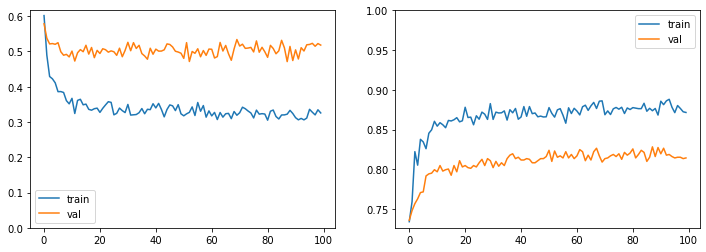

In [49]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### 23. Mouth Open 

452 of 452
420 of 420
(697, 160, 160, 3) float32
(697,) int32
(175, 160, 160, 3) float32
(175,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 138s 1s/step - loss: 97.3406 - val_loss: 95.3399
Epoch 2/100
100/100 [==============================] - 123s 1s/step - loss: 93.2260 - val_loss: 92.7814
Epoch 3/100
100/100 [==============================] - 124s 1s/step - loss: 90.3334 - val_loss: 92.9380
Epoch 4/100
100/100 [==============================] - 124s 1s/step - loss: 88.9321 - val_loss: 101.8874
Epoch 5/100
100/100 [==============================] - 123s 1s/step - loss: 88.6927 - val_loss: 98.6232
Epoch 6/100
100/100 [==============================] - 124s 1s/step - loss: 87.3031 - val_loss: 102.1253
Epoch 7/100
100/100 [==============================] - 124s 1s/step - loss: 85.2524 - val_loss: 103.5061
Epoch 8/100
100/100 [==============================] - 124s 1s/step - loss: 82.8041 - val_loss: 107.0332
Epoch 9/100
100/100 [==============================] - 124s 1s/step - loss: 82.4042 - val_loss: 108.1414
Epoch 10/100
100/100 [==============================] - 123

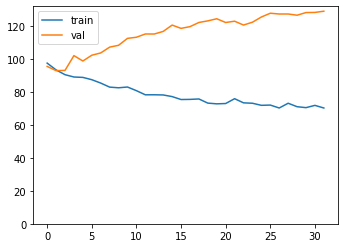

In [50]:
REQ_NAME = 'mouth_open'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 17s 4ms/step - loss: 0.7415 - accuracy: 0.5689 - precision: 0.7316 - recall: 0.6535 - f1: 0.6890 - specificity: 0.3363 - negative_predictive_value: 0.2545 - matthews_correlation_coefficient: -0.0122 - equal_error_rate: 0.4978 - val_loss: 0.6417 - val_accuracy: 0.6696 - val_precision: 0.7996 - val_recall: 0.7376 - val_f1: 0.7666 - val_specificity: 0.4776 - val_negative_predictive_value: 0.3953 - val_matthews_correlation_coefficient: 0.2045 - val_equal_error_rate: 0.3635

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20452, saving model to ../../models/siamese_networks/mouth_open_2020_06_22-02_01_14.h5
Epoch 2/100
4584/4584 [==============================] - 13s 3ms/step - loss: 0.6804 - accuracy: 0.6106 - precision: 0.7812 - recall: 0.6541 - f1: 0.7106 - specificity: 0.4919 - negative_predictive_value: 0.3383 - matthews_correlation_coefficient: 0.1319 - eq


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.29108
Epoch 14/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6328 - accuracy: 0.6497 - precision: 0.8495 - recall: 0.6375 - f1: 0.7273 - specificity: 0.6868 - negative_predictive_value: 0.4058 - matthews_correlation_coefficient: 0.2875 - equal_error_rate: 0.3364 - val_loss: 0.6415 - val_accuracy: 0.6042 - val_precision: 0.8836 - val_recall: 0.5358 - val_f1: 0.6655 - val_specificity: 0.7929 - val_negative_predictive_value: 0.3796 - val_matthews_correlation_coefficient: 0.2937 - val_equal_error_rate: 0.3386

Epoch 00014: val_matthews_correlation_coefficient improved from 0.29108 to 0.29371, saving model to ../../models/siamese_networks/mouth_open_2020_06_22-02_01_14.h5
Epoch 15/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6304 - accuracy: 0.6473 - precision: 0.8420 - recall: 0.6407 - f1: 0.7266 - specificity: 0.6661 - negative_predictive_value: 0.4013 - matthews_

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6215 - accuracy: 0.6525 - precision: 0.8611 - recall: 0.6290 - f1: 0.7259 - specificity: 0.7185 - negative_predictive_value: 0.4118 - matthews_correlation_coefficient: 0.3078 - equal_error_rate: 0.3270 - val_loss: 0.6400 - val_accuracy: 0.5963 - val_precision: 0.8844 - val_recall: 0.5232 - val_f1: 0.6557 - val_specificity: 0.8003 - val_negative_predictive_value: 0.3754 - val_matthews_correlation_coefficient: 0.2895 - val_equal_error_rate: 0.3311

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.29371
Epoch 28/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6240 - accuracy: 0.6466 - precision: 0.8548 - recall: 0.6270 - f1: 0.7220 - specificity: 0.7073 - negative_predictive_value: 0.4063 - matthews_correlation_coefficient: 0.2951 - equal_error_rate: 0.3385 - val_loss: 0.6349 - val_accuracy: 0.5946 - val_precision: 0.8796 - val_recall: 0.5243 - val_f1: 0.6555 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6189 - accuracy: 0.6390 - precision: 0.8714 - recall: 0.5973 - f1: 0.7075 - specificity: 0.7599 - negative_predictive_value: 0.4044 - matthews_correlation_coefficient: 0.3136 - equal_error_rate: 0.3275 - val_loss: 0.6449 - val_accuracy: 0.5929 - val_precision: 0.8900 - val_recall: 0.5168 - val_f1: 0.6512 - val_specificity: 0.8129 - val_negative_predictive_value: 0.3771 - val_matthews_correlation_coefficient: 0.2963 - val_equal_error_rate: 0.3224

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.29695
Epoch 41/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6164 - accuracy: 0.6494 - precision: 0.8622 - recall: 0.6245 - f1: 0.7227 - specificity: 0.7235 - negative_predictive_value: 0.4103 - matthews_correlation_coefficient: 0.3075 - equal_error_rate: 0.3276 - val_loss: 0.6463 - val_accuracy: 0.5929 - val_precision: 0.8910 - val_recall: 0.5132 - val_f1: 0.6492 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6151 - accuracy: 0.6494 - precision: 0.8676 - recall: 0.6175 - f1: 0.7202 - specificity: 0.7432 - negative_predictive_value: 0.4113 - matthews_correlation_coefficient: 0.3167 - equal_error_rate: 0.3152 - val_loss: 0.6523 - val_accuracy: 0.5885 - val_precision: 0.8923 - val_recall: 0.5076 - val_f1: 0.6443 - val_specificity: 0.8207 - val_negative_predictive_value: 0.3744 - val_matthews_correlation_coefficient: 0.2955 - val_equal_error_rate: 0.3262

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.29695
Epoch 54/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6175 - accuracy: 0.6545 - precision: 0.8673 - recall: 0.6272 - f1: 0.7265 - specificity: 0.7382 - negative_predictive_value: 0.4154 - matthews_correlation_coefficient: 0.3209 - equal_error_rate: 0.3222 - val_loss: 0.6584 - val_accuracy: 0.5850 - val_precision: 0.8913 - val_recall: 0.5019 - val_f1: 0.6395 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6196 - accuracy: 0.6473 - precision: 0.8686 - recall: 0.6132 - f1: 0.7178 - specificity: 0.7427 - negative_predictive_value: 0.4096 - matthews_correlation_coefficient: 0.3141 - equal_error_rate: 0.3165 - val_loss: 0.6652 - val_accuracy: 0.5789 - val_precision: 0.8897 - val_recall: 0.4938 - val_f1: 0.6322 - val_specificity: 0.8207 - val_negative_predictive_value: 0.3679 - val_matthews_correlation_coefficient: 0.2841 - val_equal_error_rate: 0.3245

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.29945
Epoch 67/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6151 - accuracy: 0.6429 - precision: 0.8684 - recall: 0.6073 - f1: 0.7134 - specificity: 0.7471 - negative_predictive_value: 0.4065 - matthews_correlation_coefficient: 0.3117 - equal_error_rate: 0.3158 - val_loss: 0.6652 - val_accuracy: 0.5798 - val_precision: 0.8898 - val_recall: 0.4950 - val_f1: 0.6331 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6106 - accuracy: 0.6477 - precision: 0.8662 - recall: 0.6143 - f1: 0.7178 - specificity: 0.7428 - negative_predictive_value: 0.4095 - matthews_correlation_coefficient: 0.3133 - equal_error_rate: 0.3180 - val_loss: 0.6852 - val_accuracy: 0.5684 - val_precision: 0.8883 - val_recall: 0.4769 - val_f1: 0.6176 - val_specificity: 0.8240 - val_negative_predictive_value: 0.3612 - val_matthews_correlation_coefficient: 0.2735 - val_equal_error_rate: 0.3239

Epoch 00079: val_matthews_correlation_coefficient did not improve from 0.29945
Epoch 80/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6168 - accuracy: 0.6396 - precision: 0.8585 - recall: 0.6107 - f1: 0.7121 - specificity: 0.7249 - negative_predictive_value: 0.4026 - matthews_correlation_coefficient: 0.2956 - equal_error_rate: 0.3347 - val_loss: 0.6871 - val_accuracy: 0.5684 - val_precision: 0.8888 - val_recall: 0.4780 - val_f1: 0.6187 - val_specifici

4584/4584 [==============================] - 12s 3ms/step - loss: 0.6163 - accuracy: 0.6414 - precision: 0.8640 - recall: 0.6077 - f1: 0.7121 - specificity: 0.7365 - negative_predictive_value: 0.4029 - matthews_correlation_coefficient: 0.3026 - equal_error_rate: 0.3328 - val_loss: 0.6968 - val_accuracy: 0.5615 - val_precision: 0.8881 - val_recall: 0.4662 - val_f1: 0.6085 - val_specificity: 0.8265 - val_negative_predictive_value: 0.3569 - val_matthews_correlation_coefficient: 0.2673 - val_equal_error_rate: 0.3208

Epoch 00092: val_matthews_correlation_coefficient did not improve from 0.29945
Epoch 93/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.6096 - accuracy: 0.6431 - precision: 0.8682 - recall: 0.6083 - f1: 0.7137 - specificity: 0.7455 - negative_predictive_value: 0.4075 - matthews_correlation_coefficient: 0.3118 - equal_error_rate: 0.3127 - val_loss: 0.6820 - val_accuracy: 0.5719 - val_precision: 0.8920 - val_recall: 0.4847 - val_f1: 0.6240 - val_specifici

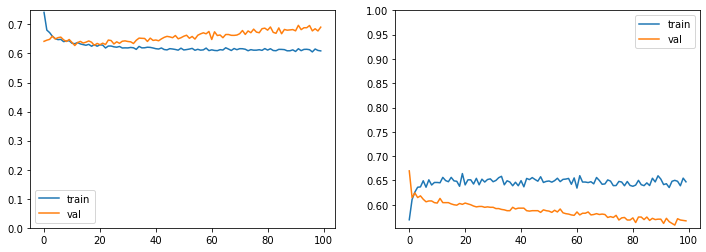

In [51]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

#### *24. Presence of Other Faces or Toys too Close to Face*

64 of 64
18 of 18
(65, 160, 160, 3) float32
(65,) int32
(17, 160, 160, 3) float32
(17,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 68s 676ms/step - loss: 99.2781 - val_loss: 102.1487
Epoch 2/100
100/100 [==============================] - 63s 633ms/step - loss: 97.1033 - val_loss: 103.5664
Epoch 3/100
100/100 [==============================] - 63s 634ms/step - loss: 94.8111 - val_loss: 102.1997
Epoch 4/100
100/100 [==============================] - 63s 633ms/step - loss: 92.1884 - val_loss: 100.2911
Epoch 5/100
100/100 [==============================] - 63s 633ms/step - loss: 89.4820 - val_loss: 104.6122
Epoch 6/100
100/100 [==============================] - 63s 633ms/step - loss: 87.3459 - val_loss: 98.0400
Epoch 7/100
100/100 [==============================] - 63s 633ms/step - loss: 85.4243 - val_loss: 98.3667
Epoch 8/100
100/100 [==============================] - 64s 635ms/step - loss: 83.5012 - val_loss: 99.6417
Epoch 9/100
100/100 [==============================] - 63s 633ms/step - loss: 82.0402 - val_loss: 104.4797
Epoch 10/100
100/100 [==================

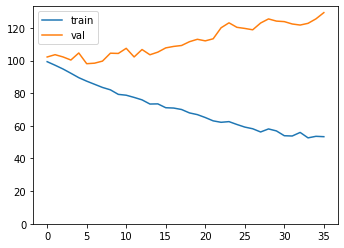

In [52]:
REQ_NAME = 'presence_of_other_faces_or_toys'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 16s 4ms/step - loss: 0.6970 - accuracy: 0.6678 - precision: 0.9906 - recall: 0.6705 - f1: 0.7980 - specificity: 0.3460 - negative_predictive_value: 0.0178 - matthews_correlation_coefficient: 0.0277 - equal_error_rate: 0.1905 - val_loss: 0.6092 - val_accuracy: 0.7873 - val_precision: 0.9887 - val_recall: 0.7932 - val_f1: 0.8798 - val_specificity: 0.1000 - val_negative_predictive_value: 0.0115 - val_matthews_correlation_coefficient: -0.0057 - val_equal_error_rate: 0.1875

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.00569, saving model to ../../models/siamese_networks/presence_of_other_faces_or_toys_2020_06_22-03_03_03.h5
Epoch 2/100
4584/4584 [==============================] - 12s 3ms/step - loss: 0.7070 - accuracy: 0.6137 - precision: 0.9902 - recall: 0.6152 - f1: 0.7576 - specificity: 0.3678 - negative_predictive_value: 0.0161 - matthews_correlation_co

4584/4584 [==============================] - 11s 2ms/step - loss: 0.5341 - accuracy: 0.7125 - precision: 0.9961 - recall: 0.7120 - f1: 0.8296 - specificity: 0.5018 - negative_predictive_value: 0.0315 - matthews_correlation_coefficient: 0.0885 - equal_error_rate: 0.0954 - val_loss: 0.5746 - val_accuracy: 0.7629 - val_precision: 0.9967 - val_recall: 0.7619 - val_f1: 0.8630 - val_specificity: 0.4583 - val_negative_predictive_value: 0.0379 - val_matthews_correlation_coefficient: 0.0970 - val_equal_error_rate: 0.0960

Epoch 00013: val_matthews_correlation_coefficient improved from 0.09615 to 0.09701, saving model to ../../models/siamese_networks/presence_of_other_faces_or_toys_2020_06_22-03_03_03.h5
Epoch 14/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.5217 - accuracy: 0.7273 - precision: 0.9965 - recall: 0.7269 - f1: 0.8399 - specificity: 0.5725 - negative_predictive_value: 0.0352 - matthews_correlation_coefficient: 0.1066 - equal_error_rate: 0.1055 - val_loss: 0

4584/4584 [==============================] - 11s 2ms/step - loss: 0.5386 - accuracy: 0.7347 - precision: 0.9962 - recall: 0.7343 - f1: 0.8450 - specificity: 0.4812 - negative_predictive_value: 0.0343 - matthews_correlation_coefficient: 0.0934 - equal_error_rate: 0.1037 - val_loss: 0.5869 - val_accuracy: 0.7550 - val_precision: 0.9966 - val_recall: 0.7543 - val_f1: 0.8583 - val_specificity: 0.4583 - val_negative_predictive_value: 0.0358 - val_matthews_correlation_coefficient: 0.0930 - val_equal_error_rate: 0.0909

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.09958
Epoch 27/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.5023 - accuracy: 0.7367 - precision: 0.9965 - recall: 0.7364 - f1: 0.8465 - specificity: 0.6486 - negative_predictive_value: 0.0364 - matthews_correlation_coefficient: 0.1180 - equal_error_rate: 0.0966 - val_loss: 0.5786 - val_accuracy: 0.7559 - val_precision: 0.9966 - val_recall: 0.7551 - val_f1: 0.8588 - val_specifici

4584/4584 [==============================] - 11s 2ms/step - loss: 0.5214 - accuracy: 0.7683 - precision: 0.9960 - recall: 0.7686 - f1: 0.8672 - specificity: 0.5743 - negative_predictive_value: 0.0386 - matthews_correlation_coefficient: 0.1163 - equal_error_rate: 0.1097 - val_loss: 0.5591 - val_accuracy: 0.7663 - val_precision: 0.9967 - val_recall: 0.7661 - val_f1: 0.8658 - val_specificity: 0.4583 - val_negative_predictive_value: 0.0364 - val_matthews_correlation_coefficient: 0.0959 - val_equal_error_rate: 0.0867

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.10001
Epoch 40/100
4584/4584 [==============================] - 10s 2ms/step - loss: 0.4492 - accuracy: 0.7496 - precision: 0.9974 - recall: 0.7485 - f1: 0.8548 - specificity: 0.5507 - negative_predictive_value: 0.0396 - matthews_correlation_coefficient: 0.1160 - equal_error_rate: 0.0610 - val_loss: 0.5414 - val_accuracy: 0.7716 - val_precision: 0.9968 - val_recall: 0.7712 - val_f1: 0.8689 - val_specifici

4584/4584 [==============================] - 10s 2ms/step - loss: 0.4783 - accuracy: 0.7707 - precision: 0.9970 - recall: 0.7704 - f1: 0.8685 - specificity: 0.4674 - negative_predictive_value: 0.0435 - matthews_correlation_coefficient: 0.1108 - equal_error_rate: 0.0632 - val_loss: 0.5871 - val_accuracy: 0.7446 - val_precision: 0.9967 - val_recall: 0.7441 - val_f1: 0.8515 - val_specificity: 0.4583 - val_negative_predictive_value: 0.0331 - val_matthews_correlation_coefficient: 0.0880 - val_equal_error_rate: 0.0820

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.10001
Epoch 53/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.4718 - accuracy: 0.7546 - precision: 0.9968 - recall: 0.7541 - f1: 0.8582 - specificity: 0.5652 - negative_predictive_value: 0.0390 - matthews_correlation_coefficient: 0.1155 - equal_error_rate: 0.0851 - val_loss: 0.5612 - val_accuracy: 0.7611 - val_precision: 0.9968 - val_recall: 0.7601 - val_f1: 0.8618 - val_specifici

4584/4584 [==============================] - 10s 2ms/step - loss: 0.4463 - accuracy: 0.7760 - precision: 0.9977 - recall: 0.7749 - f1: 0.8720 - specificity: 0.5942 - negative_predictive_value: 0.0454 - matthews_correlation_coefficient: 0.1326 - equal_error_rate: 0.0617 - val_loss: 0.5555 - val_accuracy: 0.7655 - val_precision: 0.9967 - val_recall: 0.7653 - val_f1: 0.8652 - val_specificity: 0.4583 - val_negative_predictive_value: 0.0364 - val_matthews_correlation_coefficient: 0.0960 - val_equal_error_rate: 0.0841

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.10001
Epoch 66/100
4584/4584 [==============================] - 11s 2ms/step - loss: 0.4736 - accuracy: 0.7866 - precision: 0.9970 - recall: 0.7866 - f1: 0.8790 - specificity: 0.5326 - negative_predictive_value: 0.0449 - matthews_correlation_coefficient: 0.1249 - equal_error_rate: 0.0902 - val_loss: 0.5496 - val_accuracy: 0.7759 - val_precision: 0.9968 - val_recall: 0.7753 - val_f1: 0.8716 - val_specifici

4584/4584 [==============================] - 10s 2ms/step - loss: 0.4550 - accuracy: 0.7720 - precision: 0.9974 - recall: 0.7712 - f1: 0.8695 - specificity: 0.5707 - negative_predictive_value: 0.0432 - matthews_correlation_coefficient: 0.1270 - equal_error_rate: 0.0601 - val_loss: 0.5575 - val_accuracy: 0.7550 - val_precision: 0.9967 - val_recall: 0.7551 - val_f1: 0.8587 - val_specificity: 0.4583 - val_negative_predictive_value: 0.0343 - val_matthews_correlation_coefficient: 0.0912 - val_equal_error_rate: 0.0816

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.10001
Epoch 79/100
4584/4584 [==============================] - 10s 2ms/step - loss: 0.4896 - accuracy: 0.7653 - precision: 0.9974 - recall: 0.7645 - f1: 0.8651 - specificity: 0.6576 - negative_predictive_value: 0.0419 - matthews_correlation_coefficient: 0.1343 - equal_error_rate: 0.0921 - val_loss: 0.5616 - val_accuracy: 0.7559 - val_precision: 0.9967 - val_recall: 0.7560 - val_f1: 0.8593 - val_specifici

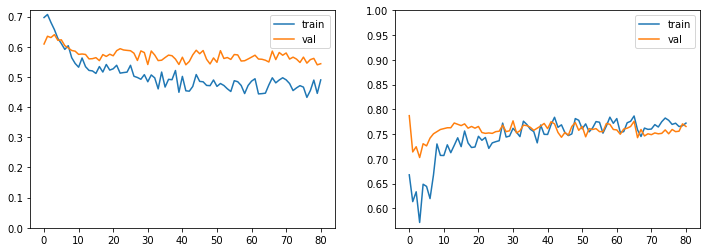

In [53]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

file_model = run_classification_training(model_shared, x, y, REQ_NAME)

list_model_files.append(file_model)

# Models Merge

In [54]:
def load_shared_model(file_autoencoder):
    autoencoder = load_model(file_autoencoder)
    encoder_output = autoencoder.get_layer(name='encoded').output
    embeddings = GlobalAvgPool2D(name='embeddings')(encoder_output)
    shared_model = Model(inputs=autoencoder.inputs, outputs=embeddings)
    return shared_model


def add_requirement_branch_to_base_model(base_model, req_model):
    n_layers = len(base_model.layers)
    req_layers = [layer for layer in req_model.layers[n_layers:]]

    outputs = base_model.output
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)
    return outputs

In [55]:
shared_model = load_shared_model(FILE_BASE_MODEL)
shared_model.summary()

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "model_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 80, 80, 64)        256

In [56]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc,
    'equal_error_rate': eer
}

list_models = [load_model(file, custom_objects=custom_objects) for file in list_model_files]
list_outputs = [add_requirement_branch_to_base_model(shared_model, req_model) for req_model in list_models]

In [57]:
FILE_MERGED_MODEL = FOLDER_MODELS + '/' + timestamp_model_name(prefix='merged_model_')
print(FILE_MERGED_MODEL)

merged_model = Model(inputs=shared_model.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

../../models/siamese_networks/merged_model_2020_06_22-03_40_11.h5
Model: "model_86"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
_________________________

In [58]:
import cv2
from glob import glob

list_files = ['../../data/cropped_faces/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../../data/cropped_faces/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.795191]], dtype=float32),
 array([[0.5067148]], dtype=float32),
 array([[0.54681766]], dtype=float32),
 array([[0.35476717]], dtype=float32),
 array([[0.745216]], dtype=float32),
 array([[0.45717165]], dtype=float32),
 array([[0.4604364]], dtype=float32),
 array([[0.5657718]], dtype=float32),
 array([[0.11280304]], dtype=float32),
 array([[0.79342306]], dtype=float32),
 array([[0.46118504]], dtype=float32),
 array([[0.35819858]], dtype=float32),
 array([[0.8388116]], dtype=float32),
 array([[0.70506877]], dtype=float32),
 array([[0.42486507]], dtype=float32),
 array([[0.29385525]], dtype=float32),
 array([[0.6221079]], dtype=float32),
 array([[0.933086]], dtype=float32),
 array([[0.1298492]], dtype=float32),
 array([[0.2292362]], dtype=float32),
 array([[0.77153105]], dtype=float32)]

In [59]:
print(np.array(list_model_files))

['../../models/siamese_networks/blurred_2020_06_20-22_47_22.h5'
 '../../models/siamese_networks/looking_away_2020_06_20-23_47_30.h5'
 '../../models/siamese_networks/unnatural_skin_tone_2020_06_21-00_30_34.h5'
 '../../models/siamese_networks/too_dark_light_2020_06_21-01_08_51.h5'
 '../../models/siamese_networks/washed_out_2020_06_21-02_38_26.h5'
 '../../models/siamese_networks/pixelation_2020_06_21-03_25_55.h5'
 '../../models/siamese_networks/hair_across_eyes_2020_06_21-04_13_33.h5'
 '../../models/siamese_networks/eyes_closed_2020_06_21-05_15_30.h5'
 '../../models/siamese_networks/varied_background_2020_06_21-06_17_28.h5'
 '../../models/siamese_networks/roll_pitch_yaw_2020_06_21-08_37_17.h5'
 '../../models/siamese_networks/flash_reflection_on_skin_2020_06_21-09_28_01.h5'
 '../../models/siamese_networks/red_eyes_2020_06_21-10_26_45.h5'
 '../../models/siamese_networks/shadows_behind_head_2020_06_21-11_25_52.h5'
 '../../models/siamese_networks/shadows_across_face_2020_06_21-12_34_35.h5'
 '